<a href="https://colab.research.google.com/github/kkangji12/DAP/blob/main/immergedkkk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin data
In this lab, we would like to explore *Time-Series* data about Bitcoin price.

Since the data is acquired too frequently, we would like to downsample the data to have a value only once in a week. Please refer the [documents](https://rfriend.tistory.com/494) of `resample().mean()` method.


In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7),
                     'figure.dpi': 120})

# Import as Dataframe
df_original = pd.read_csv('https://raw.githubusercontent.com/choi-hyunsoo/DAP/main/coin_Bitcoin.csv',
                 parse_dates=['Date']).set_index('Date') #s시계열 데이터
#1주일에 한번으로 resmaple한것임. 
df = df_original.resample("1W").mean()
df.head()

SNo        High         Low        Open       Close  Volume  \
Date                                                                       
2013-05-05   4.0  128.833714  106.684986  121.582000  118.842856     0.0   
2013-05-12  11.0  117.925000  108.742286  113.881286  113.925571     0.0   
2013-05-19  18.0  121.159858  114.127428  117.620143  118.709001     0.0   
2013-05-26  25.0  128.660714  124.523429  126.085143  127.732712     0.0   
2013-06-02  32.0  131.423569  124.801571  130.204858  128.633714     0.0   

               Marketcap  
Date                      
2013-05-05  1.319866e+09  
2013-05-12  1.268553e+09  
2013-05-19  1.325205e+09  
2013-05-26  1.429371e+09  
2013-06-02  1.443233e+09

# Draw Plot

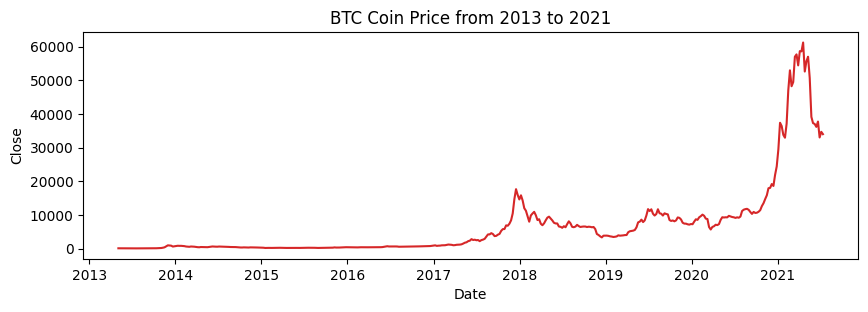

In [2]:
def plot_df(x, y, title="", xlabel='Date', ylabel='Close', dpi=100):
    plt.figure(figsize=(10,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(x=df.index, y=df.Close, #해당 x y값 지정
        title='BTC Coin Price from 2013 to 2021')    

**[TODO]** Draw `Year-wise Box Plot` and `Month-wise Box Plot`.

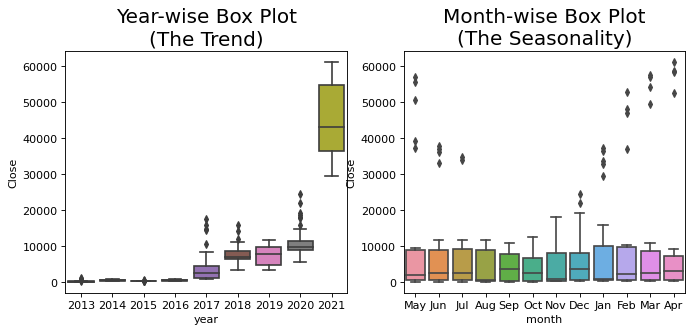

In [3]:
# Prepare data
#각각의 index에서 year month만 추출
df['year'] = [d.year for d in df.index] #for문을 쭉 받아 리스트로 만든다.그래서 대괄호로 둘러싼거

# strftime %b는 축약된 월명 feb 이런식
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi= 80)
#axes[0]은 첫번째 axes를 말하는거임.
sns.boxplot(x=df['year'], y=df.Close, data=df, ax=axes[0])#x,y명시
sns.boxplot(x=df['month'], y=df.Close, data=df, ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Decomposite the data into Trend, Seasonal, Residual using `seasonal_decompose`.

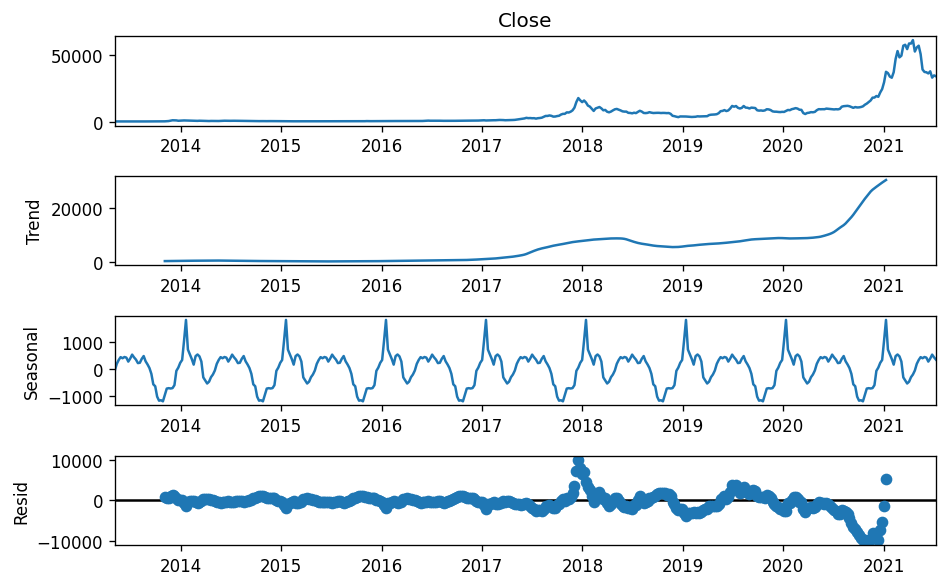

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Decomposition 
decompositionResult = seasonal_decompose(df.Close) #열 넣기

# Plot
plt.rcParams.update({'figure.figsize': (8,5)})
decompositionResult.plot()
plt.show()

# Interpolation
Due to some errors in databes, the data of the first quater is lost. So we would like to guess the value using interpolation.

In [5]:
# Generate the missing data
df_missing = df.copy()
df_missing[(df.index.month <= 3)] = np.nan

**[TODO]** Forward and Backward Fill loss seems to be not proper. Please apply Linear Interpolation.

In [6]:
from scipy.interpolate import interp1d

# Forward Fill
df_ffill = df_missing.ffill() #fowardfill 변화가 클땐 x

# Backward Fill
df_bfill = df_missing.bfill()

# Linear Interpolation
df_lfill = df_missing.copy()
df_missing['rownum']=np.arange(df_missing.shape[0]) #missing 개수 찾기 이것을 인덱스 넣어줌
#subset 지정으로 subset인 값만 drop한다. close가 빈 값. 사실 이건 그냥 아무거나 명시 어차피 3월짜리는 다 빼려고
df_missing_nona = df_missing.dropna(subset=['Close']) #Nan값 빠딘 데이터
f = interp1d(df_missing_nona['rownum'],df_missing_nona['Close'])
df_lfill.Close = f(df_missing['rownum']) #인덱스를 받아오고 빠진곳에 채운다


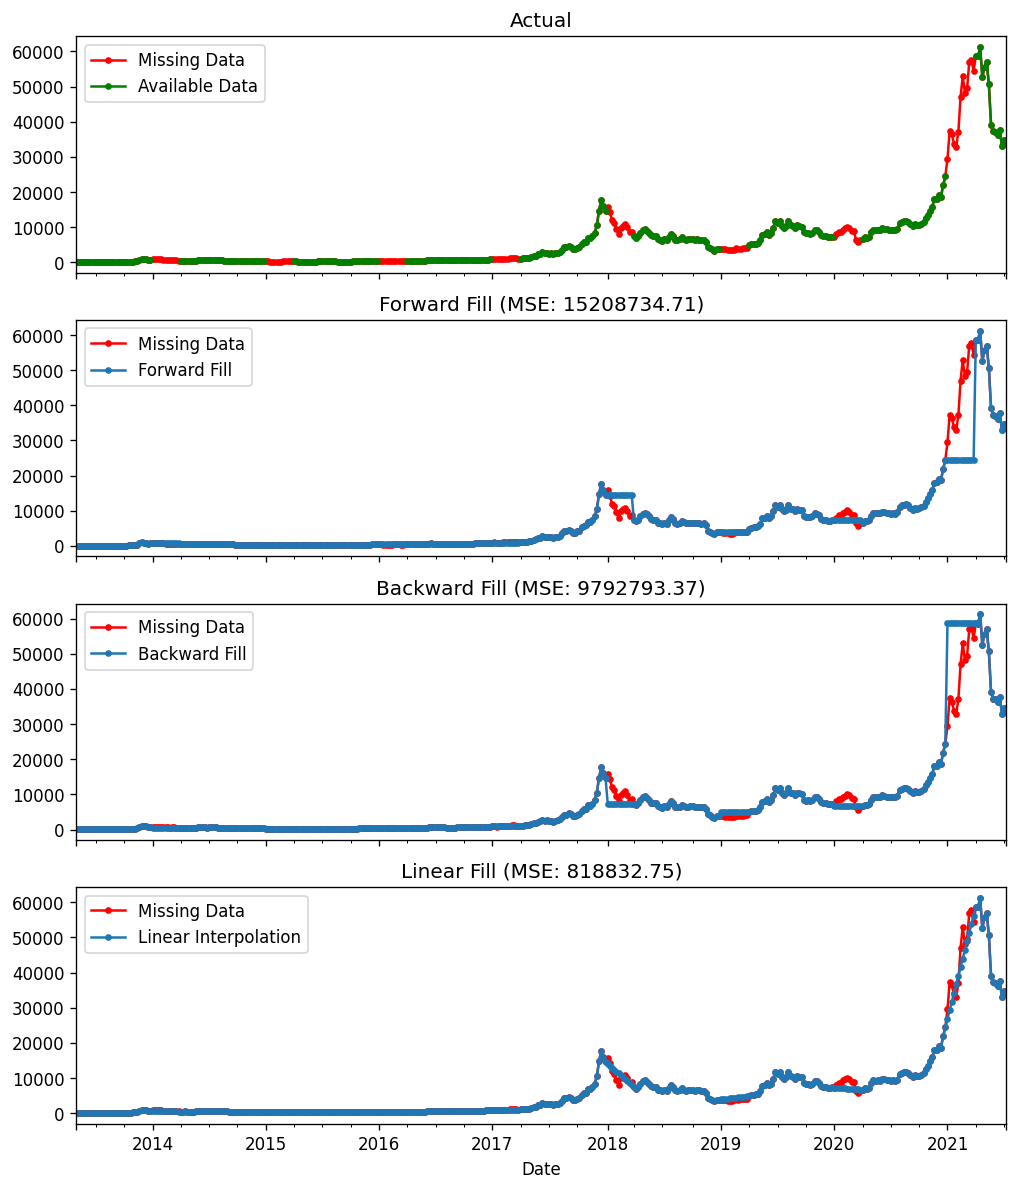

In [7]:
# Calculate Error
from sklearn.metrics import mean_squared_error

error_ffill = np.round(mean_squared_error(df['Close'], df_ffill['Close']), 2)
error_bfill = np.round(mean_squared_error(df['Close'], df_bfill['Close']), 2)
error_lfill = np.round(mean_squared_error(df['Close'], df_lfill['Close']), 2)


# Plotting
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

for ax in axes:
  df.Close.plot(title='Actual', ax=ax, label='Actual', color='red', style=".-")

df_missing.Close.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
df_ffill.Close.plot(title='Forward Fill (MSE: ' + str(error_ffill) +")", ax=axes[1],
                       label='Forward Fill', style=".-")
df_bfill.Close.plot(title="Backward Fill (MSE: " + str(error_bfill) +")", ax=axes[2],
                       label='Back Fill', style=".-")
df_lfill.Close.plot(title="Linear Fill (MSE: " + str(error_lfill) +")",
                       ax=axes[3], label='Cubic Fill', style=".-")


# Add legend
methods = ['Available Data', 'Forward Fill',
           'Backward Fill', 'Linear Interpolation']
for ax, mt in zip(axes, methods):
  ax.legend(["Missing Data", mt])


# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

# Smoothing

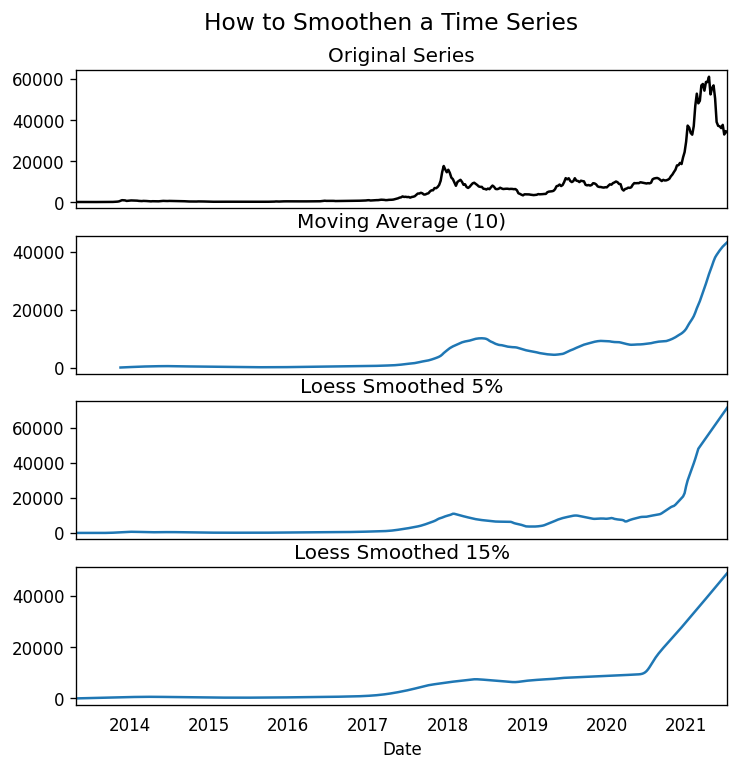

In [8]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving Average
df_ma = df.Close.rolling(30).mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(
    lowess(df.Close, np.arange(len(df.Close)), frac=0.05)[:, 1],
    index=df.index, columns=['Close'])

df_loess_15 = pd.DataFrame(
    lowess(df.Close, np.arange(len(df.Close)), frac=0.15)[:, 1],
    index=df.index, columns=['Close'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)

df['Close'].plot(ax=axes[0], color='k', title='Original Series')
df_ma.plot(ax=axes[1], title='Moving Average (10)')
df_loess_5['Close'].plot(ax=axes[2], title='Loess Smoothed 5%')
df_loess_15['Close'].plot(ax=axes[3], title='Loess Smoothed 15%')

fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

#TODO
### 춘천 날씨데이터 
 - 이번 과제는 2001년부터 2022년 현재까지의 날씨 데이터를 이용해보겠습니다!

In [9]:
df = pd.read_excel('https://github.com/wonseok-hong/DAP_TA/blob/main/weather_cc.xlsx?raw=true',
                    parse_dates=['Date']).set_index('Date')
df

City  Average Temperature  Average Highest Temperature  \
Date                                                                
2001-01-01   춘천                 -6.7                         -1.0   
2001-02-01   춘천                 -2.5                          4.0   
2001-03-01   춘천                  3.3                         10.3   
2001-04-01   춘천                 12.3                         20.8   
2001-05-01   춘천                 18.8                         26.5   
...         ...                  ...                          ...   
2022-06-01   춘천                 22.6                         27.4   
2022-07-01   춘천                 26.6                         31.3   
2022-08-01   춘천                 25.2                         29.0   
2022-09-01   춘천                 20.5                         26.7   
2022-10-01   춘천                  NaN                          NaN   

            Highest Temperature  Average Lowest emperature  Lowest Temperature  
Date                                                                            
2001-01-01                  7.3                      -12.3               -24.5  
2001-02-01                 13.5                       -8.2               -18.6  
2001-03-01                 22.1                       -2.7                -7.6  
2001-04-01                 28.0                        3.9                -4.1  
2001-05-01                 32.9                       11.7                 6.1  
...                         ...                        ...                 ...  
2022-06-01                 34.8                       18.3                10.5  
2022-07-01                 35.3                       23.0                20.4  
2022-08-01                 33.3                       22.1                13.7  
2022-09-01                 31.2                       15.8                 7.9  
2022-10-01                 26.3                        NaN                13.4  

[262 rows x 6 columns]

###1. 데이터 drop시키기
연도별로 데이터가 1월부터 12월까지 존재하지만 `2022년`은 `10월 이후의 값`들이 존재하지 않습니다. 게다가 10월에는 결측값들이 발견됩니다. 

`2022년`의 데이터를 `drop`시켜주세요!

In [10]:
#date를 인덱스에서 칼럼으로 꺼냄
df_ri=  df.reset_index()

#df_ri의 인덱스는 이제 0~ 행 개수이니 df.index에서 0부터 쭉 꺼내옴 year만
df_ri['year'] = df.index[df_ri.index].year

index_2022= df_ri[df_ri['year']>2022].index #2022 부터 삭제
# 삭제시 인덱스 넣어도 됨
df_ri.drop(index_2022, inplace=True)
df_ri

Date City  Average Temperature  Average Highest Temperature  \
0   2001-01-01   춘천                 -6.7                         -1.0   
1   2001-02-01   춘천                 -2.5                          4.0   
2   2001-03-01   춘천                  3.3                         10.3   
3   2001-04-01   춘천                 12.3                         20.8   
4   2001-05-01   춘천                 18.8                         26.5   
..         ...  ...                  ...                          ...   
257 2022-06-01   춘천                 22.6                         27.4   
258 2022-07-01   춘천                 26.6                         31.3   
259 2022-08-01   춘천                 25.2                         29.0   
260 2022-09-01   춘천                 20.5                         26.7   
261 2022-10-01   춘천                  NaN                          NaN   

     Highest Temperature  Average Lowest emperature  Lowest Temperature  year  
0                    7.3                      -12.3               -24.5  2001  
1                   13.5                       -8.2               -18.6  2001  
2                   22.1                       -2.7                -7.6  2001  
3                   28.0                        3.9                -4.1  2001  
4                   32.9                       11.7                 6.1  2001  
..                   ...                        ...                 ...   ...  
257                 34.8                       18.3                10.5  2022  
258                 35.3                       23.0                20.4  2022  
259                 33.3                       22.1                13.7  2022  
260                 31.2                       15.8                 7.9  2022  
261                 26.3                        NaN                13.4  2022  

[262 rows x 8 columns]

### 2. box plot으로 표현하기
`Average Temperature`의`Trend`와 `Seasonality`를 boxplot으로 나타내세요

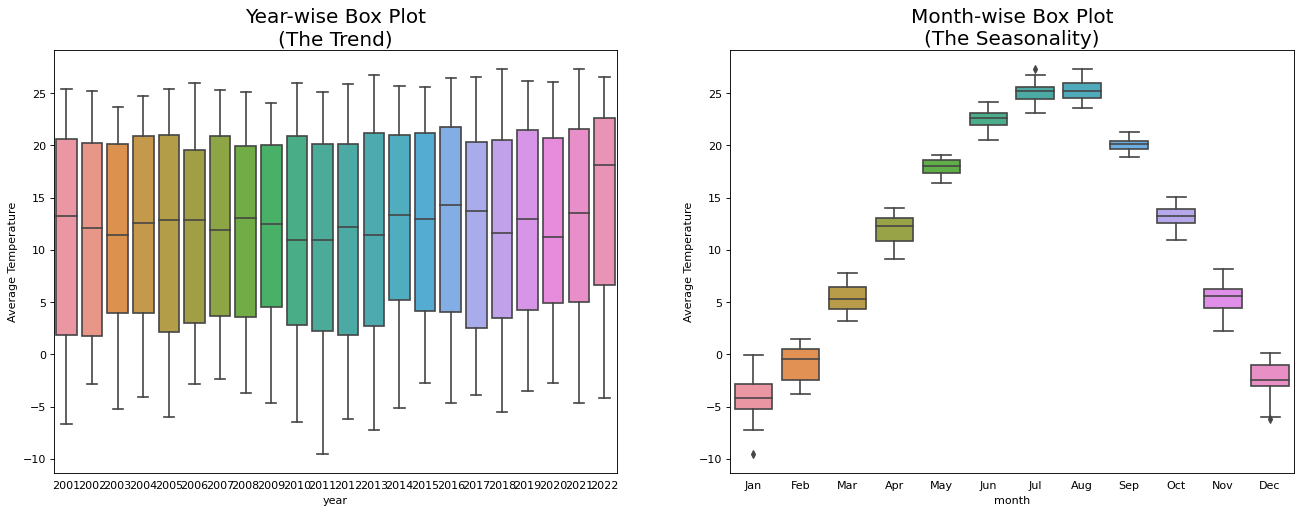

In [11]:
#d의 인덱스에서 feb이런식의 월별로 뽑아옴
df_ri['month'] = [d.strftime('%b') for d in df.index]

fig, axes = plt.subplots(1,2,figsize=(20,7), dpi=80)
sns.boxplot(x= df_ri['year'], y=df_ri['Average Temperature'], data=df_ri, ax=axes[0])

sns.boxplot(x=df_ri['month'], y=df_ri['Average Temperature'], data=df_ri, ax= axes[1])

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)


plt.show()

### 3. 결측값 만들어주기
- 10,11,12월의 값을 `NaN`값으로 만들어주세요

In [12]:
df_nan = df.copy()
df_nan[(10<=df.index.month)]=np.nan #month가 10월 보다 크거나 같으면 nan으로
df_nan

City  Average Temperature  Average Highest Temperature  \
Date                                                                
2001-01-01   춘천                 -6.7                         -1.0   
2001-02-01   춘천                 -2.5                          4.0   
2001-03-01   춘천                  3.3                         10.3   
2001-04-01   춘천                 12.3                         20.8   
2001-05-01   춘천                 18.8                         26.5   
...         ...                  ...                          ...   
2022-06-01   춘천                 22.6                         27.4   
2022-07-01   춘천                 26.6                         31.3   
2022-08-01   춘천                 25.2                         29.0   
2022-09-01   춘천                 20.5                         26.7   
2022-10-01  NaN                  NaN                          NaN   

            Highest Temperature  Average Lowest emperature  Lowest Temperature  
Date                                                                            
2001-01-01                  7.3                      -12.3               -24.5  
2001-02-01                 13.5                       -8.2               -18.6  
2001-03-01                 22.1                       -2.7                -7.6  
2001-04-01                 28.0                        3.9                -4.1  
2001-05-01                 32.9                       11.7                 6.1  
...                         ...                        ...                 ...  
2022-06-01                 34.8                       18.3                10.5  
2022-07-01                 35.3                       23.0                20.4  
2022-08-01                 33.3                       22.1                13.7  
2022-09-01                 31.2                       15.8                 7.9  
2022-10-01                  NaN                        NaN                 NaN  

[262 rows x 6 columns]

## 4. Drop

- interpolation을 하기 위해서는 그래프가 `연속`이어야 합니다. 
- df와 df_nan의 경우 마지막 2022-10-01의 값이 NaN값이기 때문에 df_nan과 df의 `2022-10-01`의값을 drop시켜주세요

In [13]:
df_nan=df_nan.drop(['2022-10-01'])
df=df.drop(['2022-10-01'])

print(df_nan)
print(df)

           City  Average Temperature  Average Highest Temperature  \
Date                                                                
2001-01-01   춘천                 -6.7                         -1.0   
2001-02-01   춘천                 -2.5                          4.0   
2001-03-01   춘천                  3.3                         10.3   
2001-04-01   춘천                 12.3                         20.8   
2001-05-01   춘천                 18.8                         26.5   
...         ...                  ...                          ...   
2022-05-01   춘천                 18.1                         25.3   
2022-06-01   춘천                 22.6                         27.4   
2022-07-01   춘천                 26.6                         31.3   
2022-08-01   춘천                 25.2                         29.0   
2022-09-01   춘천                 20.5                         26.7   

            Highest Temperature  Average Lowest emperature  Lowest Temperature  
Date                 

#5. Interpolation

- 결측치를 `quadratic`을 사용해서 채워주세요!
- `Lowest Temperature`에 대한 그래프를 그려주세요!

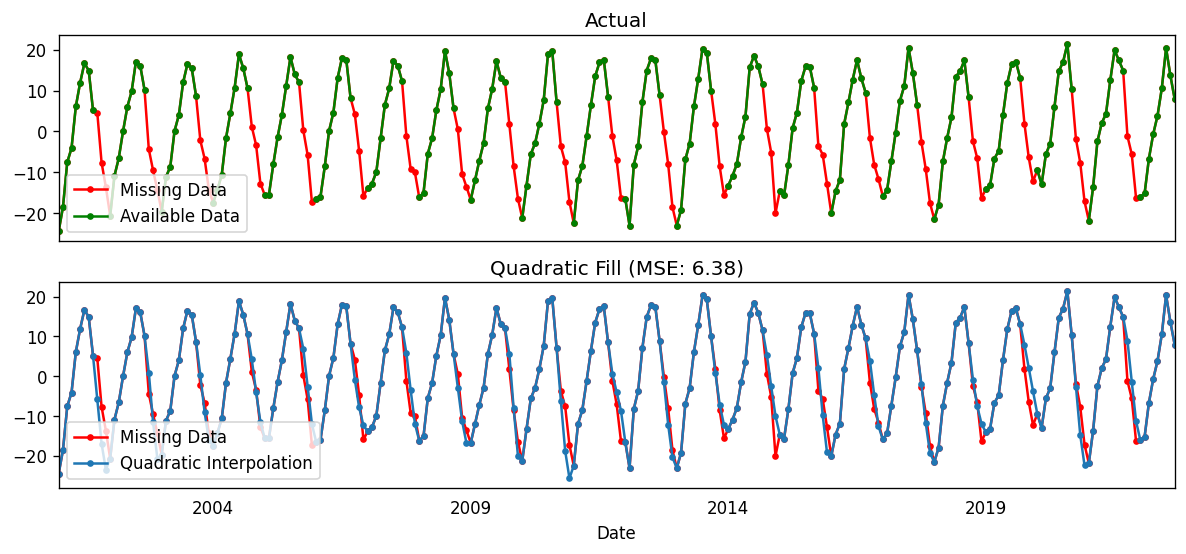

In [14]:
# Quadratic Interpolation
df_qfill = df_nan.copy()
df_nan['rownum']=np.arange(df_nan.shape[0]) #missing 개수 찾기 이것을 인덱스 넣어줌
df_nan_nona = df_nan.dropna(subset=['Lowest Temperature']) #Nan값 빠딘 데이터
f = interp1d(df_nan_nona['rownum'],df_nan_nona['Lowest Temperature'],kind= 'quadratic')
df_qfill['Lowest Temperature']= f(df_nan['rownum']) #인덱스를 받아오고 빠진곳에 채운다

# Calculate Error
error_qfill = np.round(mean_squared_error(df['Lowest Temperature'], df_qfill['Lowest Temperature']), 2)


# Plotting
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
plt.rcParams.update({'xtick.bottom' : False})

for ax in axes:
  df['Lowest Temperature'].plot(title='Actual', ax=ax, label='Actual', color='red', style=".-")

df_nan['Lowest Temperature'].plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")

df_qfill['Lowest Temperature'].plot(title="Quadratic Fill (MSE: " + str(error_qfill) +")",
                       label='Quadratic Fill', style=".-")



# Add legend
methods = ['Available Data',  'Quadratic Interpolation']
for ax, mt in zip(axes, methods):
  ax.legend(["Missing Data", mt])

In [15]:


import numpy as np
import pandas as pd

np.random.seed(0)

# NumPy Exercises!
Complete the solution code to have a desired output.

**[Caution!]** Not allow to use iteration, such as for-loop.





### 1-1. Create a 5×5 numpy array of all False boolean’s 
[ref] [np.full](https://numpy.org/doc/stable/reference/generated/numpy.full.html)

In [16]:
# Input
arr_size = (5, 5)

# Solution
bool_arr = np.full(arr_size, False, dtype=bool)

# Print
print(bool_arr)

[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]


### 1-2. Create a 7×7 diagonal matrix but item start 3 
[ref] [np.eye](https://numpy.org/devdocs/reference/generated/numpy.eye.html)

In [17]:
# Input
size = 7

# Solution
np_arr = np.eye(size, k=3)

# Print
print(np_arr)

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


### 2. Extract even odd numbers from given `arr`

In [18]:
# Input
arr = np.arange(35)

# Solution
arr = arr [arr % 2 == 0]

# Print
print(arr)

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34]


### 3. Get the positions where elements of `a` and `b` match
(hint, refer [np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html).)



In [19]:
# Input
a = np.array([1, 7, 3, 2, 3, 5, 3, 4, 5, 8, 2, 6, 9])
b = np.array([1, 2, 10, 8, 3, 4, 9, 4, 9, 8, 5, 3, 5])

# Solution
idx = np.where(a == b)

# Print
print(idx)

(array([0, 4, 7, 9]),)


### 4. Find the median, standard, average deviation of iris's `sepallength` (1st column).

In [20]:
# Input
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris = np.genfromtxt(url, delimiter=',', dtype='object')
sepallength = np.genfromtxt(url, delimiter=',', dtype='float', usecols=[0])

# Solution
med, std, avg = np.median(sepallength), np.std(sepallength), np.average(sepallength)

# Print
print(med, std, avg)

5.8 0.8253012917851409 5.843333333333334


### 5. Find the duplicate entries (2nd occurrence onwards) in the given numpy array and mark them as True. First time occurrences should be False.
(hint, refer [np.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html).)

In [21]:
# Input
np.random.seed(50)
a = np.random.randint(0, 10, 10)
print('Array: ', a)

# Solution
## Create an all True array
out = np.full(a.shape[0], True)

## Find the index positions of unique elements
unique_positions = np.unique(a, return_index=True)[1]

## Mark those positions as False
out[unique_positions] = False

print('Duplicate entrie: ', out)

Array:  [0 0 1 4 6 5 6 6 5 2]
Duplicate entrie:  [False  True False False False False  True  True  True False]


# Pandas Exercises!
Complete the solution code to have a desired output. 





### 6. Combine `ser1` and `ser2` to form a dataframe.

In [22]:
# Input
ser1 = pd.Series(list('abcedfghijklmnopqrstuvwxyz'))
ser2 = pd.Series(np.arange(26))

# Solution 
df = pd.DataFrame({'A' : ser1, 'B' : ser2})

# Print
print(df.tail())

    A   B
21  v  21
22  w  22
23  x  23
24  y  24
25  z  25


### 7. Check if `df` has any missing values.

In [23]:
# Input
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Cars93_miss.csv')
print(df.head())

# Solution
print('\nIs there any missing value?:', df.isnull().values.any())

  Manufacturer    Model     Type  Min.Price  Price  Max.Price  MPG.city  \
0        Acura  Integra    Small       12.9   15.9       18.8      25.0   
1          NaN   Legend  Midsize       29.2   33.9       38.7      18.0   
2         Audi       90  Compact       25.9   29.1       32.3      20.0   
3         Audi      100  Midsize        NaN   37.7       44.6      19.0   
4          BMW     535i  Midsize        NaN   30.0        NaN      22.0   

   MPG.highway             AirBags DriveTrain  ... Passengers  Length  \
0         31.0                None      Front  ...        5.0   177.0   
1         25.0  Driver & Passenger      Front  ...        5.0   195.0   
2         26.0         Driver only      Front  ...        5.0   180.0   
3         26.0  Driver & Passenger        NaN  ...        6.0   193.0   
4         30.0                 NaN       Rear  ...        4.0   186.0   

   Wheelbase  Width  Turn.circle Rear.seat.room  Luggage.room  Weight  \
0      102.0   68.0         37.0     

### 8. Create a TimeSeries starting `2022-09-01` and 7 weekends (mondays) after that **having** random numbers as values?

In [24]:
# Solution
ser = pd.Series(pd.date_range('2022-09-01', periods=7, freq='W-MON'))
print(ser)

0   2022-09-05
1   2022-09-12
2   2022-09-19
3   2022-09-26
4   2022-10-03
5   2022-10-10
6   2022-10-17
dtype: datetime64[ns]


### 9. In `df`, compute the median price of every fruit using grouping function.

In [25]:
# Input
df = pd.DataFrame({'fruit': ['apple', 'banana', 'orange', 'blueberry', 'melon'] * 5,
                   'rating': np.random.rand(25),
                   'price': np.random.randint(0, 20, 25)})

# Solution
df.groupby('fruit')['price'].median()

fruit
apple         9.0
banana       11.0
blueberry    11.0
melon         4.0
orange        6.0
Name: price, dtype: float64

### 10. Join two dataframes `df1` and `df2` for intersection items on `use_id`.
For `df2`, please select only `use_id`, `platform`, `device` columns not all columns for merging.

In [26]:
# Input
base_path = 'https://raw.githubusercontent.com/shanealynn/Pandas-Merge-Tutorial/master/'
df1 = pd.read_csv(base_path + 'user_usage.csv')
df2 = pd.read_csv(base_path + 'user_device.csv')

# Solution
pd.merge(df1, df2[['use_id', 'platform', 'device']], on='use_id').head()

outgoing_mins_per_month  outgoing_sms_per_month  monthly_mb  use_id  \
0                    21.97                    4.82     1557.33   22787   
1                  1710.08                  136.88     7267.55   22788   
2                  1710.08                  136.88     7267.55   22789   
3                    94.46                   35.17      519.12   22790   
4                    71.59                   79.26     1557.33   22792   

  platform    device  
0  android  GT-I9505  
1  android  SM-G930F  
2  android  SM-G930F  
3  android     D2303  
4  android  SM-G361F

## TODO! Analyze [Titanic](https://www.kaggle.com/c/titanic) Data
#### (until 21th Sep 2022)



### 0. Data load

In [27]:
import seaborn as sns

# Input
df = sns.load_dataset("titanic")

### 1. Show the first five samples of DataFrame 

In [28]:
df.head()

survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True

### 2. Print a concise summary of a DataFrame.
Column names, missing values for each column, and data type for each column.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


### 3. Generate descriptive statistics.

In [30]:
df.describe()

survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

### 4. Check the number of missing samples per each column

In [31]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

### 5. Return a Series containing counts of unique values on `class` column.

In [32]:
df['class'].value_counts(sort=False) # sort = False로 해야 First Second Third 순서로 정렬, 안할시 Third First Second 순서

First     216
Second    184
Third     491
Name: class, dtype: int64

### 6. Calculate the mean of `fare` according to `class` and `sex`
(hint, us `df.groupby`)

In [33]:
df.groupby(['class','sex'])['fare'].mean()

class   sex   
First   female    106.125798
        male       67.226127
Second  female     21.970121
        male       19.741782
Third   female     16.118810
        male       12.661633
Name: fare, dtype: float64

### 7. Do same thing by using `df.pivot_table`

In [34]:
df.pivot_table('fare', index=['class', 'sex'], aggfunc='mean')

fare
class  sex               
First  female  106.125798
       male     67.226127
Second female   21.970121
       male     19.741782
Third  female   16.118810
       male     12.661633

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind

# Cars93 data
In this lab, we would like to explore data about 93 number of vehicles.


In [36]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Cars93_miss.csv')
df

Manufacturer    Model     Type  Min.Price  Price  Max.Price  MPG.city  \
0         Acura  Integra    Small       12.9   15.9       18.8      25.0   
1           NaN   Legend  Midsize       29.2   33.9       38.7      18.0   
2          Audi       90  Compact       25.9   29.1       32.3      20.0   
3          Audi      100  Midsize        NaN   37.7       44.6      19.0   
4           BMW     535i  Midsize        NaN   30.0        NaN      22.0   
..          ...      ...      ...        ...    ...        ...       ...   
88   Volkswagen  Eurovan      Van       16.6   19.7       22.7      17.0   
89   Volkswagen   Passat  Compact       17.6   20.0       22.4      21.0   
90   Volkswagen  Corrado   Sporty       22.9   23.3       23.7      18.0   
91        Volvo      240  Compact       21.8   22.7       23.5      21.0   
92          NaN      850  Midsize       24.8   26.7       28.5      20.0   

    MPG.highway             AirBags DriveTrain  ... Passengers  Length  \
0          31.0                None      Front  ...        5.0   177.0   
1          25.0  Driver & Passenger      Front  ...        5.0   195.0   
2          26.0         Driver only      Front  ...        5.0   180.0   
3          26.0  Driver & Passenger        NaN  ...        6.0   193.0   
4          30.0                 NaN       Rear  ...        4.0   186.0   
..          ...                 ...        ...  ...        ...     ...   
88         21.0                None      Front  ...        7.0   187.0   
89         30.0                None      Front  ...        5.0   180.0   
90         25.0                None      Front  ...        4.0   159.0   
91         28.0         Driver only       Rear  ...        5.0   190.0   
92         28.0  Driver & Passenger      Front  ...        5.0   184.0   

    Wheelbase  Width  Turn.circle Rear.seat.room  Luggage.room  Weight  \
0       102.0   68.0         37.0           26.5           NaN  2705.0   
1       115.0   71.0         38.0           30.0          15.0  3560.0   
2       102.0   67.0         37.0           28.0          14.0  3375.0   
3       106.0    NaN         37.0           31.0          17.0  3405.0   
4       109.0   69.0         39.0           27.0          13.0  3640.0   
..        ...    ...          ...            ...           ...     ...   
88      115.0   72.0         38.0           34.0           NaN  3960.0   
89      103.0   67.0         35.0           31.5          14.0  2985.0   
90       97.0   66.0         36.0           26.0          15.0  2810.0   
91      104.0   67.0         37.0           29.5          14.0  2985.0   
92      105.0   69.0         38.0           30.0          15.0  3245.0   

     Origin                Make  
0   non-USA       Acura Integra  
1   non-USA        Acura Legend  
2   non-USA             Audi 90  
3   non-USA            Audi 100  
4   non-USA            BMW 535i  
..      ...                 ...  
88      NaN  Volkswagen Eurovan  
89  non-USA   Volkswagen Passat  
90  non-USA  Volkswagen Corrado  
91  non-USA           Volvo 240  
92  non-USA           Volvo 850  

[93 rows x 27 columns]

# Describe Statistics
Describe statistics of data using `describe()` method for numeric data (default mode.)



In [37]:
df.describe()

Min.Price      Price  Max.Price   MPG.city  MPG.highway  EngineSize  \
count  86.000000  91.000000  88.000000  84.000000    91.000000   91.000000   
mean   17.118605  19.616484  21.459091  22.404762    29.065934    2.658242   
std     8.828290   9.724280  10.696563   5.841520     5.370293    1.045845   
min     6.700000   7.400000   7.900000  15.000000    20.000000    1.000000   
25%    10.825000  12.350000  14.575000  18.000000    26.000000    1.800000   
50%    14.600000  17.700000  19.150000  21.000000    28.000000    2.300000   
75%    20.250000  23.500000  24.825000  25.000000    31.000000    3.250000   
max    45.400000  61.900000  80.000000  46.000000    50.000000    5.700000   

       Horsepower          RPM  Rev.per.mile  Fuel.tank.capacity  Passengers  \
count   86.000000    90.000000     87.000000           85.000000   91.000000   
mean   144.000000  5276.666667   2355.000000           16.683529    5.076923   
std     53.455204   605.554811    486.916616            3.375748    1.045953   
min     55.000000  3800.000000   1320.000000            9.200000    2.000000   
25%    100.750000  4800.000000   2017.500000           14.500000    4.000000   
50%    140.000000  5200.000000   2360.000000           16.500000    5.000000   
75%    170.000000  5787.500000   2565.000000           19.000000    6.000000   
max    300.000000  6500.000000   3755.000000           27.000000    8.000000   

           Length   Wheelbase      Width  Turn.circle  Rear.seat.room  \
count   89.000000   92.000000  87.000000    88.000000       89.000000   
mean   182.865169  103.956522  69.448276    38.954545       27.853933   
std     14.792651    6.856317   3.778023     3.304157        3.018129   
min    141.000000   90.000000  60.000000    32.000000       19.000000   
25%    174.000000   98.000000  67.000000    36.000000       26.000000   
50%    181.000000  103.000000  69.000000    39.000000       27.500000   
75%    192.000000  110.000000  72.000000    42.000000       30.000000   
max    219.000000  119.000000  78.000000    45.000000       36.000000   

       Luggage.room       Weight  
count     74.000000    86.000000  
mean      13.986486  3104.593023  
std        3.120824   600.129993  
min        6.000000  1695.000000  
25%       12.000000  2647.500000  
50%       14.000000  3085.000000  
75%       16.000000  3567.500000  
max       22.000000  4105.000000

For categorical data, specify `include` parametor as `'object'`. 
(hint, refer [`pd.describe`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html))

In [38]:
df.describe(include=object)

Manufacturer    Model     Type      AirBags DriveTrain Cylinders  \
count            89       92       90           87         86        88   
unique           31       92        6            3          3         6   
top            Ford  Integra  Midsize  Driver only      Front         4   
freq              8        1       22           39         61        45   

       Man.trans.avail Origin           Make  
count               88     88             90  
unique               2      2             90  
top                Yes    USA  Acura Integra  
freq                57     46              1

## Measuring skewness and kurtosis


First, make a numericColumns by selecting only columns containing numerical data

In [39]:
numericColumns = df.describe().columns
numericColumns

Index(['Min.Price', 'Price', 'Max.Price', 'MPG.city', 'MPG.highway',
       'EngineSize', 'Horsepower', 'RPM', 'Rev.per.mile', 'Fuel.tank.capacity',
       'Passengers', 'Length', 'Wheelbase', 'Width', 'Turn.circle',
       'Rear.seat.room', 'Luggage.room', 'Weight'],
      dtype='object')

Measure skewness for all numeric attribute and sort by value.

In [40]:
skewness = df[numericColumns].skew().sort_values(ascending=False)
skewness

Max.Price             2.248420
MPG.city              1.662674
Price                 1.510432
MPG.highway           1.238671
Min.Price             1.227271
Horsepower            0.944585
EngineSize            0.881670
Rev.per.mile          0.354385
Width                 0.288760
Luggage.room          0.149069
Wheelbase             0.108599
Fuel.tank.capacity    0.085445
Passengers            0.081776
Rear.seat.room        0.054352
Length               -0.036669
Turn.circle          -0.127313
RPM                  -0.237511
Weight               -0.269695
dtype: float64

Measure kurtosis for all numeric attribute and sort by value.

In [41]:
kurtosis = df[numericColumns].kurtosis().sort_values(ascending=False)
kurtosis

Max.Price             9.238289
MPG.city              3.617956
Price                 3.328289
MPG.highway           2.596793
Min.Price             1.107837
Horsepower            1.054818
Passengers            0.916041
Rear.seat.room        0.831153
Length                0.406525
EngineSize            0.377147
Rev.per.mile          0.331590
Luggage.room          0.322472
Fuel.tank.capacity    0.017060
Width                -0.201852
RPM                  -0.482837
Wheelbase            -0.821720
Weight               -0.828994
Turn.circle          -0.832044
dtype: float64

## Graphic visualization of skewness and kurtosis

Store the Attributes that skewness value is the largest, smallest and the closet to zero

(hint, df['???'])

In [42]:
highSkewAttribute = df[skewness.index[0]]
lowSkewAttribute = df[skewness.index[-1]]
zeroSkewAttribute = df['Length']

Draw plots. See how the distribution depends on the Skewness

You don't need to enter the code :-)

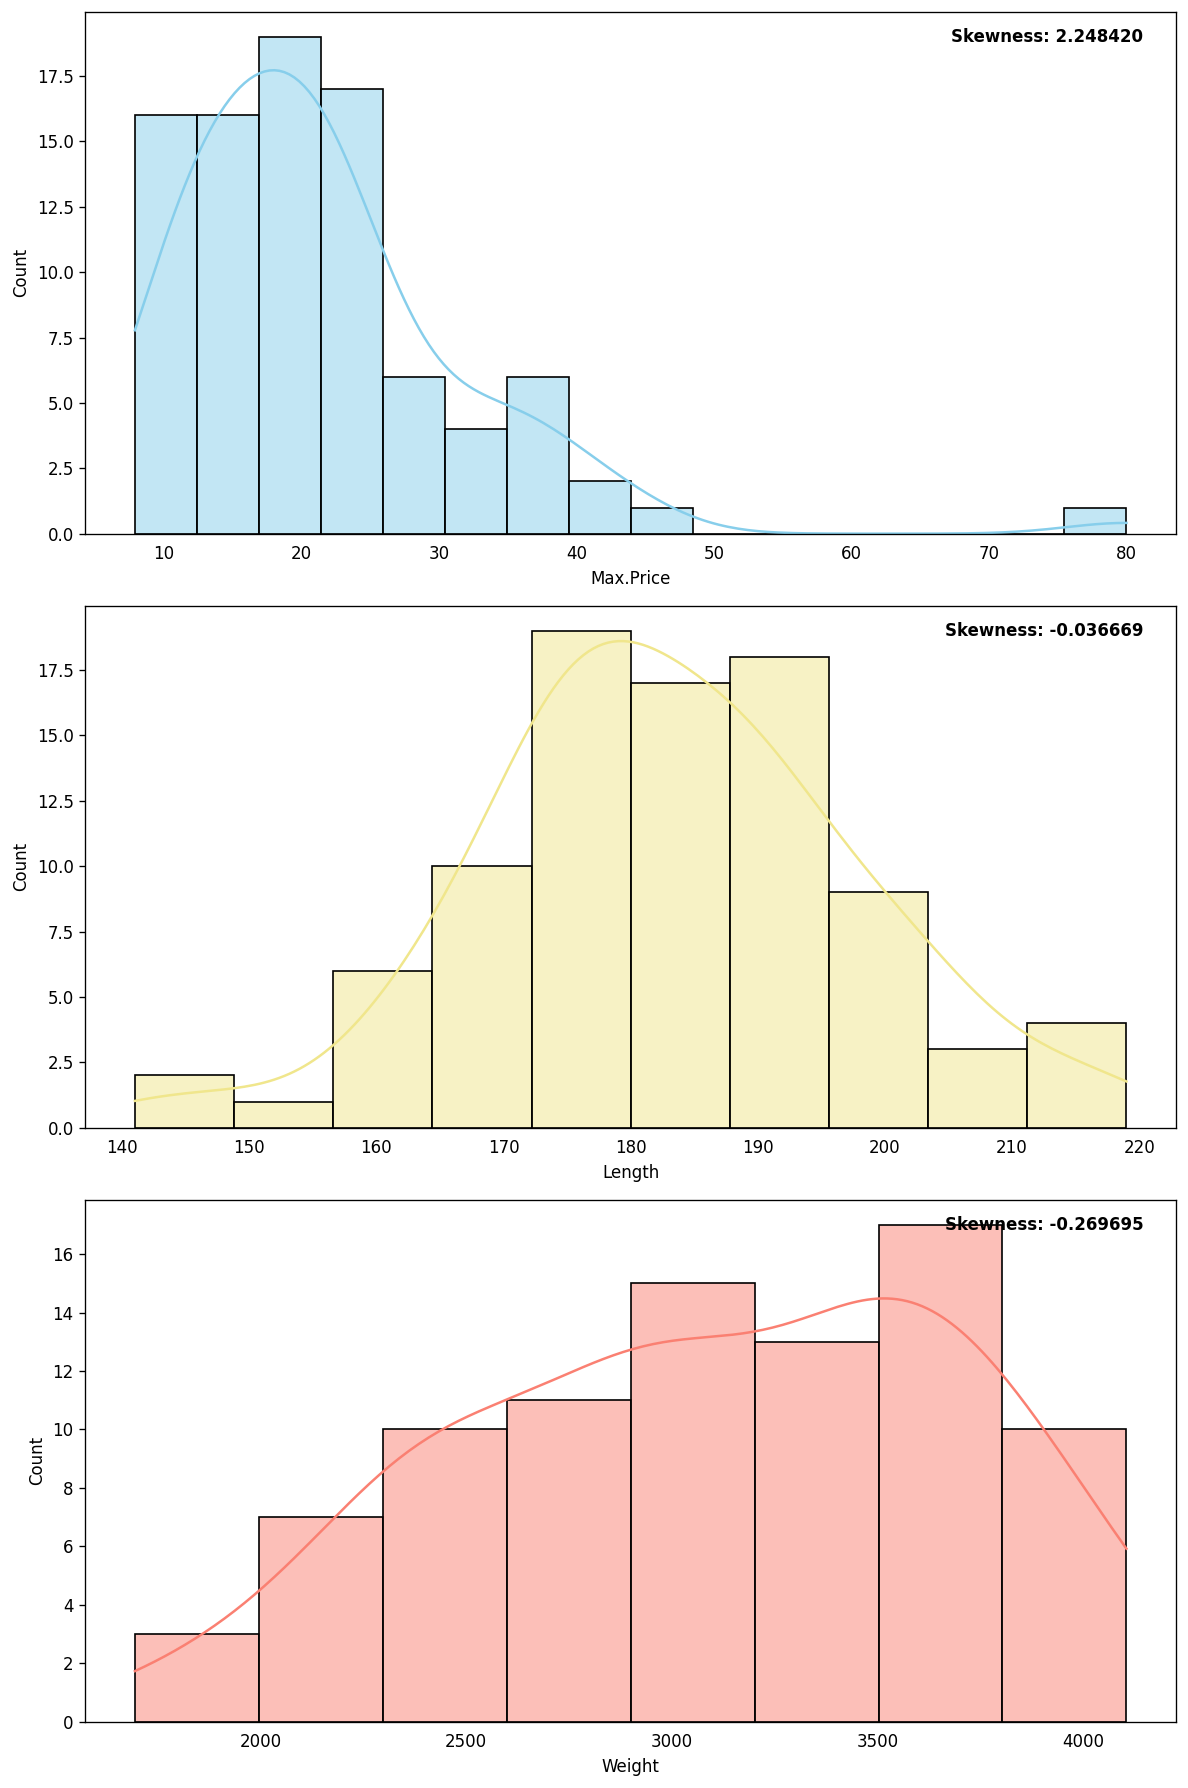

In [43]:
f, axes = plt.subplots(3, 1, figsize=(10, 15))

# set the string 
strInPlot = "Skewness: %f"

# Plot distplot (highSkew)
ax = axes[0]
sns.histplot(data=df, x=highSkewAttribute, color="skyblue", ax=ax, kde=True)

# Add legend 
ax.text(x=0.97, y=0.97, transform=ax.transAxes, s=strInPlot % highSkewAttribute.skew(),\
    fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right')

# Plot distplot (zeroSkew)
ax = axes[1]
sns.histplot(data=df, x=zeroSkewAttribute, color="khaki", ax=ax, kde=True)

# Add legend 
ax.text(x=0.97, y=0.97, transform=ax.transAxes, s=strInPlot % zeroSkewAttribute.skew(),\
    fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right')

# Plot distplot (lowSkew)
ax = axes[2]
sns.histplot(data=df, x=lowSkewAttribute, color="salmon", ax=ax, kde=True)

# Add legend 
ax.text(x=0.97, y=0.97, transform=ax.transAxes, s=strInPlot % lowSkewAttribute.skew(),\
    fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()

Store the Attributes that kurtosis value is the largest and smallest

(hint, df['???'])

In [44]:
highKurtAttribute = df[kurtosis.index[0]]
lowKurtAttribute = df[kurtosis.index[-1]]

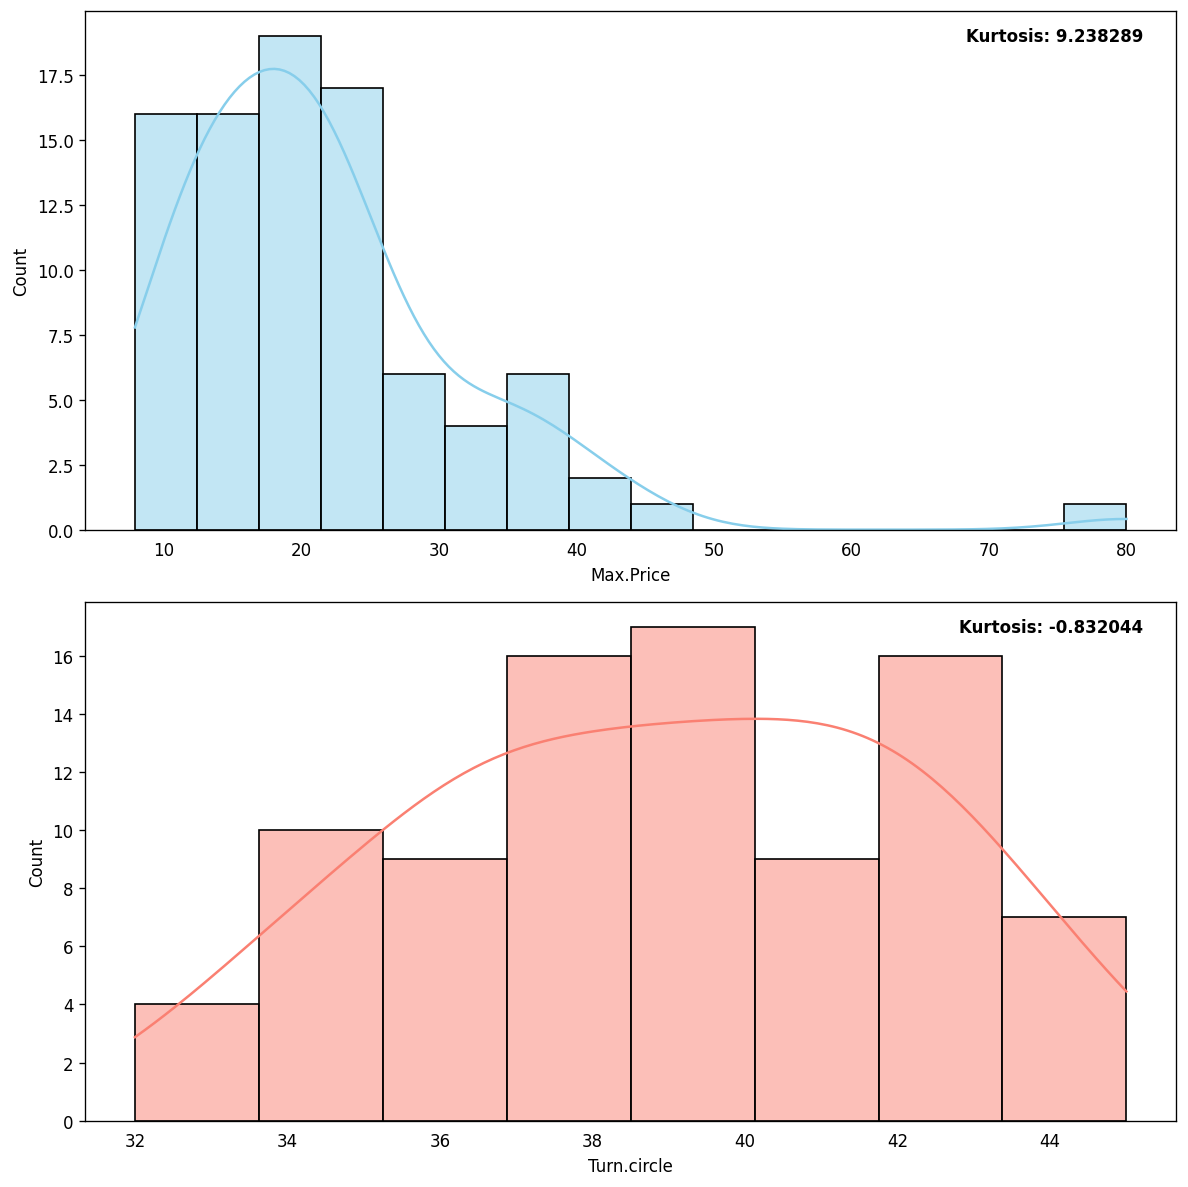

In [45]:
f, axes = plt.subplots(2, 1, figsize=(10, 10))

# set the string 
strInPlot = "Kurtosis: %f"

# Plot distplot (highKurtosis)
ax = axes[0]
sns.histplot(data=df, x=highKurtAttribute, color="skyblue", ax=ax, kde=True)

# Add legend 
ax.text(x=0.97, y=0.97, transform=ax.transAxes, s=strInPlot % highKurtAttribute.kurtosis(),\
    fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right')

# Plot distplot (lowKurtosis)
ax = axes[1]
sns.histplot(data=df, x=lowKurtAttribute, color="salmon", ax=ax, kde=True)

# Add legend 
ax.text(x=0.97, y=0.97, transform=ax.transAxes, s=strInPlot % lowKurtAttribute.kurtosis(),\
    fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()

# Correlation
**[TODO]** Select `Price`, `Horsepower`, `Passengers`, `Length`, `Weight` attribte from dataframe, and compute `pearson` correlation value.

In [46]:
## Compelete the code
selectedDataFrame =  df[['Price', 'Horsepower', 'Passengers', 'Length', 'Weight']]
selectedDataFrame.corr(method='pearson')

Price  Horsepower  Passengers    Length    Weight
Price       1.000000    0.794607    0.040890  0.564704  0.642563
Horsepower  0.794607    1.000000   -0.039870  0.552906  0.777764
Passengers  0.040890   -0.039870    1.000000  0.473748  0.577401
Length      0.564704    0.552906    0.473748  1.000000  0.813305
Weight      0.642563    0.777764    0.577401  0.813305  1.000000

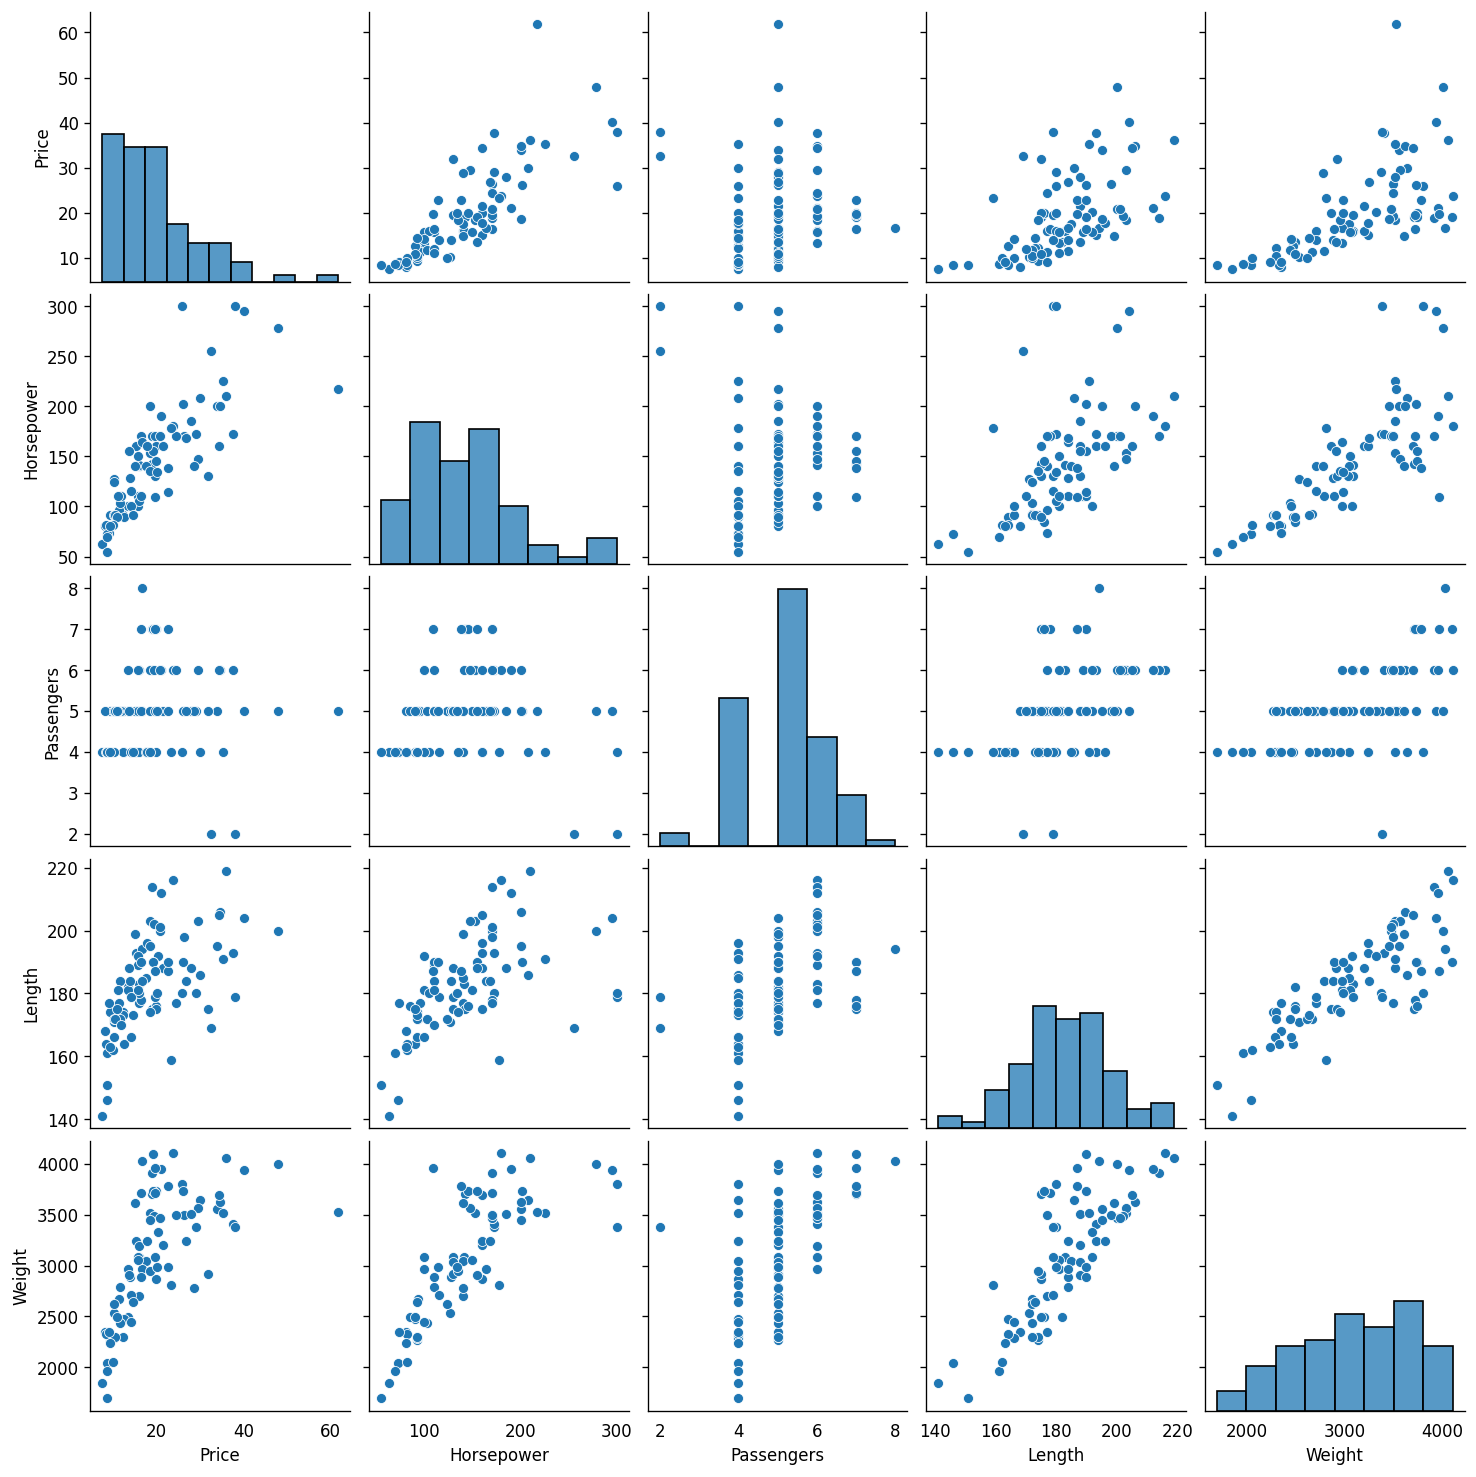

In [47]:
g = sns.pairplot(selectedDataFrame)
plt.show()

# Statistical Hypothesis Test
We would like the test that is there a significant `Passengers` difference between `small` and `midsize` type car.

Test our hypothesis with proper statistical test with siginificance level as 0.05.

If there is missing value (`nan`) in `pd.Series`, test will not be working properly. 

In [48]:
siginificantLevel = 0.05
smallCar = df[df['Type']=='Small']['Passengers'].dropna()
midsizeCar = df[df['Type']=='Midsize']['Passengers'].dropna()

stats, p =  ttest_ind(smallCar, midsizeCar)
print('P-value', format(p, ".19f"))

if p < siginificantLevel:
  print("The passengers of the two types shows a significant difference.")
else:
  print("The passengers of the two types shows no significant difference.")

P-value 0.0042894346544763359
The passengers of the two types shows a significant difference.


Then, let's test that is there is a significant `Length` difference between `top 50% weight` and `bottom 50% weight`.

In [49]:
significiantLevel = 0.05

standard = df['Weight'].quantile(.5)

lightCarLength = df[df['Weight']<standard]['Length'].dropna()
heavyCarLength = df[df['Weight']>=standard]['Length'].dropna()

stats, p = ttest_ind(lightCarLength, heavyCarLength)
print('P-value', format(p, ".19f"))

if p < siginificantLevel:
  print("The Length shows a significant difference.")
else:
  print("The Length shows no significant difference.")

P-value 0.0000000000123944090
The Length shows a significant difference.


# Todo!

**[Tip]** 

1.   과제 중 진행이 어려우시다면 구글링을 시도해보세요. 데이터 분석 프로그래밍은 구글링 하는 능력을 향상시키는 데 목적을 두기도 합니다.

2.   그래도 너무 어렵다면 이루리에 질문을 남겨주세요, 저희가 친절하게 답변해드립니다. (조금 늦을수는 있지만…)

3.   할 수 있습니다 화이팅!

---

## 1. 라면 데이터 준비하기



이번 실습에서는 한국에서 판매하는 라면에 대해 간단히 분석해볼 것입니다.

우선 데이터를 제가 준비해두었습니다!

아래의 표를 한번 확인해보세요.



In [50]:
df = pd.read_excel('https://github.com/TA-YSH/DAP/raw/main/lab3/FoodListExcel.xlsx')
df

sample_id    name_product name_manufacturer  survey_year class  \
0    P064392ZZAVG      NEW 공화춘곱빼기                팔도         2021  가공식품   
1    P064393ZZAVG      NEW 공화춘자장컵                팔도         2021  가공식품   
2    P064394ZZAVG  강릉 교동반점 직화짬뽕소컵                팔도         2021  가공식품   
3    P064395ZZAVG         꼬꼬누룽지탕면                팔도         2021  가공식품   
4    P064396ZZAVG      뉴트리 클로렐라컵면                팔도         2021  가공식품   
..            ...             ...               ...          ...   ...   
616  P014688ZZAVG         컵누들 우동맛               오뚜기         2017  가공식품   
617  P014702ZZAVG          튀김우동 컵                농심         2017  가공식품   
618  P014714ZZAVG             하모니                농심         2017  가공식품   
619  P014726ZZAVG          후루룩 국수                농심         2017  가공식품   
620  P014727ZZAVG         후루룩 칼국수                농심         2017  가공식품   

    class_recipe     code     source_data  serving_size    kcal  kj  protein  \
0            유탕면  P064392        식약처('21)           230  745.00 NaN    14.00   
1            유탕면  P064393        식약처('21)           200  620.00 NaN    11.00   
2            유탕면  P064394        식약처('21)            65  290.00 NaN     6.00   
3            유탕면  P064395        식약처('21)           120  505.00 NaN     9.00   
4            유탕면  P064396        식약처('21)            65  300.00 NaN     6.00   
..           ...      ...             ...           ...     ...  ..      ...   
616          유탕면  P014688  식약처 산업체제공('17)            38  119.69 NaN     1.99   
617          유탕면  P014702  식약처 산업체제공('17)            80  325.16 NaN     4.13   
618          유탕면  P014714  식약처 산업체제공('17)           120  498.25 NaN     7.74   
619          유탕면  P014726  식약처 산업체제공('17)           120  544.42 NaN    15.31   
620           건면  P014727  식약처 산업체제공('17)           120  505.05 NaN    12.24   

       fat  carbohydrate  sugars   sodium  cholesterol  saturated_fat  \
0    36.00         91.00    7.00  1230.00         10.0          15.00   
1    31.00         74.00    7.00  1130.00         10.0          12.00   
2    12.00         39.00    3.00  1040.00          5.0           6.00   
3    13.00         88.00    4.00  1670.00          2.0           6.00   
4    12.00         41.00    1.00   940.00          8.0           6.00   
..     ...           ...     ...      ...          ...            ...   
616   0.50         26.93    2.99   887.66          0.0           0.00   
617  15.48         42.32    2.88  1238.70          0.0           5.16   
618  19.35         73.53    1.31   870.73          0.0           8.71   
619   1.19        117.39    3.01  2909.20          0.0           0.00   
620   0.92        111.72    8.82  2356.89          0.0           0.00   

     saturated_fat_per  trans_fat  
0                  NaN        0.0  
1                  NaN        0.0  
2                  NaN        0.0  
3                  NaN        0.0  
4                  NaN        0.0  
..                 ...        ...  
616                NaN        0.0  
617                NaN        0.0  
618                NaN        0.0  
619                NaN        0.0  
620                NaN        0.0  

[621 rows x 20 columns]

## 2. 필요없는 열 드랍하기



분석에 필요 없는 속성값은 모두 제거하는 것이 좋을 것입니다.

그 때 제일 유용한 도구는 바로 ‘drop’이라는 함수입니다.

`df.drop()`을 이용하면 원하는 columns를 제거할 수 있습니다.

제가 필요 없는 속성으로 보이는 것들을 dropColumns라는 리스트 안에 넣어두었습니다.

df에서 해당 속성들을 모두 제거해주세요.

만약 진행이 어렵다면 아래의 레퍼런스를 참조해주세요. 

pandas.DataFrame.drop: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

In [51]:
dropColumns = ['sample_id', 'survey_year', 'code', 'source_data']
# Complete the code!
df.drop(columns=dropColumns, inplace=True) #drop 된 것들이 아래에서도 계속 유지되어야함.
df

name_product name_manufacturer class class_recipe  serving_size  \
0        NEW 공화춘곱빼기                팔도  가공식품          유탕면           230   
1        NEW 공화춘자장컵                팔도  가공식품          유탕면           200   
2    강릉 교동반점 직화짬뽕소컵                팔도  가공식품          유탕면            65   
3           꼬꼬누룽지탕면                팔도  가공식품          유탕면           120   
4        뉴트리 클로렐라컵면                팔도  가공식품          유탕면            65   
..              ...               ...   ...          ...           ...   
616         컵누들 우동맛               오뚜기  가공식품          유탕면            38   
617          튀김우동 컵                농심  가공식품          유탕면            80   
618             하모니                농심  가공식품          유탕면           120   
619          후루룩 국수                농심  가공식품          유탕면           120   
620         후루룩 칼국수                농심  가공식품           건면           120   

       kcal  kj  protein    fat  carbohydrate  sugars   sodium  cholesterol  \
0    745.00 NaN    14.00  36.00         91.00    7.00  1230.00         10.0   
1    620.00 NaN    11.00  31.00         74.00    7.00  1130.00         10.0   
2    290.00 NaN     6.00  12.00         39.00    3.00  1040.00          5.0   
3    505.00 NaN     9.00  13.00         88.00    4.00  1670.00          2.0   
4    300.00 NaN     6.00  12.00         41.00    1.00   940.00          8.0   
..      ...  ..      ...    ...           ...     ...      ...          ...   
616  119.69 NaN     1.99   0.50         26.93    2.99   887.66          0.0   
617  325.16 NaN     4.13  15.48         42.32    2.88  1238.70          0.0   
618  498.25 NaN     7.74  19.35         73.53    1.31   870.73          0.0   
619  544.42 NaN    15.31   1.19        117.39    3.01  2909.20          0.0   
620  505.05 NaN    12.24   0.92        111.72    8.82  2356.89          0.0   

     saturated_fat  saturated_fat_per  trans_fat  
0            15.00                NaN        0.0  
1            12.00                NaN        0.0  
2             6.00                NaN        0.0  
3             6.00                NaN        0.0  
4             6.00                NaN        0.0  
..             ...                ...        ...  
616           0.00                NaN        0.0  
617           5.16                NaN        0.0  
618           8.71                NaN        0.0  
619           0.00                NaN        0.0  
620           0.00                NaN        0.0  

[621 rows x 16 columns]

### 2-2. NaN 값이 많은 속성 제거하기

이제 NaN 값이 너무 많아서 오히려 방해가 될 것 같은 속성을 지워봅시다.

사실 이런 NaN 값을 적당한 값으로 채워넣어주는 방법 또한 분명히 존재합니다.

하지만 해당 내용은 추후에 배우게 될 것이므로 이번 실습에서는 제거하는 방향으로 처리합시다.


우선, NaN 데이터가 각 속성마다 몇 개 있는지 pd.Series 형식으로 출력해주세요.

저번 실습에서 한 번 해보셨기 때문에 쉽게 하실 수 있을 것입니다!

In [52]:
nullSeries = df.isnull().sum()
nullSeries

name_product           0
name_manufacturer      0
class                  0
class_recipe           0
serving_size           0
kcal                   0
kj                   621
protein                0
fat                    0
carbohydrate           0
sugars                 0
sodium                 0
cholesterol           10
saturated_fat          2
saturated_fat_per    621
trans_fat              1
dtype: int64

다음 조건에 따라 코드를 작성하세요

**[조건]**
1. `’nullList’`란 전체 데이터의 절반 이상이 NaN인 속성의 이름을 저장한 리스트입니다.
2. `’nullList’`의 원소를 코드로 직접 선언하지 마세요.(ex: null_list = [‘kj’, ‘saturated_fat_per’])
3. 방금 만들었던 `’nullSeries’`를 반드시 사용하세요.

**[힌트]**
1. 이 코드는 한줄로 작성이 가능합니다. 하지만 여러 줄로 작성하셔도 무방합니다.
2. `’nullSeries’`는 list처럼 각 원소에 접근 가능합니다. (ex: null_series[0])


In [53]:
#조건 위배시 조건당 -1
nullList = nullSeries[nullSeries==621].index #조건 위배하지 않았으면 모두 정답 인정, 621 숫자 그냥 사용해도 인정(조건 위배 아님)
nullList # Index형태로 출력해도 정답 인정

Index(['kj', 'saturated_fat_per'], dtype='object')

`drop()` 함수를 이용해서 `nullList`에 저장된 속성들을 df에서 제거해주세요.

In [54]:
df.drop(columns=nullList,inplace=True) #drop 된 것이 아래에서 계속 사용이 가능해야함
df

name_product name_manufacturer class class_recipe  serving_size  \
0        NEW 공화춘곱빼기                팔도  가공식품          유탕면           230   
1        NEW 공화춘자장컵                팔도  가공식품          유탕면           200   
2    강릉 교동반점 직화짬뽕소컵                팔도  가공식품          유탕면            65   
3           꼬꼬누룽지탕면                팔도  가공식품          유탕면           120   
4        뉴트리 클로렐라컵면                팔도  가공식품          유탕면            65   
..              ...               ...   ...          ...           ...   
616         컵누들 우동맛               오뚜기  가공식품          유탕면            38   
617          튀김우동 컵                농심  가공식품          유탕면            80   
618             하모니                농심  가공식품          유탕면           120   
619          후루룩 국수                농심  가공식품          유탕면           120   
620         후루룩 칼국수                농심  가공식품           건면           120   

       kcal  protein    fat  carbohydrate  sugars   sodium  cholesterol  \
0    745.00    14.00  36.00         91.00    7.00  1230.00         10.0   
1    620.00    11.00  31.00         74.00    7.00  1130.00         10.0   
2    290.00     6.00  12.00         39.00    3.00  1040.00          5.0   
3    505.00     9.00  13.00         88.00    4.00  1670.00          2.0   
4    300.00     6.00  12.00         41.00    1.00   940.00          8.0   
..      ...      ...    ...           ...     ...      ...          ...   
616  119.69     1.99   0.50         26.93    2.99   887.66          0.0   
617  325.16     4.13  15.48         42.32    2.88  1238.70          0.0   
618  498.25     7.74  19.35         73.53    1.31   870.73          0.0   
619  544.42    15.31   1.19        117.39    3.01  2909.20          0.0   
620  505.05    12.24   0.92        111.72    8.82  2356.89          0.0   

     saturated_fat  trans_fat  
0            15.00        0.0  
1            12.00        0.0  
2             6.00        0.0  
3             6.00        0.0  
4             6.00        0.0  
..             ...        ...  
616           0.00        0.0  
617           5.16        0.0  
618           8.71        0.0  
619           0.00        0.0  
620           0.00        0.0  

[621 rows x 14 columns]

## 3. 최솟값, 최댓값 그리고 사분위수

아래의 df의 대략적인 내용을 `describe()` 함수를 이용해서 출력해주세요. 그리고 출력값의 `min`, `25%`, `50%`, `75%`, `max` columns와 df2의 kcal 속성을 주목하세요.

In [55]:
df.describe()

serving_size        kcal     protein         fat  carbohydrate  \
count    621.000000  621.000000  621.000000  621.000000    621.000000   
mean     108.958132  439.725894    8.729662   15.035781     67.157407   
std       31.667601  106.782258    2.520399    5.692365     16.776216   
min       20.000000   13.630000    0.000000    0.000000      3.400000   
25%       92.000000  380.000000    7.000000   12.000000     57.000000   
50%      110.000000  470.000000    9.000000   16.000000     70.000000   
75%      120.000000  500.000000   10.000000   18.000000     77.000000   
max      253.000000  745.000000   20.000000   36.000000    117.390000   

           sugars       sodium  cholesterol  saturated_fat   trans_fat  
count  621.000000   621.000000   611.000000     619.000000  620.000000  
mean     5.523800  1370.753559     3.323273       7.054443    0.014677  
std      3.629177   420.397811     6.393039       2.824633    0.322291  
min      0.000000     0.000000     0.000000       0.000000    0.000000  
25%      3.000000  1080.000000     0.000000       6.000000    0.000000  
50%      4.610000  1450.000000     0.000000       8.000000    0.000000  
75%      7.000000  1690.000000     5.000000       9.000000    0.000000  
max     24.000000  3035.500000    67.000000      15.000000    8.000000

다음 조건에 따라 df2를 완성하세요.

**[조건]**
1. `df2`는 `df`에 속한 라면들 중, ‘kcal’이 최솟값, 일사분위수, 이사분위수, 삼사분위수, 최댓값과 일치하는 라면을 저장한 데이터프레임입니다. 
2. `df.describe()`를 선언하거나 사용하지 마세요.
3. 최솟값, 최댓값, 사분위수들을 직접 선언하지 마세요. (ex: list = [13.63, 380, 470, 500, 745])


In [56]:
##enter your code####
kcalList = [
    df['kcal'].quantile(0), #min 사용해도 인정
    df['kcal'].quantile(0.25),
    df['kcal'].quantile(0.5),
    df['kcal'].quantile(0.75),
    df['kcal'].quantile(1) #max 사용해도 인정
    
]
#코드의 목적을 달성했으면 정렬되어 있지 않아도 정답 인정
#조건 위배시 조건당 -1점
df2 = df[df['kcal'].isin(kcalList)]
df2

name_product name_manufacturer class class_recipe  serving_size    kcal  \
0     NEW 공화춘곱빼기                팔도  가공식품          유탕면           230  745.00   
14     일품해물라면 왕컵                팔도  가공식품          유탕면           110  470.00   
19      팔도 김치왕뚜껑                팔도  가공식품          유탕면           110  470.00   
23      팔도탄탄면 왕컵                팔도  가공식품          유탕면           116  500.00   
28         김치사발면                농심  가공식품          유탕면            86  380.00   
..           ...               ...   ...          ...           ...     ...   
592      옛날 자른당면               오뚜기  가공식품           건면            20   13.63   
593        열떡볶이면               오뚜기  가공식품          유탕면           140  470.00   
594       진라면 용기               오뚜기  가공식품          유탕면           110  500.00   
605      진라면 매운맛               오뚜기  가공식품          유탕면           120  500.00   
606      진라면 순한맛               오뚜기  가공식품          유탕면           120  500.00   

     protein   fat  carbohydrate  sugars   sodium  cholesterol  saturated_fat  \
0       14.0  36.0          91.0    7.00  1230.00         10.0           15.0   
14      11.0  15.0          73.0    4.00  1620.00          9.0            7.0   
19       8.0  17.0          71.0    4.00  1790.00          0.0            9.0   
23      11.0  22.0          65.0    4.00  1700.00          2.0           10.0   
28       7.0  14.0          56.0    5.00  1520.00          0.0            7.0   
..       ...   ...           ...     ...      ...          ...            ...   
592      0.0   0.0           3.4    0.01     0.12          0.0            0.0   
593      9.0  10.0          86.0   13.00   800.00          0.0            4.9   
594     10.0  18.0          47.0    6.00  1540.00          0.0           10.0   
605     11.0  15.0          80.0    4.60  1860.00          0.0            8.0   
606     12.0  15.0          79.0    4.00  1880.00          0.0            8.0   

     trans_fat  
0          0.0  
14         0.0  
19         0.0  
23         0.0  
28         0.0  
..         ...  
592        0.0  
593        0.0  
594        0.0  
605        0.0  
606        0.0  

[73 rows x 14 columns]

## 4. 관계성 분석하기


df에 대해 **`kcal`**, **`protein`**, **`fat`**, **`carbohydrate`** 의 관계성을 파악해보세요.

method는 pearson을 사용해주세요.

In [57]:
dfNutri = df[['kcal','protein','fat','carbohydrate']]

dfNutri.corr(method='pearson') #pearson으로 method 설정해줘야함.

kcal   protein       fat  carbohydrate
kcal          1.000000  0.816188  0.777269      0.870106
protein       0.816188  1.000000  0.513249      0.757226
fat           0.777269  0.513249  1.000000      0.396166
carbohydrate  0.870106  0.757226  0.396166      1.000000

아래의 그래프 출력 코드는 따로 입력하지 않으셔도 괜찮습니다.

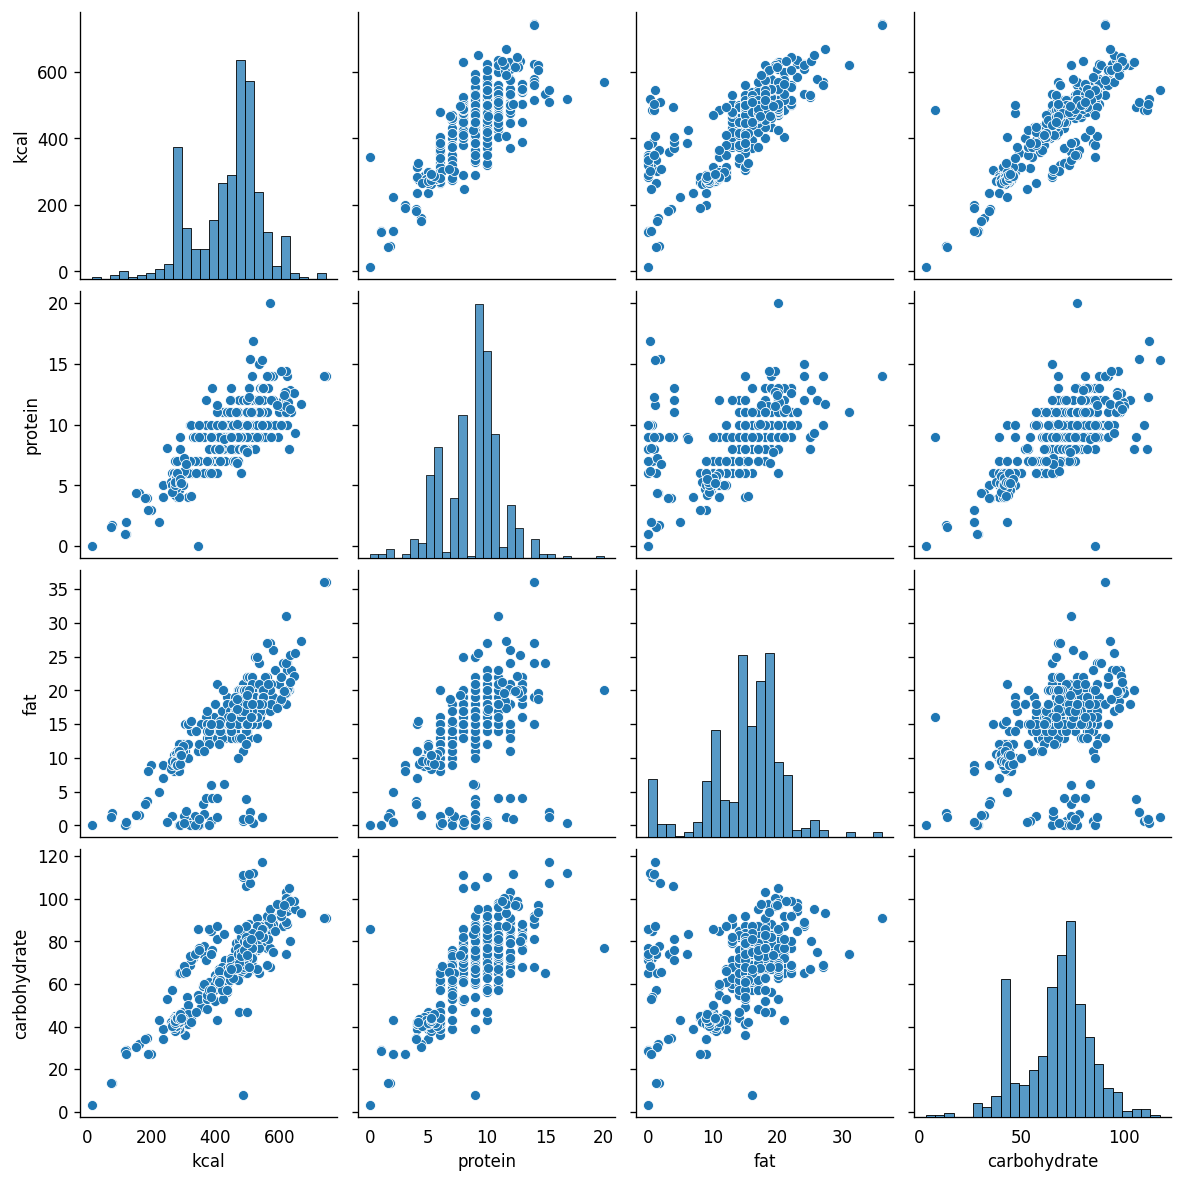

In [58]:
g = sns.pairplot(dfNutri)
plt.show()

## 5. T-TEST

가설을 세우고 검증해봅시다!

이번 실습에서 세울 가설은 바로, **`‘특정 제조사의 소듐 함량은 데이터 전체 라면에 대한 소듐 함량의 평균보다 많은 편일 것이다.’`** 입니다.

적절한 가설 검증법을 사용해서 특정 제조사의 소듐 함량이 전체 라면들의 소듐 함량 **평균치**보다 많을지 확인해보세요.

**[힌트]**
  
1. `totalSodiumMean` 에는 전체 라면에 대한 소듐 함량의 평균이 들어갑니다.
2. 어떤 가설 검증법이 제일 적절할지 수업자료를 참조해서 파악해보세요. (심지어 구현 방법까지 다 나와 있습니다.)
3. **어떤 가설 검증법을 사용해야할지 알 것 같다면, 해당 검증법의 api 문서에서 추가로 필요한 arguments가 없는지 파악하세요.**

In [59]:
from scipy.stats import ttest_1samp
for manu in df['name_manufacturer'].unique():
  yourManuSodium = df[df['name_manufacturer']==manu]['sodium']
  siginificantLevel = 0.05

  totalSodiumMean = df['sodium'].mean()

  #######enter your code######
  _,p = ttest_1samp(yourManuSodium, totalSodiumMean, alternative='greater') # 수정된 버전 이후 alternative 'greater'이여야 함
  print("P-valule", p)
 
 # 경고창 떠있어도 괜찮음
 # 수정 전 문제일 경우, 비슷하면 정답 인정
  if p < siginificantLevel:
     print(f'sodium of {manu} is significant greater than all the ramens')
  else:
    print(f'sodium of {manu} is not significant greater than all the ramens')

P-valule 0.0007049430141221484
sodium of 팔도 is significant greater than all the ramens
P-valule 0.8284706946331513
sodium of 농심 is not significant greater than all the ramens
P-valule 0.8761935419228963
sodium of 오뚜기 is not significant greater than all the ramens
P-valule nan
sodium of 롯데 is not significant greater than all the ramens


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Cars93 data
In this lab, we would like to explore data about 93 number of vehicles.

In [61]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Cars93_miss.csv')
df.head()

Manufacturer    Model     Type  Min.Price  Price  Max.Price  MPG.city  \
0        Acura  Integra    Small       12.9   15.9       18.8      25.0   
1          NaN   Legend  Midsize       29.2   33.9       38.7      18.0   
2         Audi       90  Compact       25.9   29.1       32.3      20.0   
3         Audi      100  Midsize        NaN   37.7       44.6      19.0   
4          BMW     535i  Midsize        NaN   30.0        NaN      22.0   

   MPG.highway             AirBags DriveTrain  ... Passengers  Length  \
0         31.0                None      Front  ...        5.0   177.0   
1         25.0  Driver & Passenger      Front  ...        5.0   195.0   
2         26.0         Driver only      Front  ...        5.0   180.0   
3         26.0  Driver & Passenger        NaN  ...        6.0   193.0   
4         30.0                 NaN       Rear  ...        4.0   186.0   

   Wheelbase  Width  Turn.circle Rear.seat.room  Luggage.room  Weight  \
0      102.0   68.0         37.0           26.5           NaN  2705.0   
1      115.0   71.0         38.0           30.0          15.0  3560.0   
2      102.0   67.0         37.0           28.0          14.0  3375.0   
3      106.0    NaN         37.0           31.0          17.0  3405.0   
4      109.0   69.0         39.0           27.0          13.0  3640.0   

    Origin           Make  
0  non-USA  Acura Integra  
1  non-USA   Acura Legend  
2  non-USA        Audi 90  
3  non-USA       Audi 100  
4  non-USA       BMW 535i  

[5 rows x 27 columns]

## Matplotlib
Please refer the [official doc](https://matplotlib.org/) or following [article](https://www.machinelearningplus.com/plots/matplotlib-tutorial-complete-guide-python-plot-examples/) for further detailed tricks.

### Line-plot
Draw a line-plot for the age-specific height averages for men and women

- Men are represented in blue and women in red
- Use x_label() and y_label(), title(), and legend() to draw
- Use xticks() to separate the intervals on the x-axis graph

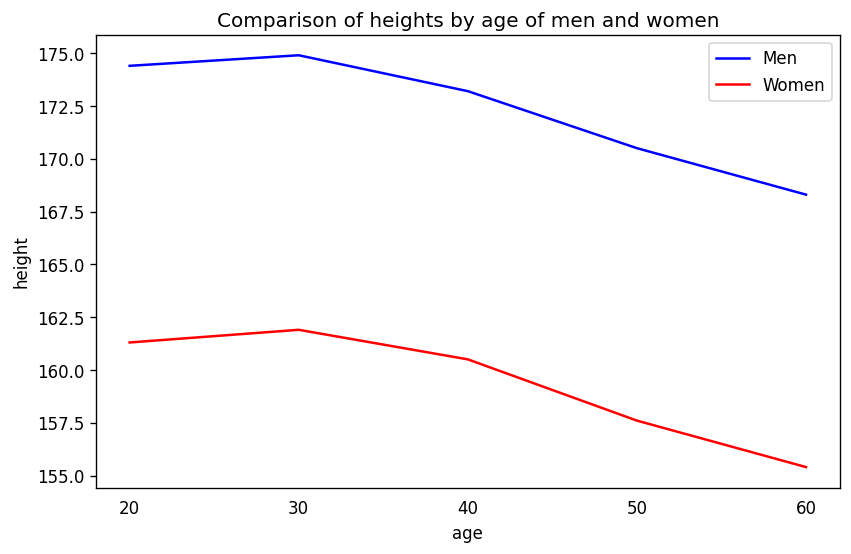

In [62]:
# Male Data
x = [20,30,40,50,60]
y = [174.4, 174.9, 173.2, 170.5, 168.3]

plt.plot(x, y, label='Men' ,color='blue')

# Female Data
x = [20,30,40,50,60]
y = [161.3, 161.9, 160.5, 157.6, 155.4]

plt.plot(x, y, label='Women' ,color='red')

# Sepsarate x 
plt.xticks(np.arange(20,70,10))

# Draw
plt.xlabel("age")
plt.ylabel("height")
plt.title("Comparison of heights by age of men and women")
plt.legend()

plt.show()

###Histogram Plot with Barplot
Draw the horsepower mean by type

- df_sample should contain only `Type` and `Horsepower` properties
- Drop the `NAN` value

Returns all the number of times for each value in the `Type` 


In [63]:
df['Type'].value_counts()

Midsize    22
Small      20
Compact    16
Sporty     12
Large      11
Van         9
Name: Type, dtype: int64

Use barh() to draw the histogram by `Type`


Text(0, 0.5, 'Type')

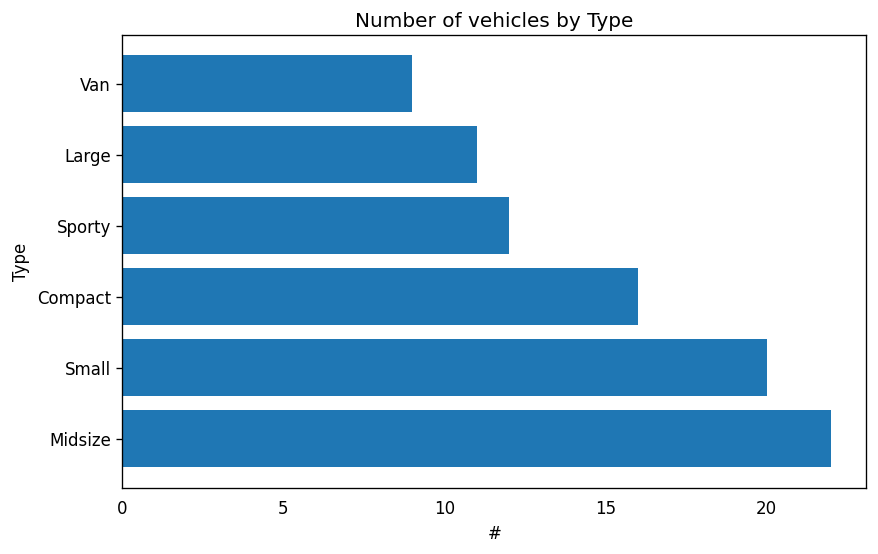

In [64]:
# Draw plot
plt.barh(df['Type'].value_counts().index,
         df['Type'].value_counts().values)
plt.title('Number of vehicles by Type')
plt.xlabel('#')
plt.ylabel('Type')

### Pie Plot

Draw *pie chart* of `Type` (hint, refer pandas'  [`.value_counts`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html) method and the [article](https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f) about *pie chart*).
Please give the `startangle` option to 30

- Use `autopct` to represent decimal places

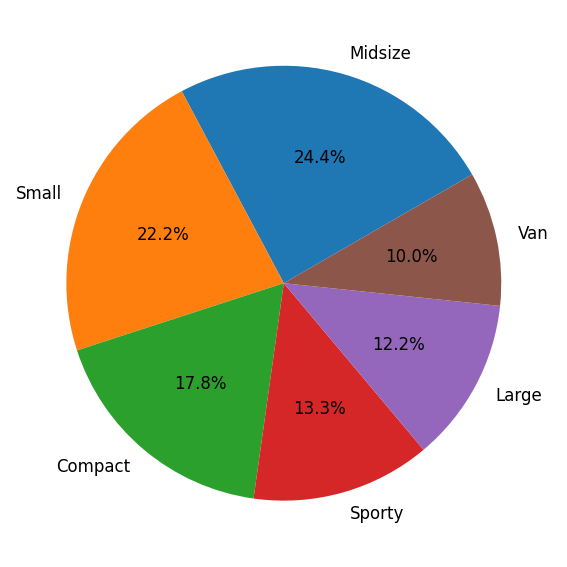

In [65]:
typeCount = df['Type'].value_counts(normalize=True)
# typeCount
fig, ax = plt.subplots(figsize=(6,6))

# Draw!!
ax.pie(
      typeCount,
      labels = typeCount.index,
      autopct='%1.1f%%',
      startangle = 30
    )


plt.show()

## Seaborn
Please refer the [official doc](https://seaborn.pydata.org/).

### Boxplot
Plot *boxplot* which comparing the `Price` according to `Manufacturer`. The plot must satisify following conditions.
 * nested grouping within additional categorical variable, `Origin`
 * using `Blues` color palette


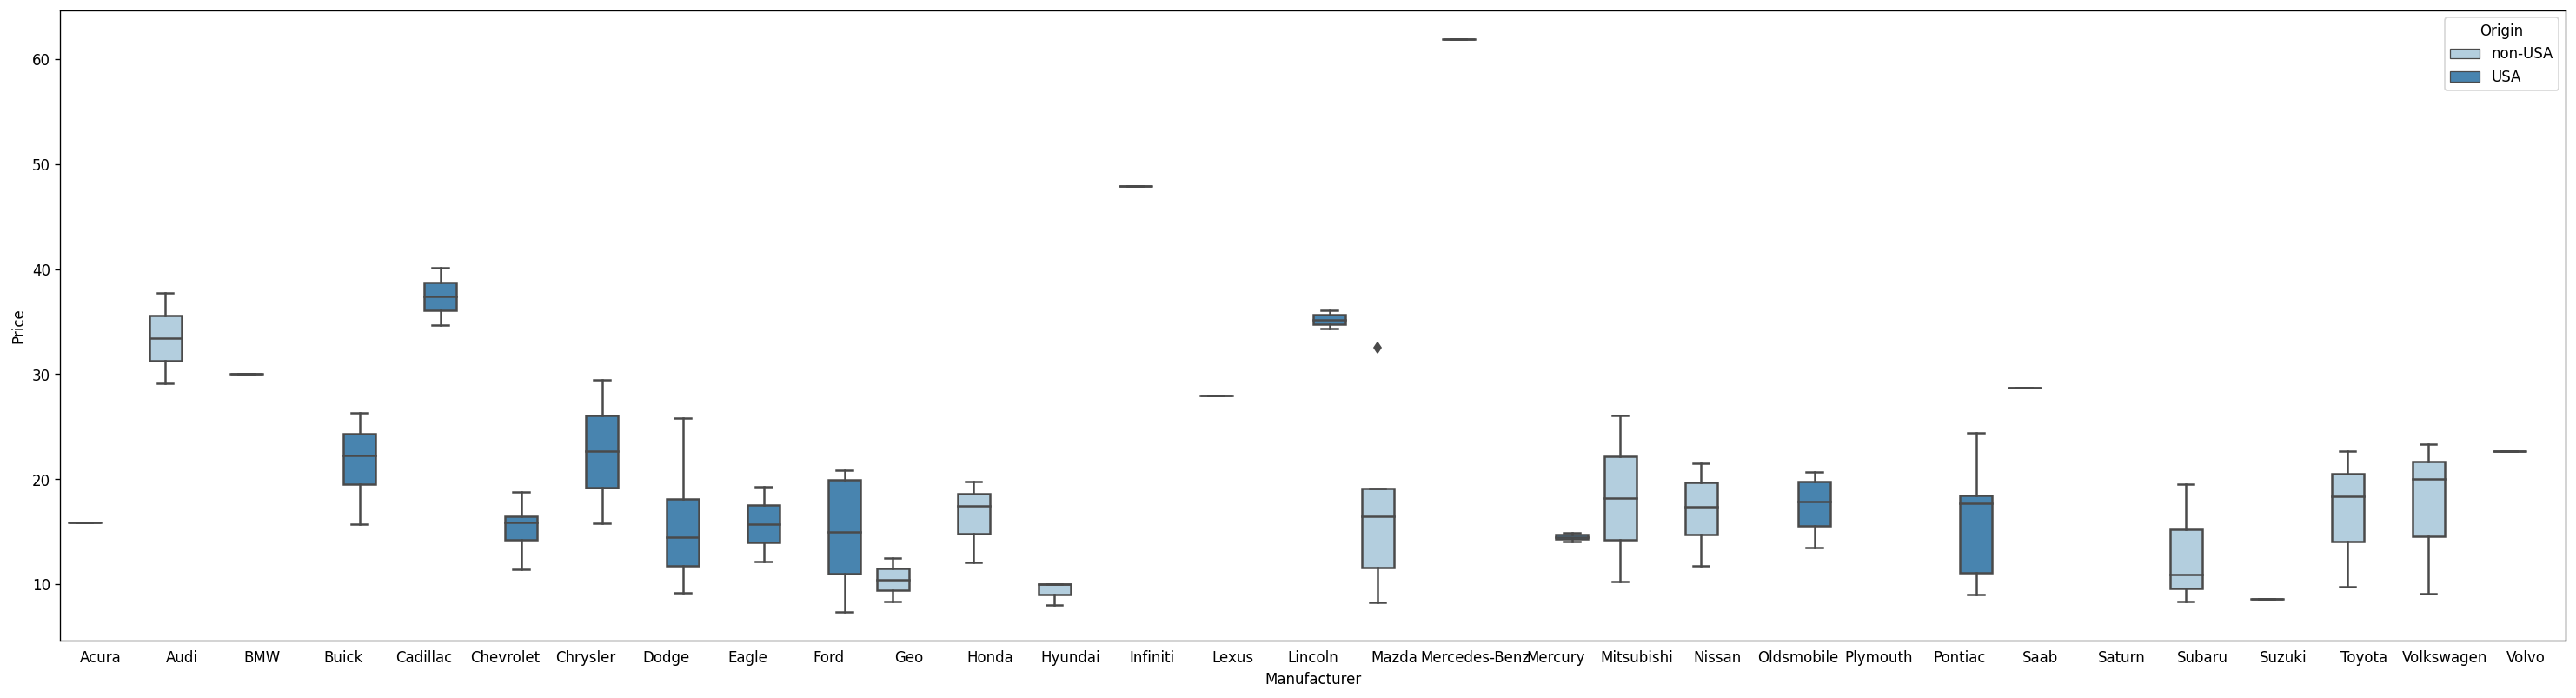

In [66]:
fig, ax = plt.subplots(figsize=(31,8))
sns.boxplot(
    data=df, x= 'Manufacturer', y= 'Price',
    hue='Origin', palette="Blues")
plt.show()

### Heatmap and Pairplot
This part brought the correlation problem that was dealt with in the previous practice problem. Please refer `lecture3.ipynb`

- Select `Price`,`Horsepower`, `Passengers`, `Length`, `Weight`
- Put this in the `df`
- Use the `pearson` method to obtain the correlation value


In [67]:
#원하는 열만 구해서
targetVar = ['Price', 'Horsepower', 'Passengers','Length', 'Weight']  
selectedDataFrame = df[targetVar]
corr = selectedDataFrame.corr(method='pearson')
corr

Price  Horsepower  Passengers    Length    Weight
Price       1.000000    0.794607    0.040890  0.564704  0.642563
Horsepower  0.794607    1.000000   -0.039870  0.552906  0.777764
Passengers  0.040890   -0.039870    1.000000  0.473748  0.577401
Length      0.564704    0.552906    0.473748  1.000000  0.813305
Weight      0.642563    0.777764    0.577401  0.813305  1.000000

Make *heatmap*!
- Make it the `4th` decimal place
- Set the color to `bone_r`

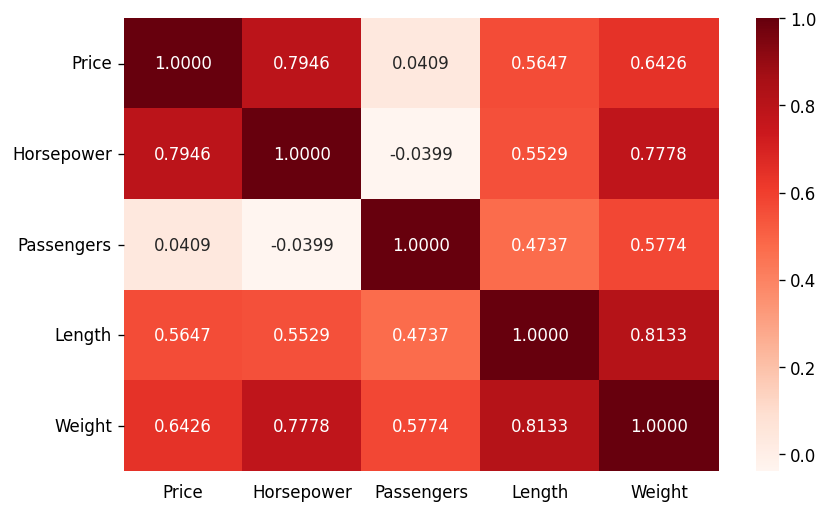

In [68]:
ax = sns.heatmap(corr, annot=True, fmt=".4f",cmap="Reds")

Plot *pair plot*. The plot must satisify following conditions.

- Create a pair plot using the `targetvar` value above 
- Put the corr value in the pair plot in `text format`!

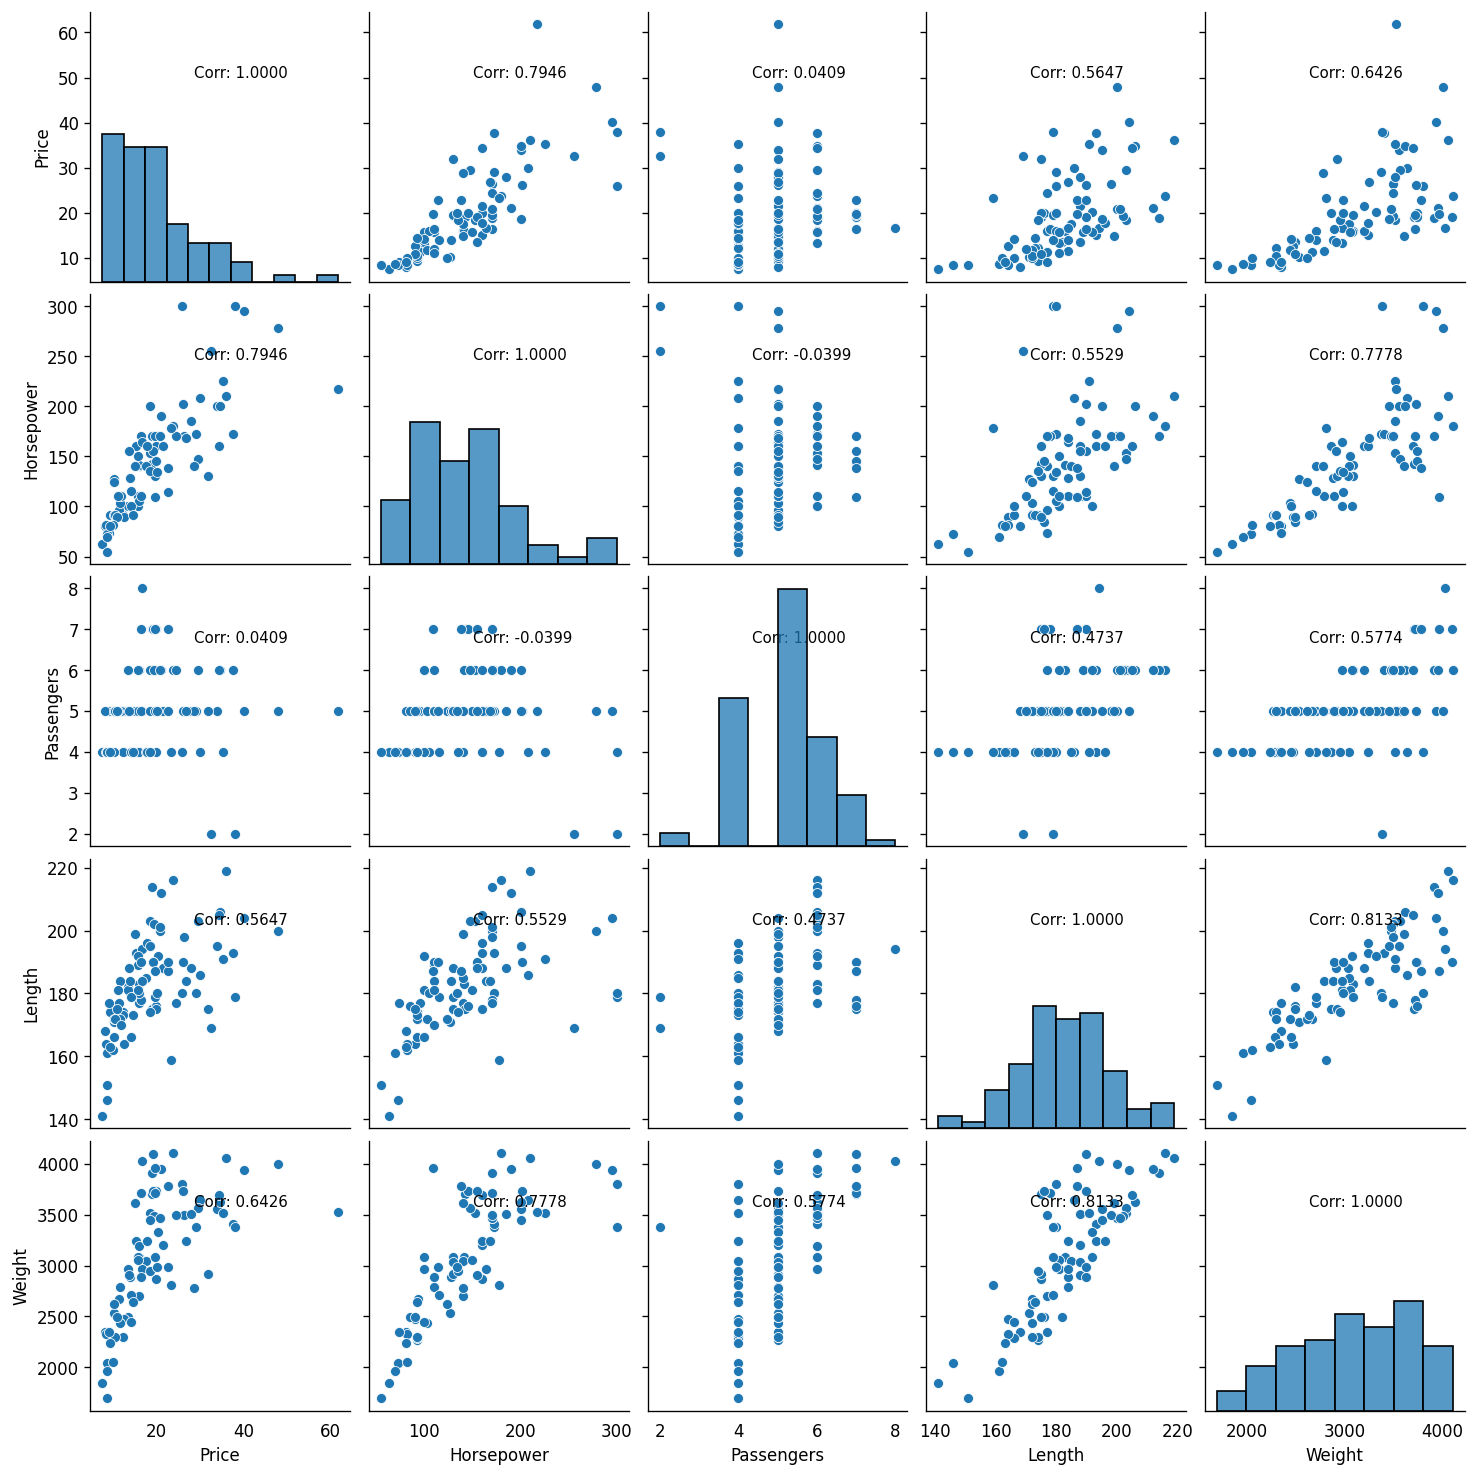

In [69]:
#g에 원하는 대상열만 넣어둿음 위에 참고
g = sns.pairplot(selectedDataFrame)
#0.4와 0.8 이건 Corr의 위치임!
corrValue = corr.to_numpy()
for i, (ax, cv) in enumerate(zip(g.axes.flat, corrValue.flatten())):
    ax.text(0.4, 0.8, f"Corr: {cv:.4f}", fontsize=9,
            horizontalalignment="left", verticalalignment="top",
            transform=ax.transAxes)

plt.show()

## Plotly

### Density contour plot
Plot *density contour plot* and deploy the dashboard.
* The *density contour plot* should show relationship between `Price` and user choosen variable among `MPG.city`, `MPG.highway`, `Rev.per.mile`.

(please refer [official doc](https://plotly.com/python/2d-histogram-contour/) about *density contour plot*)


In [70]:
# install packages
!pip install dash
!pip install jupyter_dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 7.3 MB/s 
     |████████████████████████████████| 357 kB 66.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 11.5 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=0ab942c32bd8fdd246e1c42f36197df2eaa975f0e5970959a2cd16e4e68ef33d
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [71]:
import dash
from dash import html
import plotly.graph_objects as go
from dash import dcc
import plotly.express as px
from dash.dependencies import Input, Output

from jupyter_dash import JupyterDash

# Load Dash App
app = JupyterDash()

# Define App
app.layout = html.Div(id = 'parent',
                      children = [html.H1(id = 'H1', children = 'Cas93 Dashboard',
                                          style = {'textAlign':'center',\
                                                   'marginTop':40,
                                                   'marginBottom':40}),
                                  dcc.Dropdown(id = 'dropdown',
                                               options=[{'label' : 'city','value' : 'MPG.city'},
                                                        {'label' : 'highway','value' : 'MPG.highway'},
                                                        {'label' : 'per.mile','value' : 'Rev.per.mile'},],
                                               value = 'MPG.city'),
                                  dcc.Graph(id = 'plot')
                                  ])

# Define callback decorator and it's function    
@app.callback(Output(component_id='plot', component_property= 'figure'),
              [Input(component_id='dropdown', component_property= 'value')])
def graph_update(dropdown_value):
    print(dropdown_value)
    fig = px.density_contour(df,x="Price",y=dropdown_value,
                             marginal_x="histogram",
                             marginal_y="histogram")

    return fig  

if __name__ == '__main__': 
    app.run_server(host='localhost', port=1050)

Dash app running on:


<IPython.core.display.Javascript object>

#TODO
이번에 할 데이터는 `NBA선수 데이터`와 `로또 데이터` 입니다! 

출발~~~!!!

## NBA data
아래에 보이는 데이터는 NBA선수 데이터 입니다!

선수들의 소속팀, 이름, 키, 몸무게, 시즌, 출신대학교 등등이있습니다.

In [72]:
df_players = pd.read_csv('https://raw.githubusercontent.com/wonseok-hong/DAP_TA/main/all_seasons.csv')
df_players

Unnamed: 0        player_name team_abbreviation   age  player_height  \
0               0      Dennis Rodman               CHI  36.0         198.12   
1               1  Dwayne Schintzius               LAC  28.0         215.90   
2               2       Earl Cureton               TOR  39.0         205.74   
3               3        Ed O'Bannon               DAL  24.0         203.20   
4               4        Ed Pinckney               MIA  34.0         205.74   
...           ...                ...               ...   ...            ...   
12300       12300    Markieff Morris               MIA  32.0         205.74   
12301       12301     Markelle Fultz               ORL  24.0         193.04   
12302       12302       Marcus Smart               BOS  28.0         193.04   
12303       12303     Marcus Garrett               MIA  23.0         195.58   
12304       12304       Micah Potter               DET  24.0         208.28   

       player_weight                      college country draft_year  \
0          99.790240  Southeastern Oklahoma State     USA       1986   
1         117.933920                      Florida     USA       1990   
2          95.254320                Detroit Mercy     USA       1979   
3         100.697424                         UCLA     USA       1995   
4         108.862080                    Villanova     USA       1985   
...              ...                          ...     ...        ...   
12300     111.130040                       Kansas     USA       2011   
12301      94.800728                   Washington     USA       2017   
12302      99.790240               Oklahoma State     USA       2014   
12303      92.986360                       Kansas     USA  Undrafted   
12304     112.490816                    Wisconsin     USA  Undrafted   

      draft_round  ...   pts   reb  ast  net_rating  oreb_pct  dreb_pct  \
0               2  ...   5.7  16.1  3.1        16.1     0.186     0.323   
1               1  ...   2.3   1.5  0.3        12.3     0.078     0.151   
2               3  ...   0.8   1.0  0.4        -2.1     0.105     0.102   
3               1  ...   3.7   2.3  0.6        -8.7     0.060     0.149   
4               1  ...   2.4   2.4  0.2       -11.2     0.109     0.179   
...           ...  ...   ...   ...  ...         ...       ...       ...   
12300           1  ...   7.6   2.6  1.4         4.5     0.059     0.089   
12301           1  ...  10.8   2.7  5.5        -5.3     0.010     0.116   
12302           1  ...  12.1   3.8  5.9         9.3     0.018     0.093   
12303   Undrafted  ...   1.1   1.9  0.6         5.8     0.072     0.108   
12304   Undrafted  ...   4.0   3.0  0.0       -56.4     0.095     0.125   

       usg_pct  ts_pct  ast_pct   season  
0        0.100   0.479    0.113  1996-97  
1        0.175   0.430    0.048  1996-97  
2        0.103   0.376    0.148  1996-97  
3        0.167   0.399    0.077  1996-97  
4        0.127   0.611    0.040  1996-97  
...        ...     ...      ...      ...  
12300    0.197   0.547    0.116  2021-22  
12301    0.265   0.517    0.448  2021-22  
12302    0.179   0.540    0.245  2021-22  
12303    0.086   0.280    0.069  2021-22  
12304    0.148   0.505    0.000  2021-22  

[12305 rows x 22 columns]

### 1. scatter plot을 이용하여 선수들의 키와 몸무게 비교

색깔은 `#e377c2`색을 넣어주시면 됩니다. 마커는 `x`표시로 해주세요! 마커 투명도는 0.5로 주시면됩니다!

레이블과 타이틀또한 정답과 동일하게 해주세요!

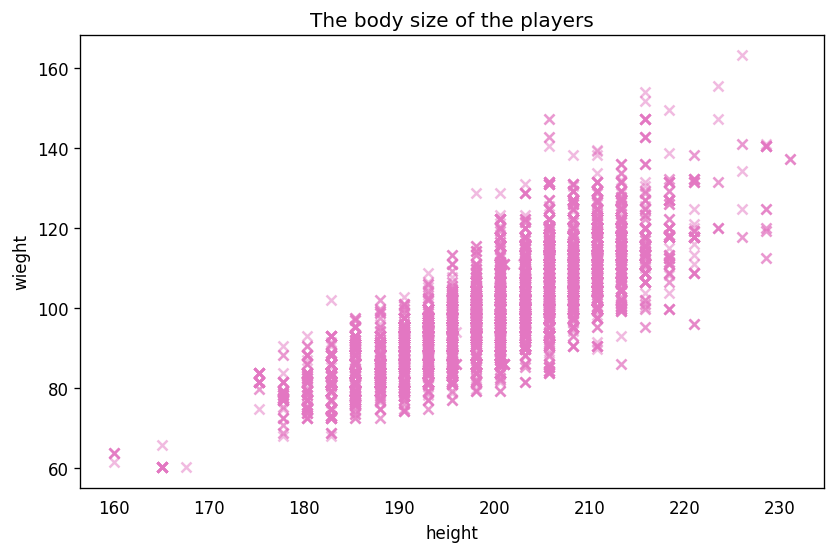

In [73]:
x = [df_players['player_height']]
y = [df_players['player_weight']]

plt.scatter(x, y, c='#e377c2', marker='x', alpha = 0.5)
plt.xlabel("height")
plt.ylabel("wieght")
plt.title("The body size of the players")


plt.show()

### 2. plotly사용해보기!

plotly를 이용하여 선수들의 키와 몸무게(`player_height`와 `player_weight`)를 비교하고 마우스로 댔을때 player_name나오게 해주세요.  

또한 `pts`별 색깔도 적용해주세요!

In [74]:
fig = px.scatter(df_players, x="player_height", y="player_weight",hover_data=['player_name'],color='pts')
fig.show()

### 3. 데이터 전처리

여기서서는 `Stephen Curry`선수의 데이터를 Curry_data에 저장해주세요!

In [75]:
Curry_data = df_players[df_players['player_name']=='Stephen Curry']
Curry_data

Unnamed: 0    player_name team_abbreviation   age  player_height  \
5926         5926  Stephen Curry               GSW  22.0         190.50   
6361         6361  Stephen Curry               GSW  23.0         190.50   
6999         6999  Stephen Curry               GSW  24.0         190.50   
7173         7173  Stephen Curry               GSW  25.0         190.50   
7838         7838  Stephen Curry               GSW  26.0         190.50   
8292         8292  Stephen Curry               GSW  27.0         190.50   
8739         8739  Stephen Curry               GSW  28.0         190.50   
9182         9182  Stephen Curry               GSW  29.0         190.50   
9877         9877  Stephen Curry               GSW  30.0         190.50   
10141       10141  Stephen Curry               GSW  31.0         190.50   
10869       10869  Stephen Curry               GSW  32.0         190.50   
11335       11335  Stephen Curry               GSW  33.0         190.50   
12024       12024  Stephen Curry               GSW  34.0         187.96   

       player_weight   college country draft_year draft_round  ...   pts  reb  \
5926        83.91452  Davidson     USA       2009           1  ...  17.5  4.5   
6361        83.91452  Davidson     USA       2009           1  ...  18.6  3.9   
6999        83.91452  Davidson     USA       2009           1  ...  14.7  3.4   
7173        83.91452  Davidson     USA       2009           1  ...  22.9  4.0   
7838        83.91452  Davidson     USA       2009           1  ...  24.0  4.3   
8292        86.18248  Davidson     USA       2009           1  ...  23.8  4.3   
8739        86.18248  Davidson     USA       2009           1  ...  30.1  5.4   
9182        86.18248  Davidson     USA       2009           1  ...  25.3  4.5   
9877        86.18248  Davidson     USA       2009           1  ...  26.4  5.1   
10141       86.18248  Davidson     USA       2009           1  ...  27.3  5.3   
10869       83.91452  Davidson     USA       2009           1  ...  20.8  5.2   
11335       83.91452  Davidson     USA       2009           1  ...  32.0  5.5   
12024       83.91452  Davidson     USA       2009           1  ...  25.5  5.2   

       ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct   season  
5926   5.9        -3.1     0.018     0.118    0.218   0.568    0.241  2009-10  
6361   5.8        -0.6     0.023     0.109    0.242   0.595    0.268  2010-11  
6999   5.3         5.4     0.023     0.111    0.235   0.605    0.295  2011-12  
7173   6.9         2.4     0.022     0.092    0.261   0.589    0.298  2012-13  
7838   8.5         9.4     0.018     0.108    0.281   0.610    0.372  2013-14  
8292   7.7        17.0     0.024     0.113    0.283   0.638    0.358  2014-15  
8739   6.7        18.3     0.029     0.131    0.320   0.669    0.315  2015-16  
9182   6.6        17.2     0.027     0.113    0.292   0.624    0.287  2016-17  
9877   6.1        13.0     0.024     0.124    0.290   0.675    0.272  2017-18  
10141  5.2        13.7     0.020     0.122    0.292   0.641    0.225  2018-19  
10869  6.6       -15.3     0.023     0.162    0.286   0.557    0.355  2019-20  
11335  5.8         4.6     0.013     0.135    0.331   0.655    0.283  2020-21  
12024  6.3        10.7     0.015     0.126    0.293   0.601    0.286  2021-22  

[13 rows x 22 columns]

### 4. LinePlot그려보기

`lineplot`을 이용하여 Stephen Curry선수의 시즌별 `pts`, `reb`, `ast`값 비교해보세요! 

아래그림처럼 plot을 그리면됩니다!

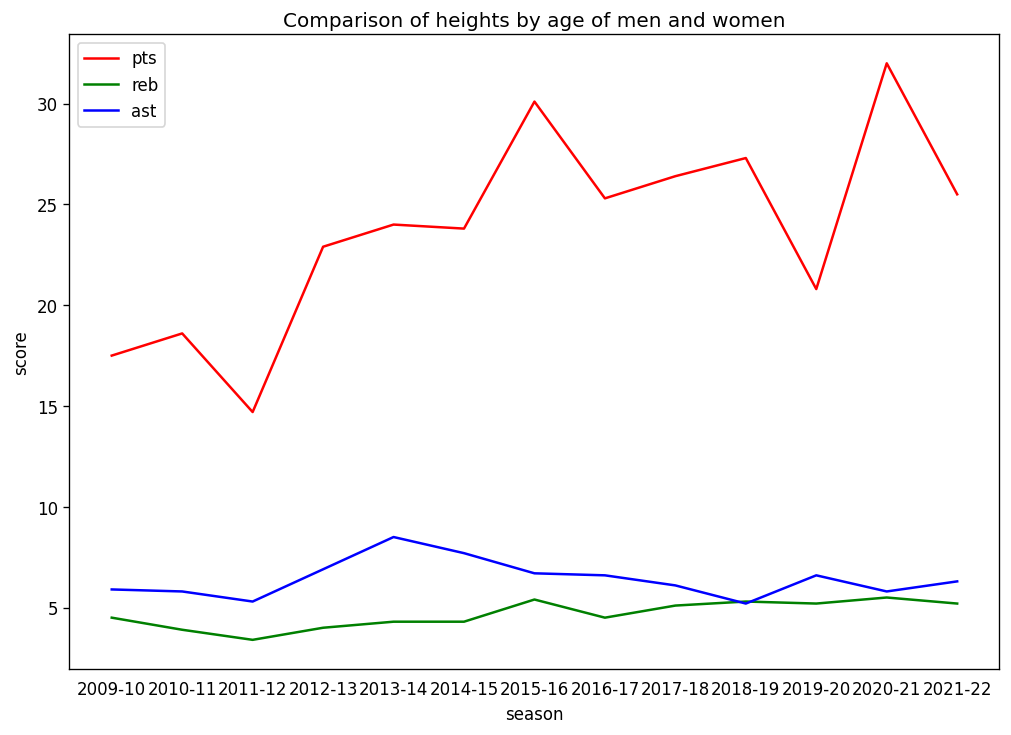

In [76]:
# pts 
x = Curry_data['season']
y = Curry_data['pts']
plt.figure(figsize=(10,7))

plt.plot(x, y, label='pts' ,color='red')

# reb
x = Curry_data['season']
y = Curry_data['reb']

plt.plot(x, y, label='reb' ,color='green')

#ast
x = Curry_data['season']
y = Curry_data['ast']

plt.plot(x, y, label='ast' ,color='blue')


plt.xlabel("season")
plt.ylabel("score")
plt.title("Comparison of heights by age of men and women")
plt.legend()

plt.show()

### 5. Pie Plot그려보기!

2015-16 시즌 이상 시즌별 Curry의 득점률 비교하는 문제입니다!

- 색깔은 `mediumorchid`,`khaki`,`palegreen`,`deeppink`,`orange`,`teal`,`royalblue`을 조합해서 이용해주세요!
- 제일 득점률이 높은 시즌의 슬라이스를 분리해주세요!
- 참조 : [ref](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html)



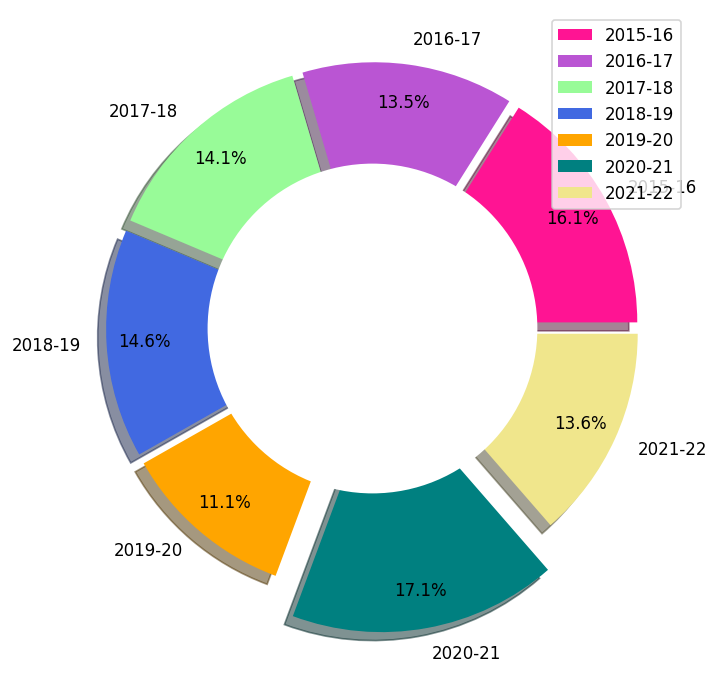

In [77]:
seasonCount = Curry_data[Curry_data['season'] >= '2015-16']['pts']
# typeCount
fig, ax = plt.subplots(figsize=(7,7))

ax.pie(
      seasonCount,
      labels = Curry_data[Curry_data['season'] >= '2015-16'].season,
      autopct='%1.1f%%', # 숫자 표현
      pctdistance=0.85, # 숫자 바깥쪽으로 빼내기
      explode=[0.05,0.05,0.05,0.05,0.05,0.2,0.05], # 플롯슬라이싱, 값이 제일 큰 값은 0.2 만큼 주어 슬라이싱
      colors = ['deeppink','mediumorchid','palegreen','royalblue','orange','teal','khaki'],
      shadow=True
    )
ax.legend()

#draw white circle in the middle
centre_circle = plt.Circle((0,0), 0.65, fc='white')
ax.add_artist(centre_circle)

plt.show()

## 로또 데이터
아래 데이터는 로또 데이터입니다! 2022-12-07부터 2021-04-24 날짜의 로또번호를 담고있습니다! 

In [78]:
df_lotto = pd.read_csv('https://raw.githubusercontent.com/wonseok-hong/DAP_TA/main/DATA_Korean_Lotto_20021207-20210424.csv')
df_lotto

lottery        date  num1  num2  num3  num4  num5  num6  bonus
0          1  2002-12-07    10    23    29    33    37    40     16
1          2  2002-12-14     9    13    21    25    32    42      2
2          3  2002-12-21    11    16    19    21    27    31     30
3          4  2002-12-28    14    27    30    31    40    42      2
4          5  2003-01-04    16    24    29    40    41    42      3
..       ...         ...   ...   ...   ...   ...   ...   ...    ...
955      956  2021-03-27    10    11    20    21    25    41     40
956      957  2021-04-03     4    15    24    35    36    40      1
957      958  2021-04-10     2     9    10    16    35    37      1
958      959  2021-04-17     1    14    15    24    40    41     35
959      960  2021-04-24     2    18    24    30    32    45     14

[960 rows x 9 columns]

### 6. 여러 subplot에 barplot을 이용하여 그리기
각각의 num에 어떤 숫자가 제일 많이 나왔는지 보기
- boxplot을 이용하여 여러 subplot들을 만들어 한번에 그려주세요!
- plot의 모든 x좌표 간격을 1칸씩으로 만들어주세요!
- 각각의 plot마다 title을 달아주세요!

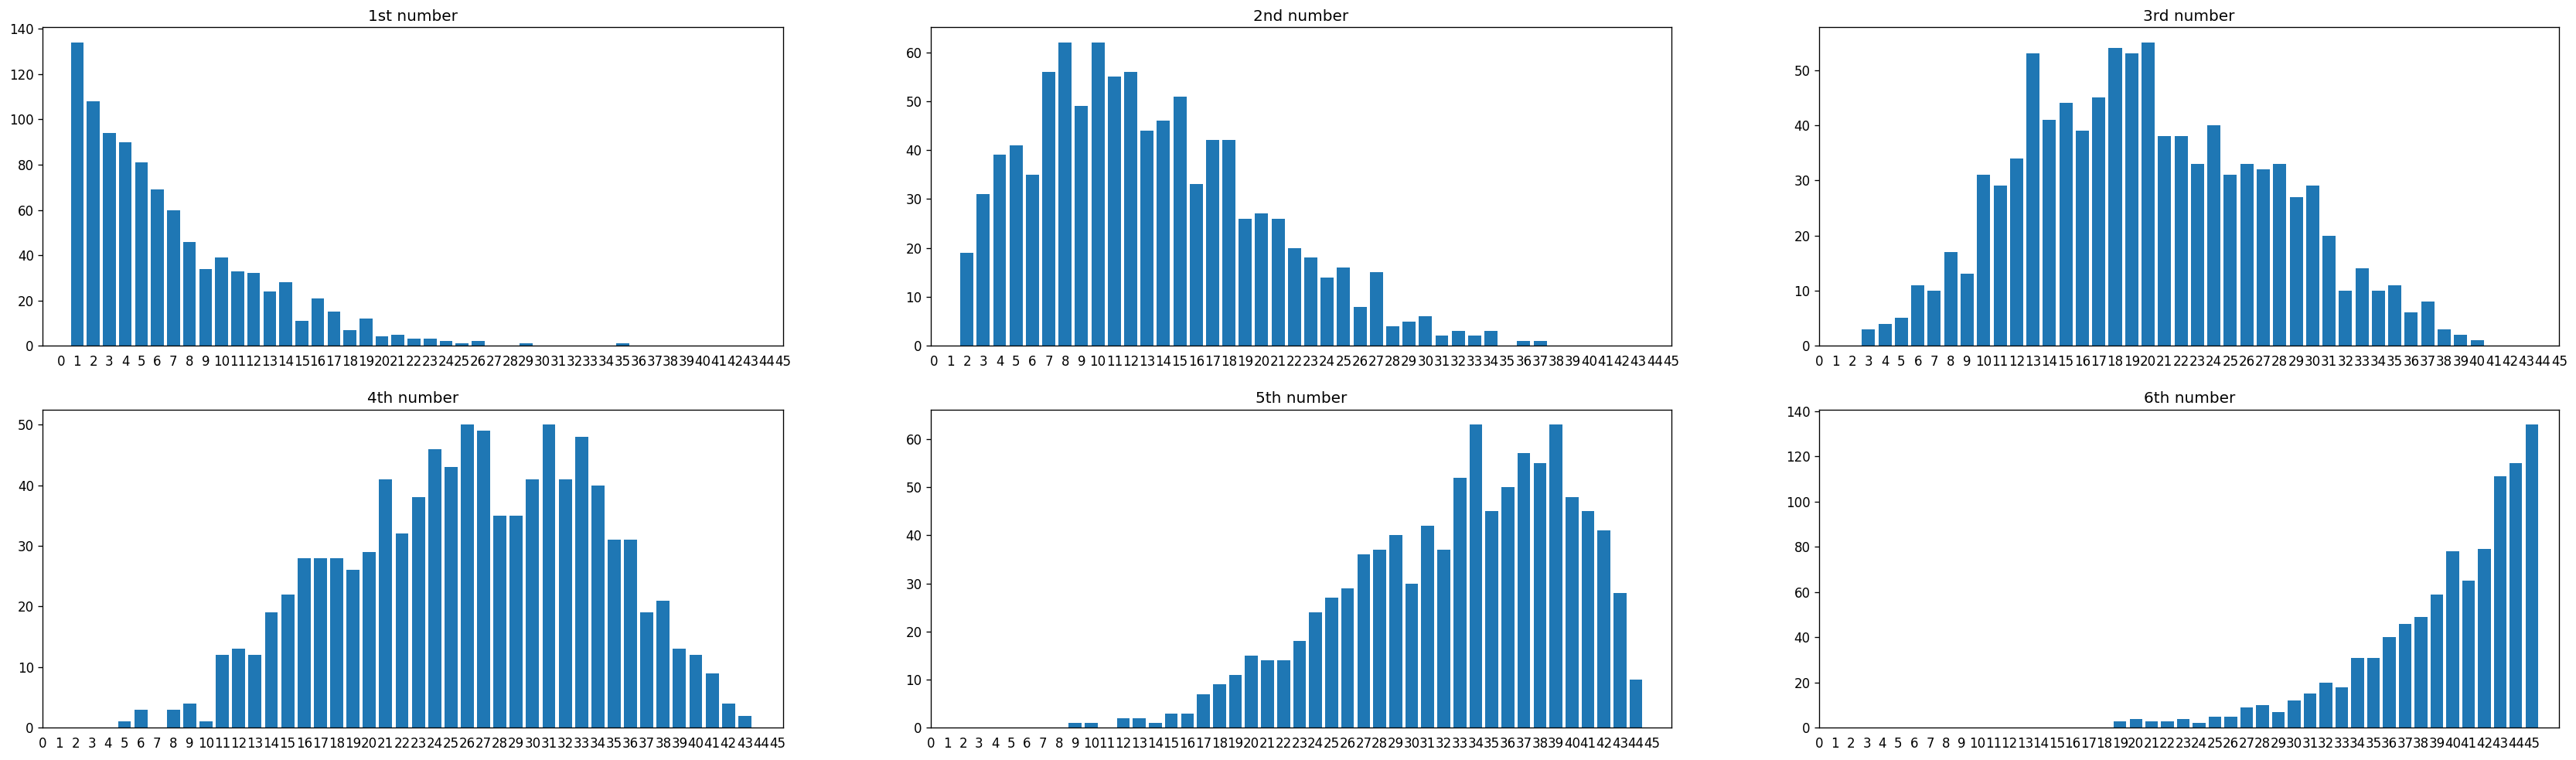

In [79]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches((35,10))
plt.subplots_adjust(wspace=0.2,hspace=0.2)

ax[0,0].bar(df_lotto['num1'].value_counts().index,df_lotto['num1'].value_counts())
ax[0,0].set_title('1st number')
ax[0,0].set_xticks(np.arange(46))

ax[0,1].bar(df_lotto['num2'].value_counts().index,df_lotto['num2'].value_counts())
ax[0,1].set_title('2nd number')
ax[0,1].set_xticks(np.arange(46))

ax[0,2].bar(df_lotto['num3'].value_counts().index,df_lotto['num3'].value_counts())
ax[0,2].set_title('3rd number')
ax[0,2].set_xticks(np.arange(46))

ax[1,0].bar(df_lotto['num4'].value_counts().index,df_lotto['num4'].value_counts())
ax[1,0].set_title('4th number')
ax[1,0].set_xticks(np.arange(46))

ax[1,1].bar(df_lotto['num5'].value_counts().index,df_lotto['num5'].value_counts())
ax[1,1].set_title('5th number')
ax[1,1].set_xticks(np.arange(46))

ax[1,2].bar(df_lotto['num6'].value_counts().index,df_lotto['num6'].value_counts())
ax[1,2].set_title('6th number')
ax[1,2].set_xticks(np.arange(46))

plt.show()

### [optional] 로또 번호의 보너스 숫자는 원하는 plot들을 이용하여 자유롭게 만들어 보세요!

In [80]:
###########힘내세용##########

In [81]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1)

# Cars93 data
In this lab, we would like to explore data about 93 number of vehicles.

In [82]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Cars93_miss.csv')
df

Manufacturer    Model     Type  Min.Price  Price  Max.Price  MPG.city  \
0         Acura  Integra    Small       12.9   15.9       18.8      25.0   
1           NaN   Legend  Midsize       29.2   33.9       38.7      18.0   
2          Audi       90  Compact       25.9   29.1       32.3      20.0   
3          Audi      100  Midsize        NaN   37.7       44.6      19.0   
4           BMW     535i  Midsize        NaN   30.0        NaN      22.0   
..          ...      ...      ...        ...    ...        ...       ...   
88   Volkswagen  Eurovan      Van       16.6   19.7       22.7      17.0   
89   Volkswagen   Passat  Compact       17.6   20.0       22.4      21.0   
90   Volkswagen  Corrado   Sporty       22.9   23.3       23.7      18.0   
91        Volvo      240  Compact       21.8   22.7       23.5      21.0   
92          NaN      850  Midsize       24.8   26.7       28.5      20.0   

    MPG.highway             AirBags DriveTrain  ... Passengers  Length  \
0          31.0                None      Front  ...        5.0   177.0   
1          25.0  Driver & Passenger      Front  ...        5.0   195.0   
2          26.0         Driver only      Front  ...        5.0   180.0   
3          26.0  Driver & Passenger        NaN  ...        6.0   193.0   
4          30.0                 NaN       Rear  ...        4.0   186.0   
..          ...                 ...        ...  ...        ...     ...   
88         21.0                None      Front  ...        7.0   187.0   
89         30.0                None      Front  ...        5.0   180.0   
90         25.0                None      Front  ...        4.0   159.0   
91         28.0         Driver only       Rear  ...        5.0   190.0   
92         28.0  Driver & Passenger      Front  ...        5.0   184.0   

    Wheelbase  Width  Turn.circle Rear.seat.room  Luggage.room  Weight  \
0       102.0   68.0         37.0           26.5           NaN  2705.0   
1       115.0   71.0         38.0           30.0          15.0  3560.0   
2       102.0   67.0         37.0           28.0          14.0  3375.0   
3       106.0    NaN         37.0           31.0          17.0  3405.0   
4       109.0   69.0         39.0           27.0          13.0  3640.0   
..        ...    ...          ...            ...           ...     ...   
88      115.0   72.0         38.0           34.0           NaN  3960.0   
89      103.0   67.0         35.0           31.5          14.0  2985.0   
90       97.0   66.0         36.0           26.0          15.0  2810.0   
91      104.0   67.0         37.0           29.5          14.0  2985.0   
92      105.0   69.0         38.0           30.0          15.0  3245.0   

     Origin                Make  
0   non-USA       Acura Integra  
1   non-USA        Acura Legend  
2   non-USA             Audi 90  
3   non-USA            Audi 100  
4   non-USA            BMW 535i  
..      ...                 ...  
88      NaN  Volkswagen Eurovan  
89  non-USA   Volkswagen Passat  
90  non-USA  Volkswagen Corrado  
91  non-USA           Volvo 240  
92  non-USA           Volvo 850  

[93 rows x 27 columns]

# Filtering Data
Filter only DataFrame with numeric attribute.

In [83]:
numeric_df = df[df.describe().columns]
numeric_df

Min.Price  Price  Max.Price  MPG.city  MPG.highway  EngineSize  \
0        12.9   15.9       18.8      25.0         31.0         1.8   
1        29.2   33.9       38.7      18.0         25.0         3.2   
2        25.9   29.1       32.3      20.0         26.0         2.8   
3         NaN   37.7       44.6      19.0         26.0         NaN   
4         NaN   30.0        NaN      22.0         30.0         3.5   
..        ...    ...        ...       ...          ...         ...   
88       16.6   19.7       22.7      17.0         21.0         2.5   
89       17.6   20.0       22.4      21.0         30.0         2.0   
90       22.9   23.3       23.7      18.0         25.0         2.8   
91       21.8   22.7       23.5      21.0         28.0         2.3   
92       24.8   26.7       28.5      20.0         28.0         2.4   

    Horsepower     RPM  Rev.per.mile  Fuel.tank.capacity  Passengers  Length  \
0        140.0  6300.0        2890.0                13.2         5.0   177.0   
1        200.0  5500.0        2335.0                18.0         5.0   195.0   
2        172.0  5500.0        2280.0                16.9         5.0   180.0   
3        172.0  5500.0        2535.0                21.1         6.0   193.0   
4        208.0  5700.0        2545.0                21.1         4.0   186.0   
..         ...     ...           ...                 ...         ...     ...   
88       109.0  4500.0        2915.0                21.1         7.0   187.0   
89       134.0  5800.0        2685.0                18.5         5.0   180.0   
90       178.0  5800.0        2385.0                18.5         4.0   159.0   
91       114.0  5400.0        2215.0                15.8         5.0   190.0   
92       168.0  6200.0           NaN                19.3         5.0   184.0   

    Wheelbase  Width  Turn.circle  Rear.seat.room  Luggage.room  Weight  
0       102.0   68.0         37.0            26.5           NaN  2705.0  
1       115.0   71.0         38.0            30.0          15.0  3560.0  
2       102.0   67.0         37.0            28.0          14.0  3375.0  
3       106.0    NaN         37.0            31.0          17.0  3405.0  
4       109.0   69.0         39.0            27.0          13.0  3640.0  
..        ...    ...          ...             ...           ...     ...  
88      115.0   72.0         38.0            34.0           NaN  3960.0  
89      103.0   67.0         35.0            31.5          14.0  2985.0  
90       97.0   66.0         36.0            26.0          15.0  2810.0  
91      104.0   67.0         37.0            29.5          14.0  2985.0  
92      105.0   69.0         38.0            30.0          15.0  3245.0  

[93 rows x 18 columns]

Print rows with **RPM** greater(초과) than **6000** in numeric_df

In [84]:
rpm_over_6000 = numeric_df[numeric_df['RPM'] > 6000]
rpm_over_6000

Min.Price  Price  Max.Price  MPG.city  MPG.highway  EngineSize  \
0        12.9   15.9       18.8      25.0         31.0         1.8   
31        8.4   10.1       11.9      23.0         30.0         1.8   
56       32.5   32.5       32.5      17.0         25.0         1.3   
92       24.8   26.7       28.5      20.0         28.0         2.4   

    Horsepower     RPM  Rev.per.mile  Fuel.tank.capacity  Passengers  Length  \
0        140.0  6300.0        2890.0                13.2         5.0   177.0   
31       127.0  6500.0        2410.0                13.2         5.0   171.0   
56       255.0  6500.0        2325.0                20.0         2.0   169.0   
92       168.0  6200.0           NaN                19.3         5.0   184.0   

    Wheelbase  Width  Turn.circle  Rear.seat.room  Luggage.room  Weight  
0       102.0   68.0         37.0            26.5           NaN  2705.0  
31       98.0   67.0         36.0            28.0          12.0  2530.0  
56       96.0   69.0          NaN             NaN           NaN     NaN  
92      105.0   69.0         38.0            30.0          15.0  3245.0

Print rows with **Max.Price** less(미만) than **16.0** and **Passengers** more(이상) than **5.0**

In [85]:
max_price_and_passengers = numeric_df[(numeric_df['Max.Price'] < 16.0) & (numeric_df['Passengers'] >= 5.0)]
max_price_and_passengers

Min.Price  Price  Max.Price  MPG.city  MPG.highway  EngineSize  \
12       11.4   11.4       11.4      25.0         34.0         2.2   
22        7.9    9.2       10.6      29.0         33.0         1.5   
23        8.4   11.3       14.2      23.0         29.0         2.2   
24       11.9   13.3       14.7      22.0         27.0         2.5   
31        8.4   10.1       11.9      23.0         30.0         1.8   
32       10.4   11.3       12.2      22.0         27.0         2.3   
43        6.8    8.0        9.2      29.0         33.0         1.5   
44        9.0   10.0       11.0       NaN         29.0         1.8   
46       12.4   13.9       15.3      20.0         27.0         2.0   
53       10.9   11.6       12.3      28.0         36.0         1.8   
60       14.9   14.9       14.9      19.0         26.0         3.8   
61        7.7   10.3       12.9      29.0          NaN         1.5   
63        8.7   11.8       14.9      29.0         33.0         1.6   
67       13.0   13.5       14.0      24.0         31.0         2.3   
73        9.4   11.1       12.8       NaN         31.0         2.0   
78        9.2    NaN       12.9       NaN         38.0         1.9   
80       10.5   10.9       11.3      25.0         30.0         1.8   

    Horsepower     RPM  Rev.per.mile  Fuel.tank.capacity  Passengers  Length  \
12       110.0  5200.0        2665.0                15.6         5.0   184.0   
22        92.0  6000.0        3285.0                 NaN         5.0   174.0   
23        93.0  4800.0           NaN                14.0         5.0   172.0   
24       100.0  4800.0        2535.0                 NaN         6.0   181.0   
31       127.0  6500.0        2410.0                13.2         5.0   171.0   
32        96.0  4200.0        2805.0                15.9         5.0   177.0   
43        81.0  5500.0        2710.0                11.9         5.0   168.0   
44       124.0  6000.0        2745.0                13.7         5.0   172.0   
46       128.0  6000.0        2335.0                17.2         5.0   184.0   
53       103.0  5500.0        2220.0                14.5         5.0   172.0   
60       140.0  3800.0        1730.0                18.0         5.0   199.0   
61        92.0  6000.0        2505.0                13.2         5.0   172.0   
63       110.0  6000.0        2435.0                13.2         5.0   170.0   
67       155.0  6000.0        2380.0                15.2         5.0   188.0   
73       110.0  5200.0        2665.0                15.2         5.0   181.0   
78        85.0  5000.0        2145.0                12.8         5.0   176.0   
80        90.0  5200.0        3375.0                15.9         5.0   175.0   

    Wheelbase  Width  Turn.circle  Rear.seat.room  Luggage.room  Weight  
12      103.0   68.0         39.0            26.0           NaN  2785.0  
22       98.0   66.0         32.0             NaN          11.0  2270.0  
23       97.0   67.0         38.0            26.5           NaN  2670.0  
24      104.0   68.0         39.0            30.5           NaN  2970.0  
31       98.0   67.0         36.0            28.0          12.0  2530.0  
32      100.0   68.0          NaN            27.5          13.0     NaN  
43       94.0   63.0         35.0            26.0          11.0  2345.0  
44       98.0   66.0         36.0            28.0          12.0  2620.0  
46      104.0   69.0         41.0            31.0           NaN  2885.0  
53       98.0   66.0         36.0            26.5          13.0  2440.0  
60      113.0   73.0         38.0            28.0          15.0  3610.0  
61       98.0   67.0         36.0            26.0          11.0  2295.0  
63       96.0   66.0         33.0            26.0           NaN     NaN  
67      103.0   67.0         39.0            28.0          14.0  2910.0  
73      101.0   66.0         39.0            25.0          13.0     NaN  
78      102.0   68.0         40.0            26.5           NaN  2495.0  
80       97.0   65.0         35.0           

# Handling Outlier

Remove outliers of length.

Use IQR first here.

* Assume that `Length` of outlier is greater than `Q3 + (1.5 * IQR)`, less than `Q1 - (1.5 * IQR)`

In [86]:
attribute = 'Length'

Q3= df[attribute].quantile(.75)
Q1= df[attribute].quantile(.25)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR
#범위 지정 주의. filterd가 저 위에 범위니 우리는 그 반대 범위를 구하면 됨.
filtered_df = df[(df[attribute] < Q3 + outlier_step) & (df[attribute] > Q1 - outlier_step)]

Draw histogram of `Length`.

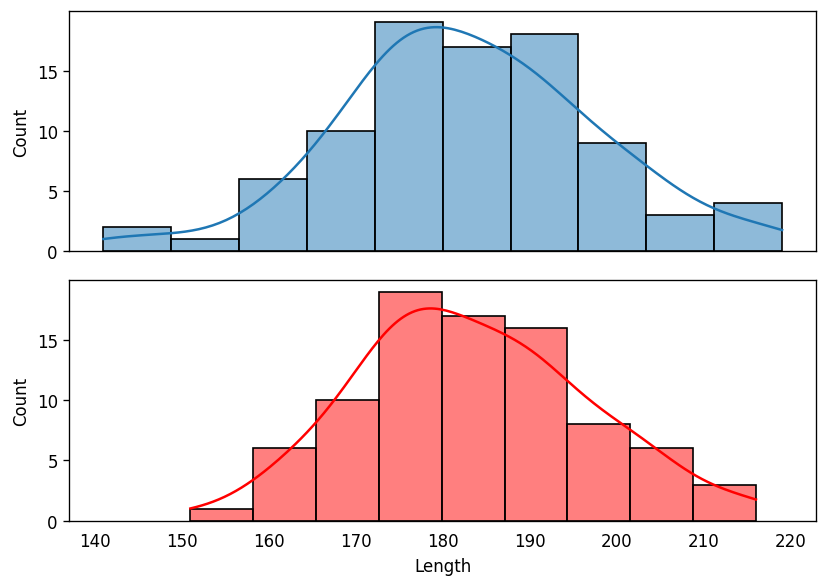

In [87]:
f, axes = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

sns.histplot(data=df, x=attribute, ax=axes[0], kde=True)
sns.histplot(data=filtered_df, x=attribute, color='Red',
             ax=axes[1], kde=True)
f.tight_layout()

Use Z-score in here.

In [88]:
upper_limit = df[attribute].mean() + 2 * df[attribute].std()
lower_limit = df[attribute].mean() - 2 * df[attribute].std()

filtered_df = df[(df[attribute] < upper_limit) & (df[attribute] > lower_limit)]

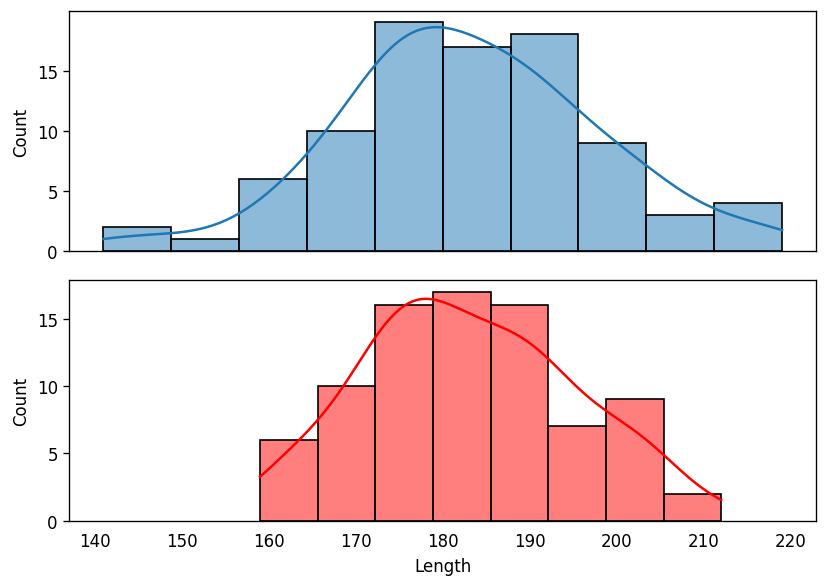

In [89]:
f, axes = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

sns.histplot(data=df, x=attribute, ax=axes[0], kde=True)
sns.histplot(data=filtered_df, x=attribute, color='Red',
             ax=axes[1], kde=True)
f.tight_layout()

# Hanlding Missing Value
---
Last time, we dropped the NaN value, impute this time.

print the `head()` of numeric_df

In [90]:
numeric_df.head()

Min.Price  Price  Max.Price  MPG.city  MPG.highway  EngineSize  Horsepower  \
0       12.9   15.9       18.8      25.0         31.0         1.8       140.0   
1       29.2   33.9       38.7      18.0         25.0         3.2       200.0   
2       25.9   29.1       32.3      20.0         26.0         2.8       172.0   
3        NaN   37.7       44.6      19.0         26.0         NaN       172.0   
4        NaN   30.0        NaN      22.0         30.0         3.5       208.0   

      RPM  Rev.per.mile  Fuel.tank.capacity  Passengers  Length  Wheelbase  \
0  6300.0        2890.0                13.2         5.0   177.0      102.0   
1  5500.0        2335.0                18.0         5.0   195.0      115.0   
2  5500.0        2280.0                16.9         5.0   180.0      102.0   
3  5500.0        2535.0                21.1         6.0   193.0      106.0   
4  5700.0        2545.0                21.1         4.0   186.0      109.0   

   Width  Turn.circle  Rear.seat.room  Luggage.room  Weight  
0   68.0         37.0            26.5           NaN  2705.0  
1   71.0         38.0            30.0          15.0  3560.0  
2   67.0         37.0            28.0          14.0  3375.0  
3    NaN         37.0            31.0          17.0  3405.0  
4   69.0         39.0            27.0          13.0  3640.0



There are many NaN values exist. 

Use `info()` to check the details.

In [91]:
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Min.Price           86 non-null     float64
 1   Price               91 non-null     float64
 2   Max.Price           88 non-null     float64
 3   MPG.city            84 non-null     float64
 4   MPG.highway         91 non-null     float64
 5   EngineSize          91 non-null     float64
 6   Horsepower          86 non-null     float64
 7   RPM                 90 non-null     float64
 8   Rev.per.mile        87 non-null     float64
 9   Fuel.tank.capacity  85 non-null     float64
 10  Passengers          91 non-null     float64
 11  Length              89 non-null     float64
 12  Wheelbase           92 non-null     float64
 13  Width               87 non-null     float64
 14  Turn.circle         88 non-null     float64
 15  Rear.seat.room      89 non-null     float64
 16  Luggage.ro

Impute the data with missing value with `SimpleImputer` with `mean`.

In [92]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(numeric_df)

imputed_numeric_df = pd.DataFrame(imp_mean.transform(numeric_df), columns=numeric_df.columns)
imputed_numeric_df.head()

Min.Price  Price  Max.Price  MPG.city  MPG.highway  EngineSize  Horsepower  \
0  12.900000   15.9  18.800000      25.0         31.0    1.800000       140.0   
1  29.200000   33.9  38.700000      18.0         25.0    3.200000       200.0   
2  25.900000   29.1  32.300000      20.0         26.0    2.800000       172.0   
3  17.118605   37.7  44.600000      19.0         26.0    2.658242       172.0   
4  17.118605   30.0  21.459091      22.0         30.0    3.500000       208.0   

      RPM  Rev.per.mile  Fuel.tank.capacity  Passengers  Length  Wheelbase  \
0  6300.0        2890.0                13.2         5.0   177.0      102.0   
1  5500.0        2335.0                18.0         5.0   195.0      115.0   
2  5500.0        2280.0                16.9         5.0   180.0      102.0   
3  5500.0        2535.0                21.1         6.0   193.0      106.0   
4  5700.0        2545.0                21.1         4.0   186.0      109.0   

       Width  Turn.circle  Rear.seat.room  Luggage.room  Weight  
0  68.000000         37.0            26.5     13.986486  2705.0  
1  71.000000         38.0            30.0     15.000000  3560.0  
2  67.000000         37.0            28.0     14.000000  3375.0  
3  69.448276         37.0            31.0     17.000000  3405.0  
4  69.000000         39.0            27.0     13.000000  3640.0

Check through `info()` that NaN values don't exist any more.

In [93]:
imputed_numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Min.Price           93 non-null     float64
 1   Price               93 non-null     float64
 2   Max.Price           93 non-null     float64
 3   MPG.city            93 non-null     float64
 4   MPG.highway         93 non-null     float64
 5   EngineSize          93 non-null     float64
 6   Horsepower          93 non-null     float64
 7   RPM                 93 non-null     float64
 8   Rev.per.mile        93 non-null     float64
 9   Fuel.tank.capacity  93 non-null     float64
 10  Passengers          93 non-null     float64
 11  Length              93 non-null     float64
 12  Wheelbase           93 non-null     float64
 13  Width               93 non-null     float64
 14  Turn.circle         93 non-null     float64
 15  Rear.seat.room      93 non-null     float64
 16  Luggage.ro

# Balancing Data

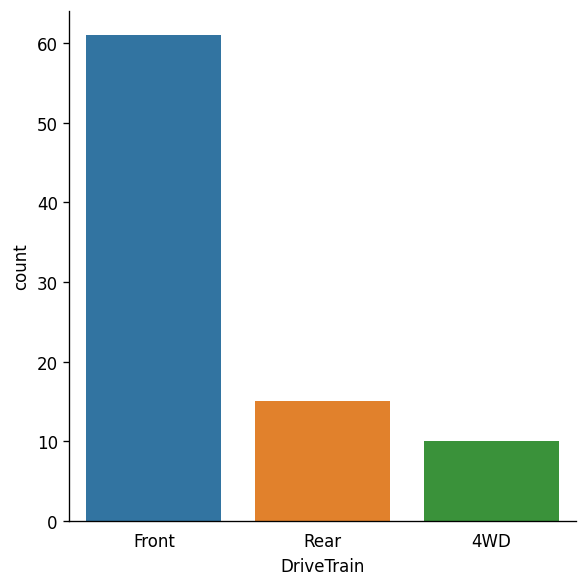

In [94]:
sns.catplot(data=df, kind="count", x='DriveTrain')
f.tight_layout()

Undersample the `Front` and `Rear` cars as much as `4WD` cars.

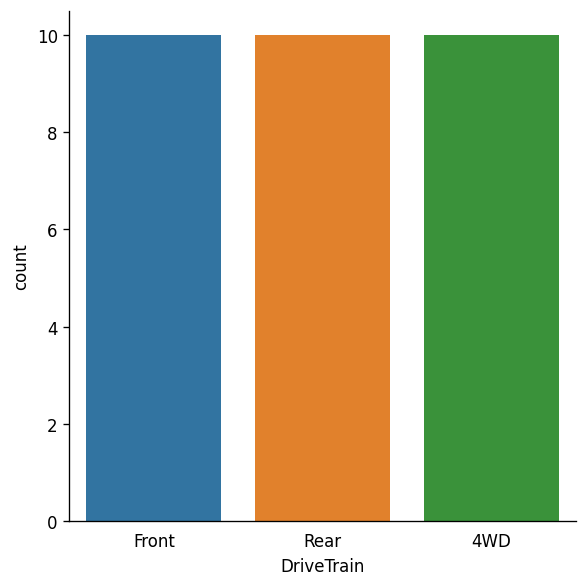

In [95]:
num_0 = sum(df.DriveTrain=='Front')
num_1 = sum(df.DriveTrain=='Rear')
num_2 = sum(df.DriveTrain=='4WD')

# random undersample
undersampledDf = pd.concat([df[df['DriveTrain']=='Front'].sample(num_2), df[df['DriveTrain']=='Rear'].sample(num_2),
                            df[df['DriveTrain']=='4WD'] ])

sns.catplot(data=undersampledDf, kind="count", x='DriveTrain')
f.tight_layout()

# Todo!

**[Preface]**

1. 지난 번 과제가 너무 어렵다는 소식을 듣고 난이도를 최대한 완화했어요, 조건으로 여러분의 생각에 제약을 걸기보단 도움을 많이 드릴 예정이에요!

2. 그러니 마음 편히 먹고 출발해봅시다!

3. 그래도 너무 어려우면 손들거나 이루리로 달려가기! (대신 문제 읽자마자 이루리로 달려가진 마세요...)

## 1. 로그 데이터 분석으로 이상 사용자 검출하기


곰돌대학교 수강신청 사이트 관리자가 데이터 분석을 의뢰했습니다, 대학교 익명 커뮤니티에 수강신청을 돕는 매크로 프로그램이 유포된 바람에 비정상적으로 수강신청을 한 학생이 있다고 하네요!

하지만 증거를 수집하기 전에 게시글이 삭제되어서 관리자는 해당 매크로 프로그램의 기능을 알지 못하는 상황이에요.

매크로를 사용했다고 의심이 가는 학생의 학번 리스트와 행동양상을 파악해주세요!

&nbsp;

---


**[Notion]**

* 해당 데이터는 가상의 데이터이며, 등장하는 학번들은 모두 허구에요. 즉, 랜덤으로 생성된 데이터이기 때문에 실존 인물의 학번과 아무런 관련이 없어요!

* 만약 학번이 겹친다면, 정말 우연의 일치인거예요!! numpy의 선택을 받은 것이니 너무 기분 나빠하지 마세요!

&nbsp;

---

**[About Data]**
* `code_student`는 가상의 학번으로 곰돌대학교 학생을 특정할 때 사용해요.
* `time_spent`는 수강신청 사이트에서 머무른 시간으로 단위는 's'(초)에요.
* `click_per_min`는 수강신청 사이트에서 분당 클릭한 평균 횟수에요.
* `refresh_per_min`는 수강신청 사이트에서 분당 새로고침, 사이트 이동을 시도한 평균 횟수에요.
* `delay_time`은 서버와의 지연을 의미하며, 단위는 'ns'(나노세컨드)에요.

In [96]:
df = pd.read_excel('https://github.com/TA-YSH/DAP/raw/main/lab5/lab5_student_data.xlsx', index_col = 0)
df

code_student  time_spent  click_per_min  refresh_per_min  delay_time
0       201810130  471.551388             54               18   25.283161
1       201810574  723.369401             42               19   25.594568
2       201810806  653.702642             21               19   21.323300
3       201810859  603.981965             68               17   39.148978
4       201811217  510.630862             30               20   29.151656
..            ...         ...            ...              ...         ...
295     202218787  558.945241             50               21   33.381013
296     202219052  555.837431             46               22   28.891619
297     202219648  670.720211             43               21   30.863044
298     202219691  406.228555             47               22   25.097369
299     202219789  636.189783             52               20   28.732384

[300 rows x 5 columns]

### 1.1 데이터 형태 파악하기
---

우선 `code_student`를 제외한 다른 모든 속성에 대해 describe를 출력해주세요!

In [97]:
df.drop(columns=['code_student']).describe() # 출력만 맞으면 정답 인정

time_spent  click_per_min  refresh_per_min  delay_time
count  300.000000     300.000000       300.000000  300.000000
mean   632.126949      46.823333        20.060000   28.751335
std    151.666971      12.598460         4.541492    5.333119
min    223.749103      21.000000        11.000000    9.707395
25%    528.959635      39.000000        18.000000   25.957021
50%    638.356663      45.000000        19.000000   29.302176
75%    731.592466      51.000000        21.000000   31.967153
max    982.938188     109.000000        47.000000   43.194162

### 1.2 연관도 분석하기
---

연관성을 확인해보기 위해, `code_student`를 제외한 다른 모든 속성에 대해 `Pearson correlation coefficient`와 `pairplot`를 출력해주세요.

전체적인 데이터 분포와 이상값들이 어떻게 분포되어 있는지 대충 파악하실 수 있을 것입니다!

&nbsp;

**[hint]**

1. 어디서 많이 본 내용이지 않나요?

2. 위키백과 `상관분석`의 문서에 따르면 pearson correlation의 결과 p는 다음과 같이 해석이 가능하다고 합니다.

* r이 **-1.0과 -0.7 사이**면, `강한 음적 선형관계`

* r이 **-0.7과 -0.3 사이**면, `뚜렷한 음적 선형관계`
* r이 **-0.3과 -0.1 사이**면, `약한 음적 선형관계`
* r이 **-0.1과 +0.1 사이**면, `거의 무시될 수 있는 선형관계`
* r이 **+0.1과 +0.3 사이**면, `약한 양적 선형관계`
* r이 **+0.3과 +0.7 사이**면, `뚜렷한 양적 선형관계`
* r이 **+0.7과 +1.0 사이**면, `강한 양적 선형관계`


In [98]:
df.drop(columns=['code_student']).corr(method='pearson') #pearson 외에 다른 method 사용시 + 출력이 다르면 0점 (but, 속성 순서 바뀌는건 인정)

time_spent  click_per_min  refresh_per_min  delay_time
time_spent         1.000000       0.030848         0.084636    0.021354
click_per_min      0.030848       1.000000         0.624823   -0.472252
refresh_per_min    0.084636       0.624823         1.000000   -0.535295
delay_time         0.021354      -0.472252        -0.535295    1.000000

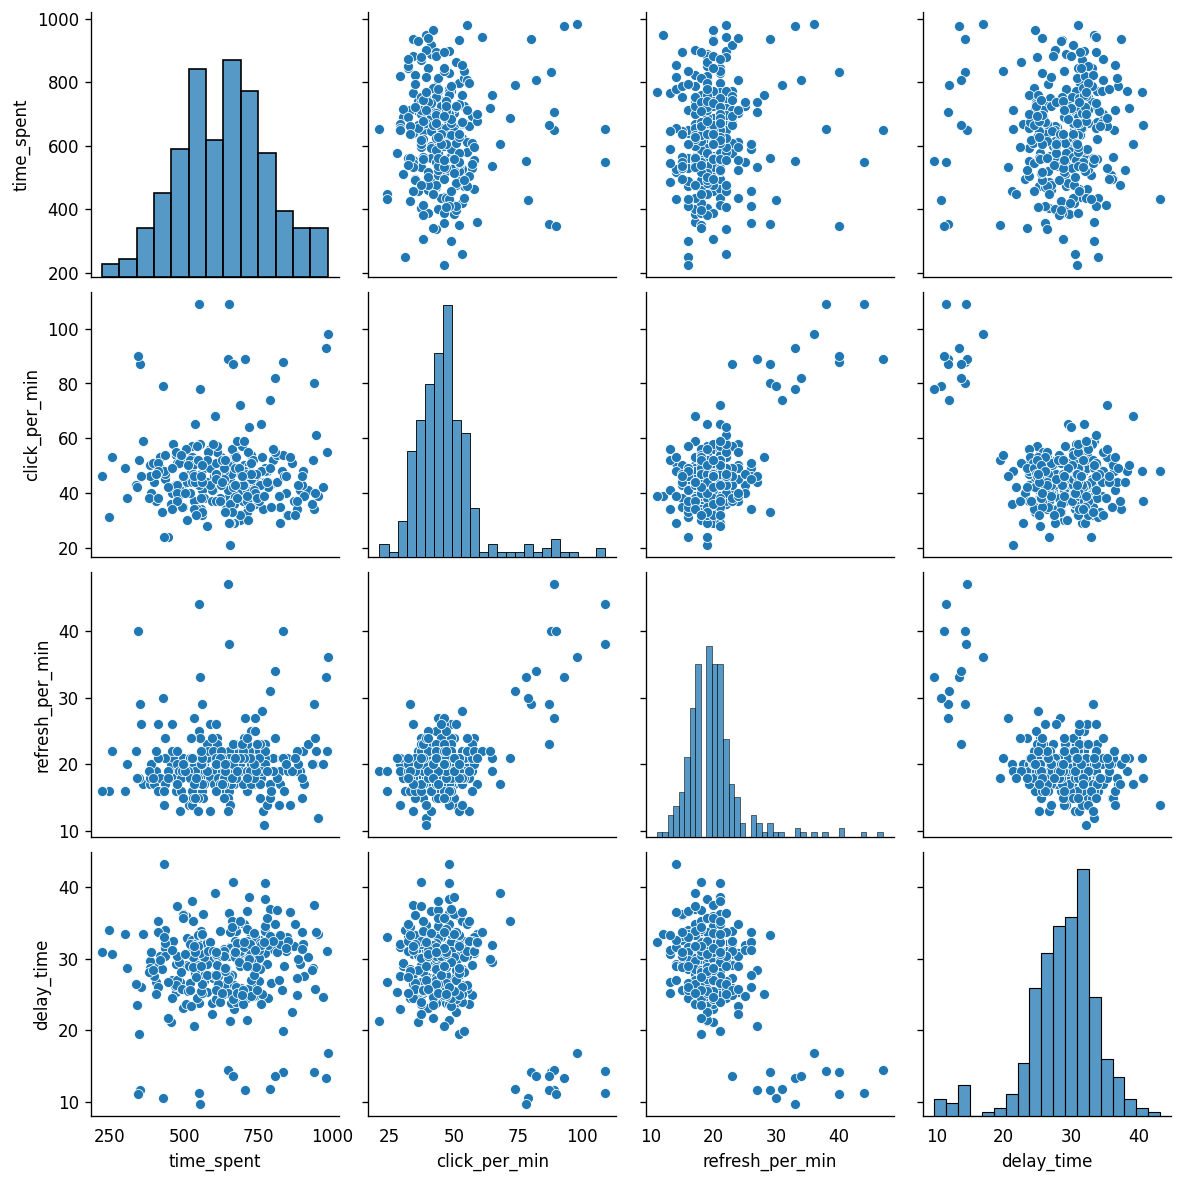

In [99]:
g = sns.pairplot(df.drop(columns=['code_student'])) #출력 다름 0점 (속성 순서 바뀌는건 상관 없음)
plt.show()

### 1.3 Outlier 검출하기

---

눈으로 보았을 때에는 Outlier가 누구인지 대충 알 수 있지 않나요?

하지만 우리가 눈으로 보는 것만큼 컴퓨터가 이해하지는 못하겠죠? 컴퓨터가 이해하려면 정확하고 타이트한 조건을 걸어줘야 해요.

hint를 참고하여 각 속성에 따라 Outlier를 검출하는 조건을 세우고, `해당 조건에 하나라도 충족되는 사람들을` 우선 `outlier_candidate1`에 저장하세요.


**[hint]**

1. 1.2 절에서의 그래프를 주목해주세요, 해당 그래프는 `어떤 속성`의 Outlier를 `어떤 방식`으로 검출할 지 알려주고 있어요.

2. Outlier를 검출하기 위해서, `quantile`을 사용하는 방법과 `z-score`을 사용하는 방법이 있습니다. 과연 어떤 방법이 제일 적절할까요?

- 두 방법 모두 lecture note에서 설명하고 있는 표준을 따르세요 (outlier_step = 1.5, z-score = 3)


In [100]:
attribute = ['click_per_min', 'refresh_per_min', 'delay_time']

Q1 = df[attribute].quantile(.25)
Q3 = df[attribute].quantile(.75)

IQR = Q3 - Q1
outlier_step = 1.5 * IQR

big_outlier = Q3 + outlier_step
small_outlier = Q1 - outlier_step

condition_1 = df['click_per_min'] > big_outlier['click_per_min']
condition_2 = df['refresh_per_min'] > big_outlier['refresh_per_min']
condition_3 = df['delay_time'] < small_outlier['delay_time']

outlier_candidate1 = df[
    condition_1 | 
    condition_2 |
    condition_3
    ] # 해당 조건이 3개가 합집합으로 묶이는 구조여야함

outlier_candidate1

code_student  time_spent  click_per_min  refresh_per_min  delay_time
9       201811933  936.842404             80               29   14.212713
10      201811958  982.938188             98               36   16.900198
38      201816880  976.924134             93               33   13.409298
53      201818738  833.032116             88               40   14.277280
108     201917437  706.152384             89               27   11.676547
139     202012285  352.147033             87               29   11.646584
146     202014166  760.948801             53               28   25.014618
147     202014741  588.798337             49               26   32.328047
156     202016312  429.603214             79               30   10.641860
162     202017340  345.932692             90               40   11.144838
169     202017957  806.673522             82               34   13.663162
171     202018190  354.807819             46               26   26.049014
172     202018326  552.325580             78               33    9.707395
176     202019629  739.526291             44               27   28.340166
180     202110260  790.235758             74               31   11.906797
221     202116260  410.573472             51               26   33.633846
230     202117531  652.154994            109               38   14.370052
237     202119541  649.080790             89               47   14.525450
255     202211912  548.942547            109               44   11.355035
258     202212354  664.076761             87               23   13.619204
269     202214327  533.454027             46               27   20.569907
271     202214519  458.331273             34               26   31.217420
282     202217023  605.867631             45               26   27.675399
283     202217095  559.829608             33               29   33.272680
290     202218150  687.806967             72               21   35.267845

### 1.4 Abuser 속성 추가하기

---

df에 `abuser`라는 속성을 추가할거예요. 다음 조건을 준수해서 df에 `abuser`속성을 추가해주세요!

**[abuser]**
* `abuser`의 초기값은 **False** 입니다.
* 만약 이상치 검사로 outlier로 판명될 경우, `abuser`의 값이 **True**가 됩니다.
* 즉, outlier_candidate 명단에 포함되었을 경우 df에서 해당 row의 `abuser` 속성이 **True**가 됩니다.

**[hint]**

* DataFrame에서 하나의 요소의 값을 바꾸려면 loc를 사용해보세요 (ex: df.loc[1, 'name'] = '유서후')

In [101]:
df['abuser'] = False
df.loc[outlier_candidate1['code_student'].index, 'abuser'] = True


df[df['abuser']] #결과만 맞으면 인정

code_student  time_spent  click_per_min  refresh_per_min  delay_time  \
9       201811933  936.842404             80               29   14.212713   
10      201811958  982.938188             98               36   16.900198   
38      201816880  976.924134             93               33   13.409298   
53      201818738  833.032116             88               40   14.277280   
108     201917437  706.152384             89               27   11.676547   
139     202012285  352.147033             87               29   11.646584   
146     202014166  760.948801             53               28   25.014618   
147     202014741  588.798337             49               26   32.328047   
156     202016312  429.603214             79               30   10.641860   
162     202017340  345.932692             90               40   11.144838   
169     202017957  806.673522             82               34   13.663162   
171     202018190  354.807819             46               26   26.049014   
172     202018326  552.325580             78               33    9.707395   
176     202019629  739.526291             44               27   28.340166   
180     202110260  790.235758             74               31   11.906797   
221     202116260  410.573472             51               26   33.633846   
230     202117531  652.154994            109               38   14.370052   
237     202119541  649.080790             89               47   14.525450   
255     202211912  548.942547            109               44   11.355035   
258     202212354  664.076761             87               23   13.619204   
269     202214327  533.454027             46               27   20.569907   
271     202214519  458.331273             34               26   31.217420   
282     202217023  605.867631             45               26   27.675399   
283     202217095  559.829608             33               29   33.272680   
290     202218150  687.806967             72               21   35.267845   

     abuser  
9      True  
10     True  
38     True  
53     True  
108    True  
139    True  
146    True  
147    True  
156    True  
162    True  
169    True  
171    True  
172    True  
176    True  
180    True  
221    True  
230    True  
237    True  
255    True  
258    True  
269    True  
271    True  
282    True  
283    True  
290    True

`abuser`을 구분하면서 pairplot을 다시 그려볼거예요.

하지만 이번 Lab은 Outlier 구분이 주요 쟁점이므로 코드를 따로 입력하지 않으셔도 괜찮습니다!

그냥 실행 버튼을 편하게 눌러주세요!

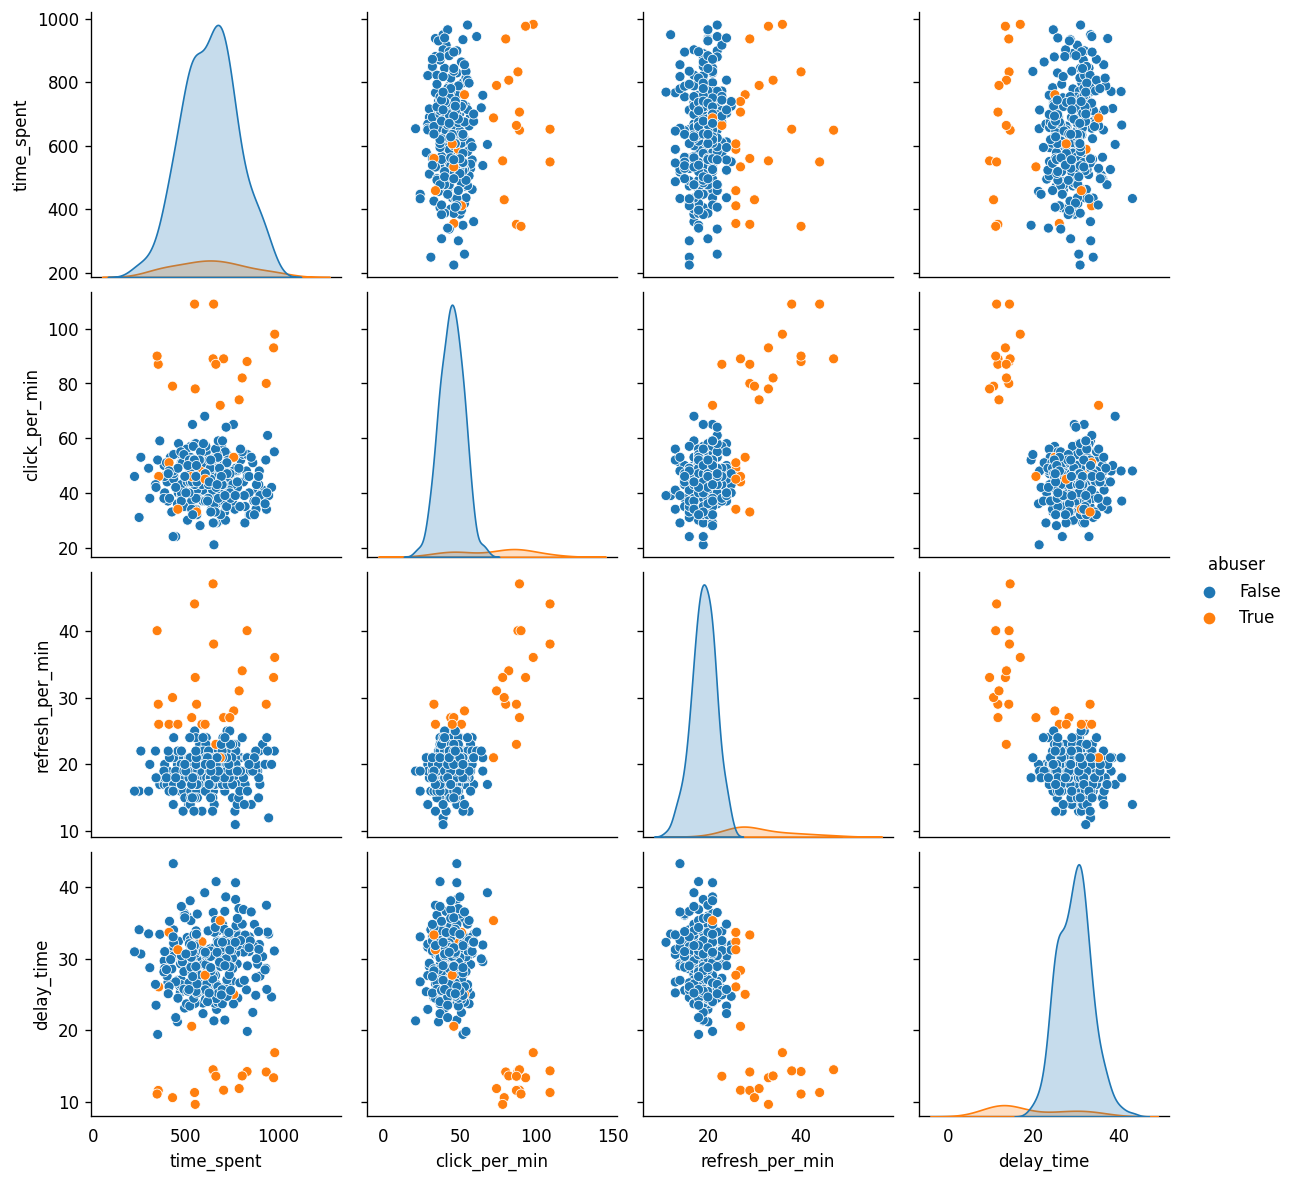

In [102]:
g = sns.pairplot(df.drop(columns=['code_student']), hue='abuser') #그림과 일치해야 함, 그 외에는 모두 0점
plt.show()

### 1.5 Condition 세부조정하기1

---

그래프를 보았을 때, 실제로 정상 범주라고 추정되는 사람들도 Outlier로 검출된 것 같지 않나요?

컴퓨터는 정말 피도 눈물도 없는 냉정한 성격인걸까요?

아니면 우리가 Outlier라고 판단하는 조건을 너무 넓게 설정했을지도 모릅니다.

이번에는 조건을 조금 타이트하게 좁혀 Outlier들을 특정해봅시다!

`1.3 절`에서 `사용한 조건에 모두 포함된 학생`만 Outlier로 판별하도록 조정하세요.

**[condition]**

* z score 값, 혹은 outlier step의 계수는 변경하지 마세요.


**[hint]**

* 중복되는 코드, 조건들을 미리 변수에 담아두셨으면 쉽게 작성하실 수 있을거예요.

* df에서 `abuser`속성을 **False**로 초기화하고, 포함된 학생들을 **True**로 바꿔주는 코드는 위에서 복붙해서 사용하세요.

* df에는 해당 조건을 기준으로 Outlier로 판명된 학생의 `abuser`속성이 **True**가 되어있어야 합니다!


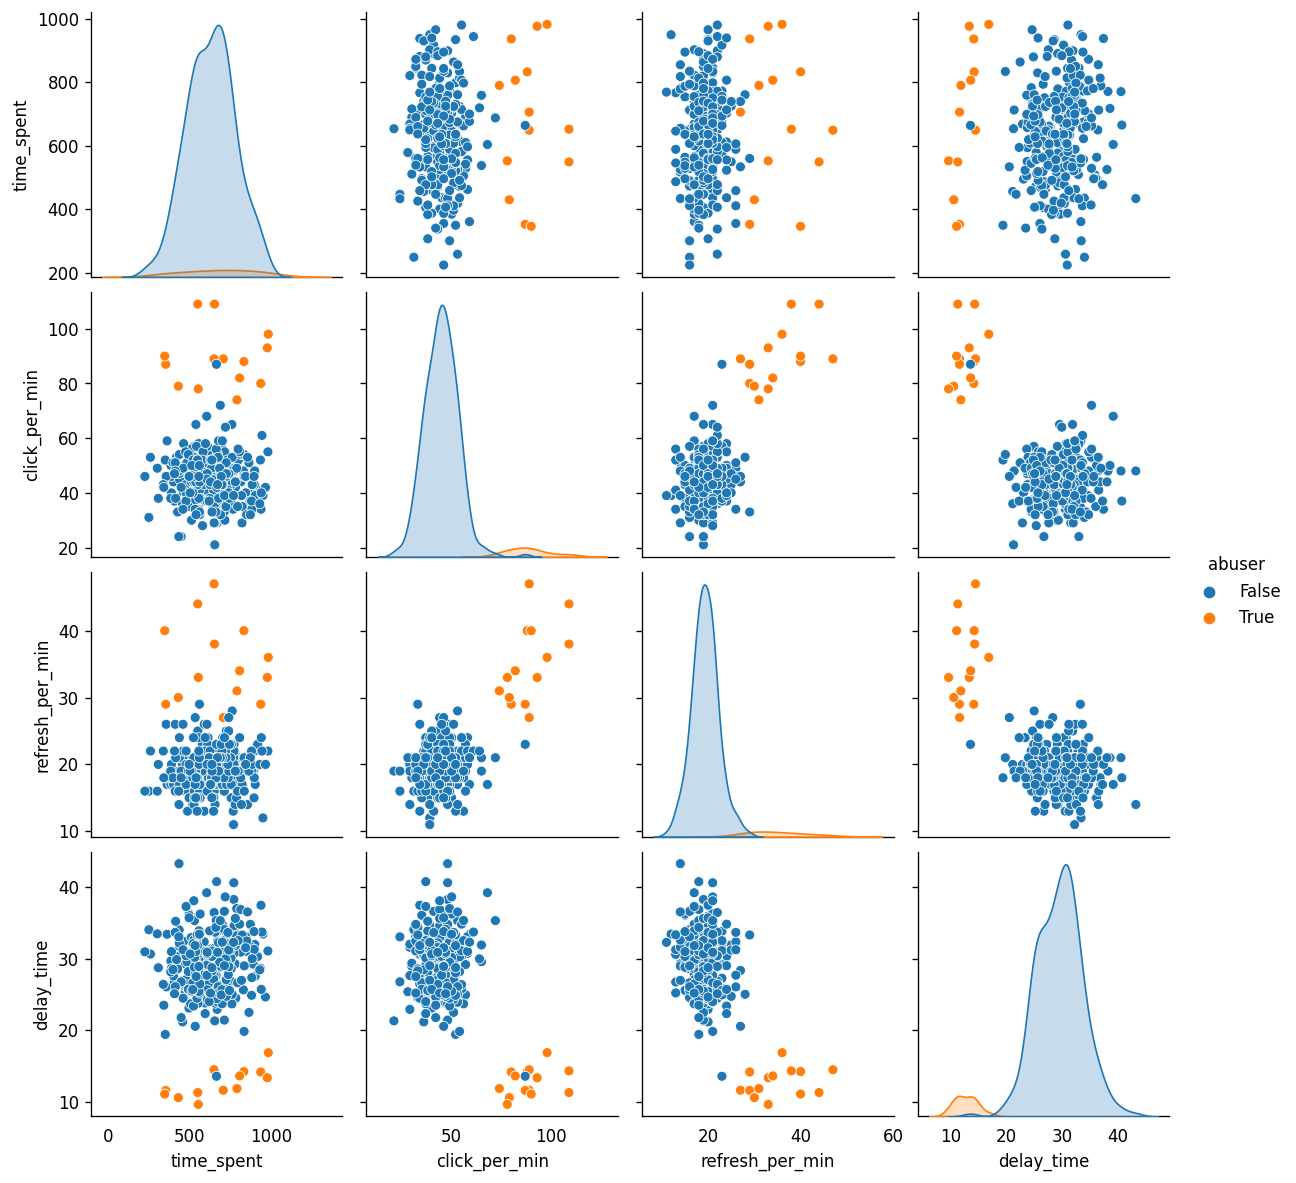

In [103]:
#####
outlier_candidate2 = df[
    condition_1 &
    condition_2 &  
    condition_3
    ] # 해당 조건 3개가 &로 묶이는 교집합 구조여야함.

df['abuser'] = False
df.loc[outlier_candidate2.index, 'abuser'] = True

######
g = sns.pairplot(df.drop(columns=['code_student']), hue='abuser')
plt.show()

### 1.6 Condition 세부조정하기2

이번에는 Outlier라고 생각했던 값도 조건이 너무 빡빡한 탓에 걸러내지 못한 것 같군요.

조건을 조금 수정해봐야겠어요, 중학교 때 배운 집합을 생각해볼까요? 

**[hint]**

지금까지의 집합을 조건으로 표현하여

* **set A = {click_per_mind 의 Outlier}**

* **set B = {refresh_per_min의 Outlier}**

* **set C = {delay_time의 Outlier}**

이라고 가정해볼까요?

이 경우,

1. 우리가 처음 사용한 조건을 집합 수식으로 이렇게 정리할 수 있지 않을까요? $$condition_1 = A \cup B \cup C$$ 

2. 그 다음 사용한 조건을 집합 수식으로 정리하면 아래와 같겠죠? $$condition_2 = A \cap B \cap C$$

3. 그렇다면 우리가 놓친 조건은 무엇일까요?

4. 1.5절과 비슷한 문제에요! 조건을 수정하여 Outlier들을 구분하고 df를 갱신하여 그래프와 같은 그림이 나오도록 코드를 작성하세요.

5. z score 값, 혹은 outlier step의 계수는 변경하지 마세요.


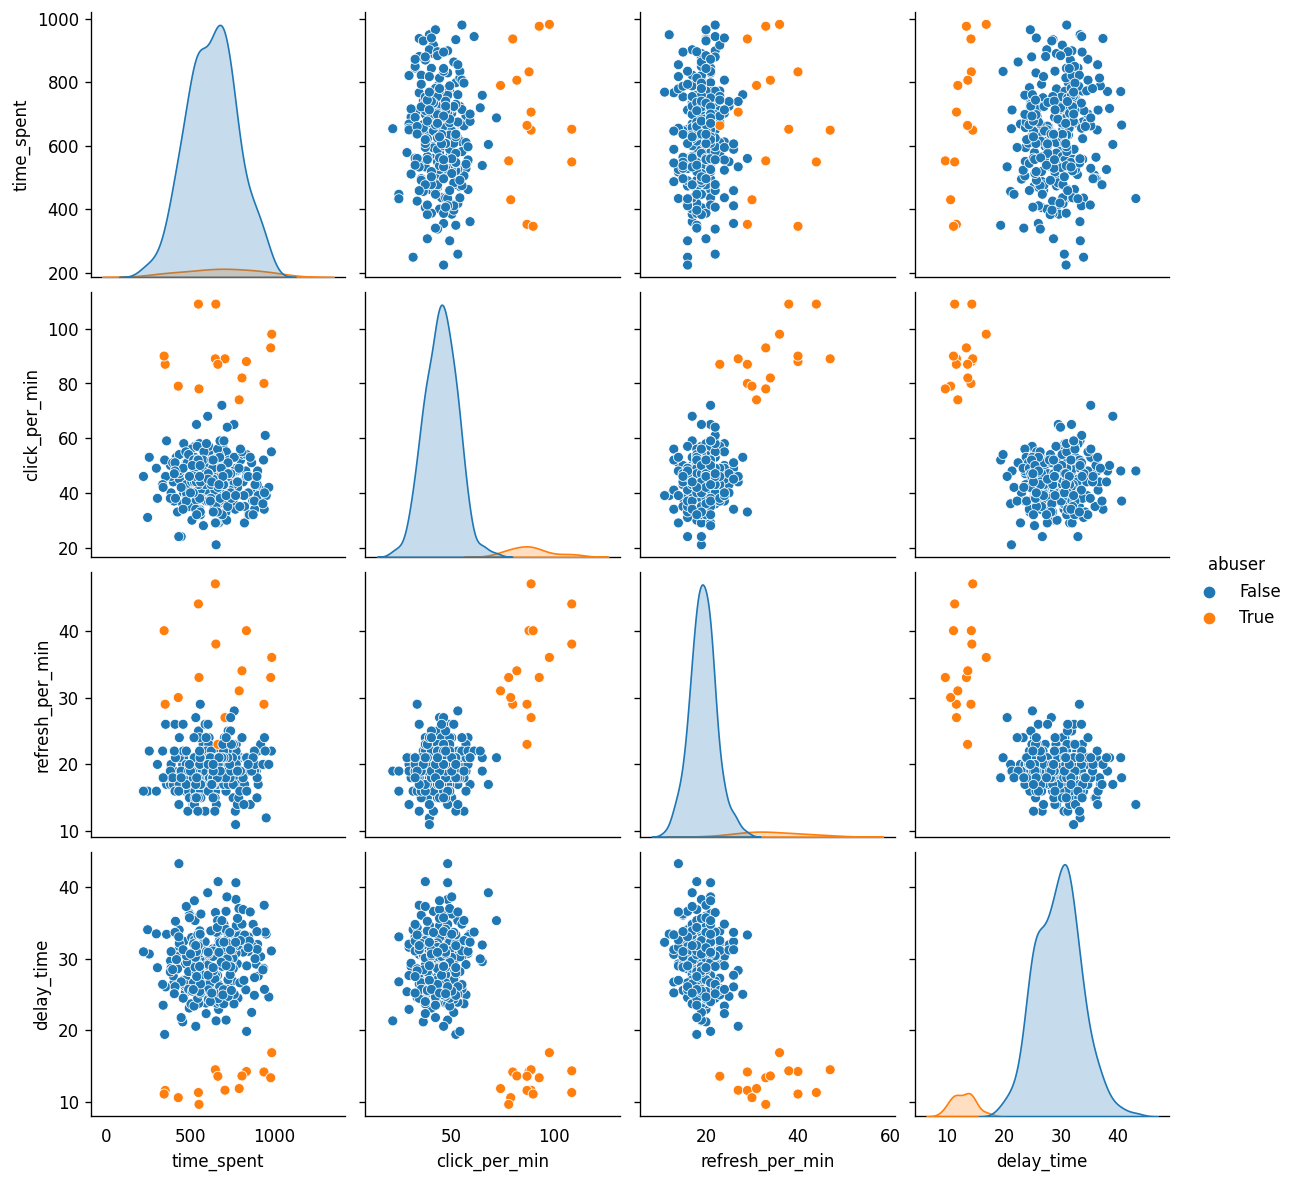

In [104]:
outlier_candidate3 = df[
    condition_3 #조건 상관없이 결과만 맞으면 정답
]

df['abuser'] = False
df.loc[df.code_student.isin(outlier_candidate3['code_student'].values), 'abuser'] = True

g = sns.pairplot(df.drop(columns=['code_student']), hue='abuser')
plt.show()

### 1.7 결과 작성 및 분석

---

조건을 잘 잡았더니 Outlier이 잘 검출된 것을 확인할 수 있죠?

Outlier로 판명되어서 조사가 필요한 학생의 학번의 리스트를 출력하고, msg칸에 Outlier의 행동 패턴을 기록해서 출력해주세요!

여러분께서 하셔야할 것은 다음과 같습니다!

**[Todo!]**
1. outliers에는 outlier로 검출된 학생들의 학번을 넣어주세요.
2. msg에는 ###를 지우고 행동 양상이 정상 사용자와 어떻게 다른지 `분당 클릭 횟수`, `분당 새로고침 횟수`, `서버 지연시간`을 정상 사용자와 비교하여 작성해주세요. `의미만 맞으면 모두 정답으로 인정할게요!`

3. outliers와 msg를 print 해주세요!

In [105]:
outliers = df[df['abuser']]['code_student'].unique()
msg = "outlier은 다음과 같으며, outlier들의 행동 양상은 기존 사용자에 비해 #####" #얼추 결과만 비슷한 의미이면 해당 파트는 정답

print(msg)
print(outliers) #학점이 같지 않으면 해당 파트는 0점

outlier은 다음과 같으며, outlier들의 행동 양상은 기존 사용자에 비해 #####
[201811933 201811958 201816880 201818738 201917437 202012285 202016312
 202017340 202017957 202018326 202110260 202117531 202119541 202211912
 202212354]


### 1.8 Oversampling

---

이번에는 추후 대책으로 매크로를 막는 인공지능을 학습하기 위해, 데이터를 전처리하는 과정을 다뤄보려고 해요.

방금 최대한 합리적인 조건으로 Outlier을 검출했었죠? 그런데 Outlier은 300명중 고작 15명 밖에 되지 않았어요.

이 경우 Data의 불균형이 너무 크게 일어나서, 인공지능이 학습을 제대로 하지 못하는 상황이 발생할 가능성이 높죠!

smote를 이용해서 df의 `abuser` 속성이 1:1이 되도록 조정한 `dummy`라는 DataFrame을 만들고 출력해주세요.

**[hint]**

1. `dummy`는 원본 `df`에 대해, `abuser` 속성의 **True**와 **False**의 비율이 1:1인 Oversampling된 DataFrame이에요.

2. 그리고 학번을 가상적으로 만들 수는 없으니, `code_student` 속성은 존재하지 않아요.

3. SMOTE가 업데이트 되는 바람에 수업자료와는 약간 내용이 다릅니다! 처음 SMOTE를 선언할 때, `sampling_strategy` argument에 **minority**를 주시고, `k_neighbors` argument에 **14**를 부여하세요.

4. X_sm으로 새로운 데이터프레임을 만들 때 들어가는 columns를 잘 생각해보세요.

5. y_sm가 무엇을 상징하는 것일까요? 함수에서 x와 y의 관계를 생각해보세요.

In [106]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'minority', k_neighbors=14)

X_sm, y_sm = smote.fit_resample(df[['time_spent', 'click_per_min', 'refresh_per_min', 'delay_time']], df['abuser'])

dummy = pd.DataFrame(X_sm, columns=['time_spent', 'click_per_min', 'refresh_per_min', 'delay_time'])
dummy['abuser'] = y_sm

# 코드 조금 달라도, 구름꼴 생성만 비슷하면 정답

dummy

time_spent  click_per_min  refresh_per_min  delay_time  abuser
0    471.551388             54               18   25.283161   False
1    723.369401             42               19   25.594568   False
2    653.702642             21               19   21.323300   False
3    603.981965             68               17   39.148978   False
4    510.630862             30               20   29.151656   False
..          ...            ...              ...         ...     ...
565  503.221324             87               26   12.601966    True
566  556.759083             84               29   12.544591    True
567  832.045560             84               34   14.129110    True
568  731.864932             84               28   11.746957    True
569  649.428420             91               45   14.507877    True

[570 rows x 5 columns]

Dummy에서 `abuser` 속성이 **True**인 개체들이 적당하게 잘 생성되었는지 확인해볼까요?

따로 코드를 입력하실 필요는 없습니다!

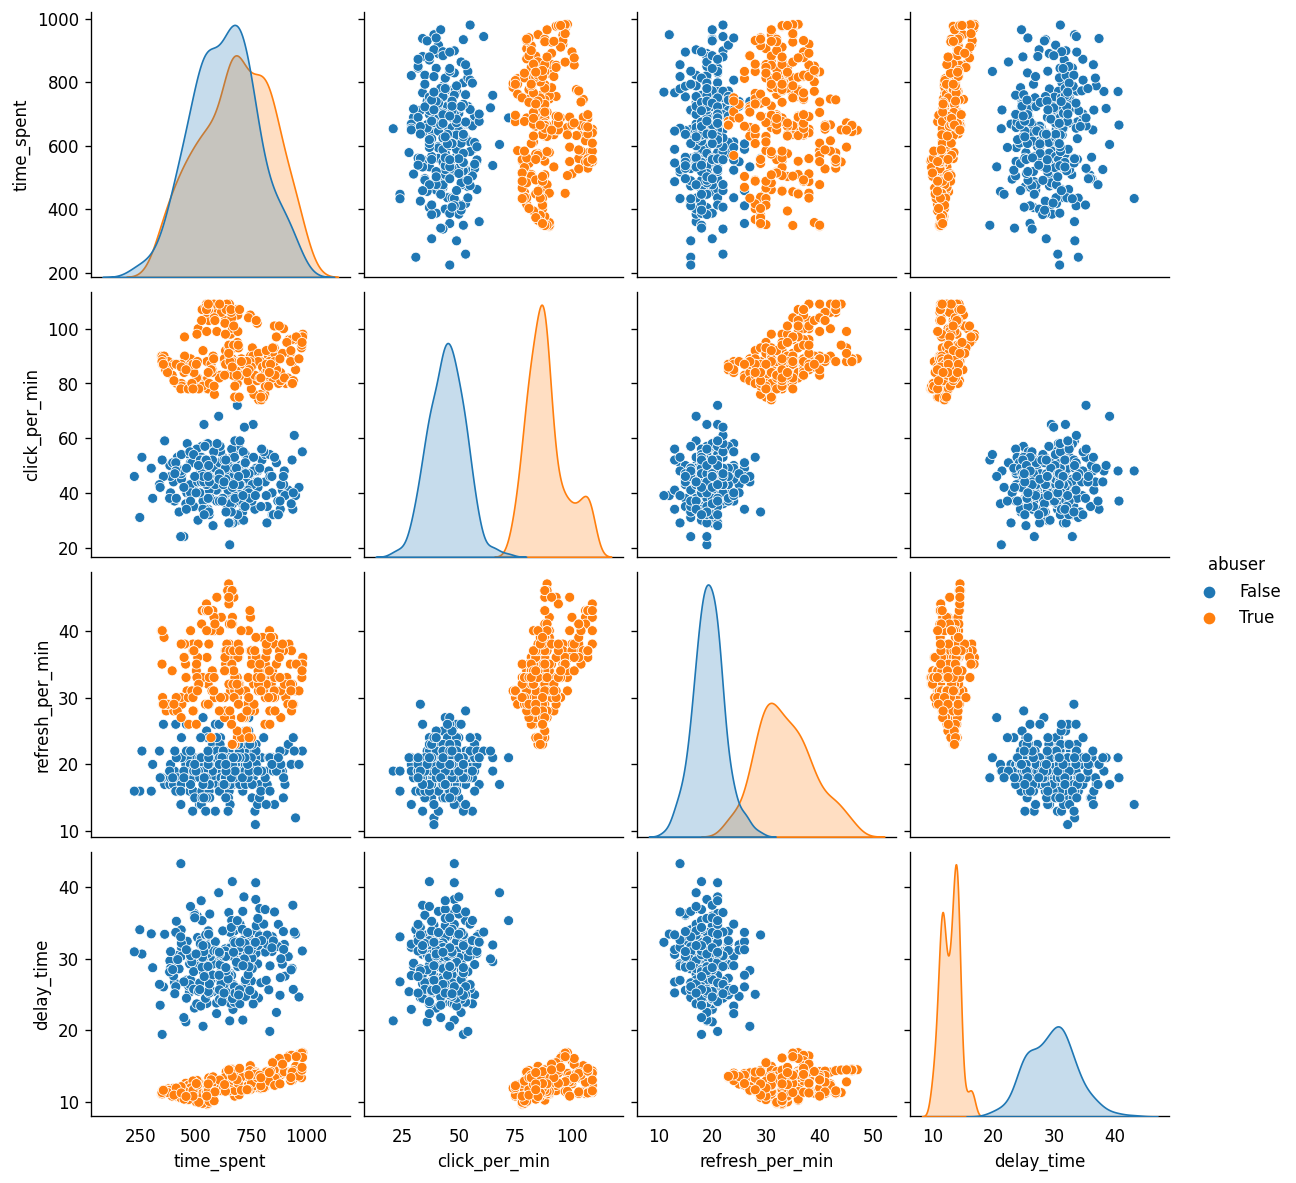

In [107]:
g = sns.pairplot(dummy, hue='abuser')
plt.show()

`abuser`속성의 True와 False 개수가 같은지 확인해보세요.

꼭 출력값과 같은 형태가 아니더라도 True의 개수와 False의 개수가 출력 결과로 보여져서 같다는 것이 입증 된다면, 정답으로 인정해드려요.

In [108]:
dummy[['abuser']].value_counts()
# 결과 달라도, 같은 것을 보였으면 인정

abuser
False     285
True      285
dtype: int64

끝! 

고생 많으셨고, 오류가 일어나는 출력이 없는지 잘 확인하시고 제출해주세요!

In [109]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Cars93 data
In this lab, we would like to explore data about 93 number of vehicles.

In [110]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/Cars93_miss.csv')
df.head()

Manufacturer    Model     Type  Min.Price  Price  Max.Price  MPG.city  \
0        Acura  Integra    Small       12.9   15.9       18.8      25.0   
1          NaN   Legend  Midsize       29.2   33.9       38.7      18.0   
2         Audi       90  Compact       25.9   29.1       32.3      20.0   
3         Audi      100  Midsize        NaN   37.7       44.6      19.0   
4          BMW     535i  Midsize        NaN   30.0        NaN      22.0   

   MPG.highway             AirBags DriveTrain  ... Passengers  Length  \
0         31.0                None      Front  ...        5.0   177.0   
1         25.0  Driver & Passenger      Front  ...        5.0   195.0   
2         26.0         Driver only      Front  ...        5.0   180.0   
3         26.0  Driver & Passenger        NaN  ...        6.0   193.0   
4         30.0                 NaN       Rear  ...        4.0   186.0   

   Wheelbase  Width  Turn.circle Rear.seat.room  Luggage.room  Weight  \
0      102.0   68.0         37.0           26.5           NaN  2705.0   
1      115.0   71.0         38.0           30.0          15.0  3560.0   
2      102.0   67.0         37.0           28.0          14.0  3375.0   
3      106.0    NaN         37.0           31.0          17.0  3405.0   
4      109.0   69.0         39.0           27.0          13.0  3640.0   

    Origin           Make  
0  non-USA  Acura Integra  
1  non-USA   Acura Legend  
2  non-USA        Audi 90  
3  non-USA       Audi 100  
4  non-USA       BMW 535i  

[5 rows x 27 columns]

# Drop Missing Value

In [111]:
dfNoMissing = df.dropna()
dfNoMissing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 2 to 90
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Manufacturer        20 non-null     object 
 1   Model               20 non-null     object 
 2   Type                20 non-null     object 
 3   Min.Price           20 non-null     float64
 4   Price               20 non-null     float64
 5   Max.Price           20 non-null     float64
 6   MPG.city            20 non-null     float64
 7   MPG.highway         20 non-null     float64
 8   AirBags             20 non-null     object 
 9   DriveTrain          20 non-null     object 
 10  Cylinders           20 non-null     object 
 11  EngineSize          20 non-null     float64
 12  Horsepower          20 non-null     float64
 13  RPM                 20 non-null     float64
 14  Rev.per.mile        20 non-null     float64
 15  Man.trans.avail     20 non-null     object 
 16  Fuel.tank.

# Scaling
**[TODO]** Rescale the numeric attribute using z-score. You can use Scikit-learn or Pandas

In [112]:
from sklearn.preprocessing import StandardScaler
# filter data with numeric attirbute
dfNumeric = dfNoMissing.select_dtypes(include='number')

# create a scaler object
stdScaler = StandardScaler()

# fit and transform the data
dfStd = pd.DataFrame(stdScaler.fit_transform(dfNumeric),
                          columns=dfNumeric.columns)

dfStd.head()

Min.Price     Price  Max.Price  MPG.city  MPG.highway  EngineSize  \
0   1.714462  1.909199   2.006788 -0.689169    -1.030448    0.085718   
1   1.194212  1.083765   0.954326 -1.550630    -1.284879    2.571534   
2   0.469014  0.334759   0.200537 -1.335265    -1.030448    1.971509   
3  -0.082767 -0.123815  -0.155025 -0.043073    -0.521585    0.257153   
4   2.282008  1.970342   1.608559 -0.689169    -1.030448    0.514307   

   Horsepower       RPM  Rev.per.mile  Fuel.tank.capacity  Passengers  \
0    0.936406  0.468046      0.088902            0.255073   -0.074744   
1    1.139696 -1.952883     -1.807669            2.118481    1.420127   
2    0.885583 -1.630093     -1.748401            2.118481    1.420127   
3    0.148656 -0.338930     -0.286461           -0.019856    1.420127   
4    0.301124 -0.661721     -0.889017           -0.019856    1.420127   

     Length  Wheelbase     Width  Turn.circle  Rear.seat.room  Luggage.room  \
0 -0.060346  -0.108605 -0.256332    -0.318616       -0.154074     -0.209020   
1  2.008662   1.791984  2.195540     1.897842        0.808890      2.229546   
2  1.893717   1.791984  1.972642     1.066670        0.423704      1.881179   
3  0.112071   0.162908 -0.033435     0.789613        0.808890     -0.209020   
4  1.261520   0.977446  0.189463     1.620785        2.927411      0.836080   

     Weight  
0  0.684456  
1  1.934368  
2  1.600487  
3  0.187915  
4  1.018336

# Encoding
Filter categorical attribute and remove unnessary attribute using `.drop()` 
* unnessary attribute: `Manufacturer`,	`Model`, `Make`

In [113]:
dfFilter = dfNoMissing.select_dtypes(exclude='number').drop(
    columns=['Manufacturer', 'Model', 'Make'])
dfFilter.head()

Type             AirBags DriveTrain Cylinders Man.trans.avail   Origin
2   Compact         Driver only      Front         6             Yes  non-USA
7     Large         Driver only       Rear         6              No      USA
17    Large         Driver only       Rear         8              No      USA
20  Compact  Driver & Passenger      Front         4              No      USA
21    Large         Driver only      Front         6              No      USA

**[TODO]** Encode remaining categorical attiribute into numeric attribute using label encoding.

In [114]:
from sklearn.preprocessing import LabelEncoder

# create a encoder object
enc = LabelEncoder()

# create empthy dataframe 
dfEnc = pd.DataFrame()

# fill up data frame with encoded attribute using iteration
for col in dfFilter.columns:
  dfEnc[col] = enc.fit_transform(dfFilter[col])

dfEnc.head()

Type  AirBags  DriveTrain  Cylinders  Man.trans.avail  Origin
0     0        1           1          2                1       1
1     1        1           2          2                0       0
2     1        1           2          3                0       0
3     0        0           1          1                0       0
4     1        1           1          2                0       0

Merge `df_enc` and `df_std`.

In [115]:
dfProcessed = pd.concat((dfEnc, dfStd), axis=1)
dfProcessed

Type  AirBags  DriveTrain  Cylinders  Man.trans.avail  Origin  Min.Price  \
0      0        1           1          2                1       1   1.714462   
1      1        1           2          2                0       0   1.194212   
2      1        1           2          3                0       0   0.469014   
3      0        0           1          1                0       0  -0.082767   
4      1        1           1          2                0       0   2.282008   
5      3        2           1          1                1       0  -1.123268   
6      3        2           1          1                1       1  -1.296685   
7      3        2           1          1                1       1  -1.202094   
8      3        2           1          1                1       1  -0.650313   
9      0        1           1          1                1       1  -0.114297   
10     2        2           2          2                0       0  -0.019706   
11     0        1           1          1                1       1  -0.319245   
12     0        2           1          1                0       0  -0.319245   
13     2        2           1          2                1       0   0.059119   
14     1        0           1          2                0       0   0.689726   
15     3        2           0          0                1       1  -1.217859   
16     3        2           0          1                1       1  -0.713374   
17     3        2           1          1                1       1  -0.997147   
18     0        2           1          1                1       1   0.405953   
19     4        2           1          2                1       1   1.241507   

       Price  Max.Price  MPG.city  ...  Rev.per.mile  Fuel.tank.capacity  \
0   1.909199   2.006788 -0.689169  ...      0.088902            0.255073   
1   1.083765   0.954326 -1.550630  ...     -1.807669            2.118481   
2   0.334759   0.200537 -1.335265  ...     -1.748401            2.118481   
3  -0.123815  -0.155025 -0.043073  ...     -0.286461           -0.019856   
4   1.970342   1.608559 -0.689169  ...     -0.889017           -0.019856   
5  -0.674105  -0.240359  1.249118  ...      0.533410           -0.875191   
6  -1.316109  -1.278598  1.249118  ...      0.938407           -1.272310   
7  -1.270252  -1.292821  1.249118  ...      0.266705           -0.875191   
8  -0.765820  -0.837702  1.033753  ...     -0.029634           -0.478071   
9  -0.016814   0.072534  0.603023  ...      0.533410           -0.172594   
10 -0.261388  -0.467919 -0.904534  ...     -0.997675            0.591097   
11 -0.139101   0.015645  0.172292  ...     -0.207437           -0.050404   
12 -0.475389  -0.595921  0.172292  ...      0.286461           -0.264237   
13  0.288902   0.484986 -0.904534  ...     -0.681580            0.132882   
14  1.190765   1.594337 -0.904534  ...     -1.323648            0.591097   
15 -1.254966  -1.235931  2.110579  ...      1.264380           -2.097097   
16 -0.872820  -0.979927  0.387657  ...      2.252177           -0.050404   
17 -1.147965  -1.235931  0.387657  ...      0.622312           -1.119572   
18  0.518189   0.598765 -0.473804  ...      0.889017            0.743836   
19  1.022621   0.783657 -1.119899  ...      0.296339            0.743836   

    Passengers    Length  Wheelbase     Width  Turn.circle  Rear.seat.room  \
0    -0.074744 -0.060346  -0.108605 -0.256332    -0.318616       -0.154074   
1     1.420127  2.008662   1.791984  2.195540     1.897842        0.808890   
2     1.420127  1.893717   1.791984  1.972642     1.066670        0.423704   
3     1.420127  0.112071   0.162908 -0.033435     0.789613        0.808890   
4     1.420127  1.261520   0.977446  0.189463     1.620785        2.927411   
5    -0.074744 -0.405181  -0.651630 -0.479229    -0.595673       -0.731853   
6    -0.074744 -0.750015  -1.194656 -1.147922    -0.872730       -0.924445   
7    -1.569614 -0.979905  -0.787387 -0.479229    -1.149787       -0.539260   
8    -0.074744 -0.520126

# Todo!
---
** 목표 : 국민건강보험공단 건강검진 정보 데이터를 활용하여 scaling, encoding, correlation 해결하기**


# KNN Imputation & Z-score Standardization
---
KNN Imputation 와 Z-score Standardization 사용할때의 순서에 따른 값이 어떻게 다른지, 어떠한 효과가 있는지 비교하기

## 1.KNN Imputation 사용 후 Z-score Standardization 사용하기

In [116]:
df = pd.read_csv('https://raw.githubusercontent.com/juyoung-han/DAP/main/lab6_health_data_edit.CSV')
df

year  height  weight  waist  eyesight  blood_pressure  sugar_level  \
0    2022     165    60.0   72.1       1.2            79.0         90.0   
1    2022     150    65.0   81.0       0.8            73.0         87.0   
2    2022     155    55.0   70.0       0.6            80.0        102.0   
3    2022     160    70.0   90.8       1.0            84.0        146.0   
4    2022     155    50.0   75.2       1.5            89.0        110.0   
..    ...     ...     ...    ...       ...             ...          ...   
994  2022     160    65.0   82.0       1.2            82.0        117.0   
995  2022     165    70.0   92.0       0.5            78.0        106.0   
996  2022     165    70.0   88.0       1.2            70.0        100.0   
997  2022     155    55.0   80.2       0.5            65.0         99.0   
998  2022     150    55.0   79.5       1.0            74.0        107.0   

     drinking smoking  dental_checkup cavity   plaque  
0       False     non           False  False      NaN  
1       False     non           False   True      NaN  
2       False     non           False    NaN      NaN  
3       False     non            True  False     good  
4       False     NaN           False   True      NaN  
..        ...     ...             ...    ...      ...  
994      True    past           False    NaN      NaN  
995      True  smoker           False    NaN      NaN  
996     False    past            True  False     good  
997      True     non            True   True  verybad  
998     False     non           False    NaN      NaN  

[999 rows x 12 columns]

###1.1 데이터형태 파악 및 불필요한 데이터 삭제하기
---
불필요한 데이터는 `.drop()` 을 이용하여 없애주세요 
* unnessary attribute: `year`

In [117]:
df.drop(['year'], inplace=True, axis=1)
df.head()

height  weight  waist  eyesight  blood_pressure  sugar_level  drinking  \
0     165    60.0   72.1       1.2            79.0         90.0     False   
1     150    65.0   81.0       0.8            73.0         87.0     False   
2     155    55.0   70.0       0.6            80.0        102.0     False   
3     160    70.0   90.8       1.0            84.0        146.0     False   
4     155    50.0   75.2       1.5            89.0        110.0     False   

  smoking  dental_checkup cavity plaque  
0     non           False  False    NaN  
1     non           False   True    NaN  
2     non           False    NaN    NaN  
3     non            True  False   good  
4     NaN           False   True    NaN

In [118]:
df.describe()

height      weight       waist    eyesight  blood_pressure  \
count  999.000000  953.000000  999.000000  999.000000      990.000000   
mean   160.715716   62.261280   81.714214    0.920621       76.468687   
std      9.150449   12.079131    9.489783    0.654915        9.385386   
min    135.000000   35.000000   53.000000    0.100000       46.000000   
25%    155.000000   55.000000   75.000000    0.700000       70.000000   
50%    160.000000   60.000000   81.500000    0.900000       77.000000   
75%    170.000000   70.000000   88.000000    1.000000       82.000000   
max    190.000000  120.000000  128.000000    9.900000      116.000000   

       sugar_level  
count   990.000000  
mean    103.080808  
std      23.617519  
min      65.000000  
25%      91.000000  
50%      98.000000  
75%     108.000000  
max     367.000000

### 1.2 결측치의 위치 찾기
---
`weight` 에는 곳곳에 결측치가 있습니다. 결측치를 채우는 것이 목표입니다. 결측치를 처리할때 Scaling을 먼저하느냐 나중에 하느냐의 순서가 중요한지, 어떠한 영향을 끼치는지를 알아보려고 합니다. 따라서 Imputer와 Scaler 순서에 따른 결측치 채움값을 알아보겠습니다. 그러러면 먼저 결측치의 위치가 어디인지를 알아야합니다.
`weight`에서 결측치 있는곳의 `index`를 찾아주세요.

In [119]:
null_index = df[df['weight'].isnull()].index.tolist()
null_index = np.reshape(null_index, (1, -1))[0]
null_index

array([  6,  19,  33,  51,  70,  91, 110, 128, 143, 152, 161, 170, 189,
       204, 213, 228, 234, 243, 255, 270, 285, 297, 309, 324, 336, 348,
       357, 372, 400, 421, 436, 454, 469, 511, 565, 592, 616, 663, 691,
       748, 784, 832, 876, 905, 956, 983])

### 1.3 KNNImputer 사용하기
Hint: `[Lecture Note] 5_Data Preprocessing '30page'`

* use : `n_neighbors=5, weights=uniform`

In [120]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights='uniform')

df_imputed = pd.DataFrame(imputer.fit_transform(df.select_dtypes(include='number')),
             columns=df.select_dtypes(include='number').columns)
df_imputed

height  weight  waist  eyesight  blood_pressure  sugar_level
0     165.0    60.0   72.1       1.2            79.0         90.0
1     150.0    65.0   81.0       0.8            73.0         87.0
2     155.0    55.0   70.0       0.6            80.0        102.0
3     160.0    70.0   90.8       1.0            84.0        146.0
4     155.0    50.0   75.2       1.5            89.0        110.0
..      ...     ...    ...       ...             ...          ...
994   160.0    65.0   82.0       1.2            82.0        117.0
995   165.0    70.0   92.0       0.5            78.0        106.0
996   165.0    70.0   88.0       1.2            70.0        100.0
997   155.0    55.0   80.2       0.5            65.0         99.0
998   150.0    55.0   79.5       1.0            74.0        107.0

[999 rows x 6 columns]

### 1.4 StandardScaler 사용하기
* Hint : `[Lecture Note] 6_Data Preprocessing Part2 '15page'`

In [121]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
std_scaler = StandardScaler()

# fit and transform the data
imputed_scaler = pd.DataFrame(std_scaler.fit_transform(df_imputed.select_dtypes(include='number')),
                          columns=df_imputed.select_dtypes(include='number').columns)

imputed_scaler.head()

height    weight     waist  eyesight  blood_pressure  sugar_level
0  0.468439 -0.183055 -1.013620  0.426803        0.272652    -0.558222
1 -1.171646  0.235034 -0.075299 -0.184270       -0.369600    -0.685705
2 -0.624951 -0.601143 -1.235021 -0.489806        0.379694    -0.048288
3 -0.078256  0.653122  0.957908  0.121266        0.807862     1.821469
4 -0.624951 -1.019232 -0.686789  0.885107        1.343072     0.291668

### 1.5 결측치 채워진 값 확인하기
* 위에서 null값이었던 index를 저장해뒀던 null_index 기억하시죠? 
`weight`의 인덱스에 어떤 값으로 채워져있는지 확인해보세요.

In [122]:
IS_index = pd.DataFrame(imputed_scaler['weight'], index=null_index)
IS_index.head()

weight
6   0.318651
19 -0.015820
33 -1.102850
51 -1.270085
70 -0.601143

## 2.Z-score Standardization 사용 후 KNN Imputation 사용하기

### 2.1 Z-score Standardization

In [123]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
std_scaler = StandardScaler()

# fit and transform the data
df_std = pd.DataFrame(std_scaler.fit_transform(df.select_dtypes(include='number')),
                          columns=df.select_dtypes(include='number').columns)

df_std.head()

height    weight     waist  eyesight  blood_pressure  sugar_level
0  0.468439 -0.187304 -1.013620  0.426803        0.269844    -0.554140
1 -1.171646  0.226851 -0.075299 -0.184270       -0.369771    -0.681229
2 -0.624951 -0.601458 -1.235021 -0.489806        0.376447    -0.045786
3 -0.078256  0.641005  0.957908  0.121266        0.802857     1.818179
4 -0.624951 -1.015613 -0.686789  0.885107        1.335869     0.293117

### 2.2 KNN Imputation 
* use : `n_neighbors=5, weights= uniform`

In [124]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights='uniform')

scaled_imputer = pd.DataFrame(imputer.fit_transform(df_std.select_dtypes(include='number')),
             columns=df_std.select_dtypes(include='number').columns)
scaled_imputer.head()

height    weight     waist  eyesight  blood_pressure  sugar_level
0  0.468439 -0.187304 -1.013620  0.426803        0.269844    -0.554140
1 -1.171646  0.226851 -0.075299 -0.184270       -0.369771    -0.681229
2 -0.624951 -0.601458 -1.235021 -0.489806        0.376447    -0.045786
3 -0.078256  0.641005  0.957908  0.121266        0.802857     1.818179
4 -0.624951 -1.015613 -0.686789  0.885107        1.335869     0.293117

### 2.3 결측치 채워진 값 확인하기

In [125]:
SI_index = pd.DataFrame(scaled_imputer['weight'], index=null_index)
SI_index.head()

weight
6   0.144020
19 -0.104473
33 -1.181274
51 -1.429767
70 -0.518627

# Encoding

## 3.One Hot Encoding 사용하기
---
plaque(이빨의 치석상태)는 환자의 상태에 따라 good, verygood, bad, verybad 으로 진단되어있다. 이 값을 one hot encoding 을 이용하여 벡터화 한다. 

### 3.1 결측치 삭제하기 
* 치석 정보가 있는 환자들만 확인하기 위해 치석 상태를 표현 하지 않은 데이터들을 drop 해준다. 

<br/>

** 기존의 조건이 헷갈리게 명시된 점 죄송합니다. 채점시에는 'plaque'에 대해서만 적용해도, 전체 데이터에 대해서 적용해도 one-hot encoding 만 잘 사용했다면 동일하게 채점 하겠습니다. 또한 시험 문제 관련해서 조건에 대해 질문 주신 분들이 계셨는데, 시험 문제로 실습 문제가 나올경우 조건이 헷갈리지 않도록 명시될 것 입니다.

** 원본 데이터의 결과와 똑같이 나오려면 전체 데이터에 대해서 결측치 모두를 drop 해주시면 됩니다.

<br/>

[수정]


3.1 결측치 삭제하기
* 결측치에 대해서 모두 drop 해준다.

In [126]:
dfNoMissing = df.dropna()
dfNoMissing

height  weight  waist  eyesight  blood_pressure  sugar_level  drinking  \
3       160    70.0   90.8       1.0            84.0        146.0     False   
7       160    65.0   92.0       0.5            79.0         93.0     False   
12      175    80.0   90.0       0.8            80.0        114.0      True   
16      160    65.0   90.0       0.6            88.0         94.0      True   
27      155    60.0   82.0       0.5            85.0        104.0      True   
..      ...     ...    ...       ...             ...          ...       ...   
988     170    75.0   88.0       1.2            77.0        102.0      True   
989     170    70.0   77.0       0.7            84.0         99.0      True   
991     160    60.0   87.0       0.8            79.0        127.0      True   
996     165    70.0   88.0       1.2            70.0        100.0     False   
997     155    55.0   80.2       0.5            65.0         99.0      True   

    smoking  dental_checkup cavity    plaque  
3       non            True  False      good  
7    smoker            True  False  verygood  
12   smoker            True  False      good  
16      non            True  False   verybad  
27      non            True  False      good  
..      ...             ...    ...       ...  
988  smoker            True  False      good  
989  smoker            True   True   verybad  
991  smoker            True  False   verybad  
996    past            True  False      good  
997     non            True   True   verybad  

[311 rows x 11 columns]

### 3.2 numeric 이 아닌 데이터 선택하기

In [127]:
import pandas as pd
df_Filter = dfNoMissing.select_dtypes(exclude='number')
df_Filter

drinking smoking  dental_checkup cavity    plaque
3       False     non            True  False      good
7       False  smoker            True  False  verygood
12       True  smoker            True  False      good
16       True     non            True  False   verybad
27       True     non            True  False      good
..        ...     ...             ...    ...       ...
988      True  smoker            True  False      good
989      True  smoker            True   True   verybad
991      True  smoker            True  False   verybad
996     False    past            True  False      good
997      True     non            True   True   verybad

[311 rows x 5 columns]

### 3.3 one-hot encoding
* `plaque`에 대해 one-hot encoding

In [128]:
df_onehot = pd.get_dummies(df_Filter, prefix=['Teeth'], columns=['plaque'])
df_onehot.head()

drinking smoking  dental_checkup cavity  Teeth_bad  Teeth_good  \
3      False     non            True  False          0           1   
7      False  smoker            True  False          0           0   
12      True  smoker            True  False          0           1   
16      True     non            True  False          0           0   
27      True     non            True  False          0           1   

    Teeth_verybad  Teeth_verygood  
3               0               0  
7               0               1  
12              0               0  
16              1               0  
27              0               0

# Correlation

### 4. 여러 속성들 간의 상관관계 파악하기
Ref : `[Lecture Note] 6_Data Preprocessing Part2 'page34'`

### 4.1 Scaling 후 Imputation 한 값을 이용해서 상관관계 파악하기
---
각자 원하는 numeric 데이터를 가지고 상관관계 분석 후 유의미한 값 파악하기

* Hint : `1.KNN Imputation 사용 후 Maximum Absoulte Scaling` 문제의 `scaled_imputer` 사용하기

In [129]:
corr = scaled_imputer.corr()
corr_diagonsis = corr['weight'].abs().sort_values(ascending=False)
corr_diagonsis

weight            1.000000
waist             0.786807
height            0.687785
blood_pressure    0.287829
sugar_level       0.125813
eyesight          0.093866
Name: weight, dtype: float64

### 4.2 유의미하다고 판단되는 값 출력하기
* `corr_diagonsis` 가 0.4 이상인경우 출력


In [130]:
corr_diagonsis[corr_diagonsis >= 0.4]

weight    1.000000
waist     0.786807
height    0.687785
Name: weight, dtype: float64